# Initial Setup

In [3]:
!pip install torchinfo torchviz -q

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple
import math
import time

from dataclasses import dataclass # decorator for classes with less boilerplate: Auto-generates __init__, __repr__, etc.
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F # Functional interface for operations (activations, pooling, etc.)
import torch.optim as optim  # Optimization algorithms (SGD, Adam, etc.)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset  # DataLoader: Handles batching, shuffling, parallel loading. Dataset: Abstract class for custom datasets
from torch.utils.checkpoint import checkpoint

from torchinfo import summary
from torchviz import make_dot



# autocast: Automatic Mixed Precision - uses float16 where possible to speed up training while maintaining float32 for operations that need precision
# GradScaler: Scales gradients to prevent underflow when using float16.  Essential for stable mixed precision training
from torch.cuda.amp import autocast, GradScaler

from functools import partial # Creates partial functions by fixing some arguments. Useful for creating customized functions from general ones

import urllib.request
from PIL import Image


np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.8.0+cu126


### Helper for Visualization of Attention

In [5]:
def visualize_attention(attention_weights, tokens=None, title="Attention Weights"):
  """
  Visualize attetion weight matrix

  attention_weights: 2D tensor/array where element [i,j] shows how much
                    query position i attends to key position j
  tokens: Optional list of token strings for axis labels
  title: Plot title

  Attention weights show which parts of input the model focuses on
  Darker colors = higher attention scores
  """

  plt.figure(figsize=(10,8))

  sns.heatmap(
      attention_weights,
      cmap="Blues",
      cbar=True,
      square=True,
      xticklabels=tokens if tokens else False,
      yticklabels=tokens if tokens else False
  )
  plt.title(title)
  plt.xlabel("Keys")
  plt.ylabel("Queries")
  plt.show()


# Simplified Dot-Product Attention (Vanilla)

In [6]:
def simplified_attention(X):
  """
  Simplified attention mechanism
  ai = Σ αij*xj where αij = softmax(xi·xj)
  """

  N,d = X.shape  # N = number of tokens/positions, d = embedding dimension
  print(f"Input shape: {X.shape} (N={N} tokens, d={d} dims)")

  # Compute similarity scores with dot prod
  scores = np.zeros((N,N)) # (All the tokens x All the tokens) matrix
  for i in range(N):
    for j in range(N):
      if j <= i: # Causal mask, only attending to prev tokens. Token at position i can only "see" positions 0 to i
        scores[i,j] = np.dot(X[i], X[j])
      else:
        scores[i,j] = -np.inf

  print(f"\nScores shape:\n {scores.shape}")
  print(f"Scores:\n {np.round(scores,4)}\n")

  # Apply softmax for attention weights
  attention_weights = np.zeros_like(scores) # Return an array of zeros with the same shape and type as a given array.

  for i in range(N):
    exp_scores = np.exp(scores[i] - np.max(scores[i]))    #NUMERICAL STABILITY TRICK: Subtract max before exponentiating
    print("\nexp_scores: \n", exp_scores)
    attention_weights[i] = exp_scores / np.sum(exp_scores) # Normalize to get probs
    print(f"\nattention_weights[{i}]:\n ", attention_weights[i],"\n")


  print(f"attention_weights:\n ", np.round(attention_weights,3),"\n")

  print("attention_weights.shape:\n", attention_weights.shape)
  print("\n\n")


  print("Computation of Outputs\n")
  # Weighted sum for output
  output = np.zeros_like(X) # shape (N,d)
  for i in range(N):
    for j in range(i+1): # Only sum over positions we can attend to (causal)
      print(f"Current  output[{i}]: Embedding {output[i]} +=  Attention weight({attention_weights[i,j]}) * Input of X[{j}] ({X[j]})")

      output[i] += attention_weights[i,j] * X[j] # Each output token is a weighted combination of input tokens

      print(f"Updated  output[{i}]: Embedding {output[i]} \n")

  print(f"Output:\n {output}")

  print(f"Output shape: {output.shape}")
  return output, attention_weights


#### Simple test

Input shape: (8, 4) (N=8 tokens, d=4 dims)

Scores shape:
 (8, 8)
Scores:
 [[ 3.005     -inf    -inf    -inf    -inf    -inf    -inf    -inf]
 [ 2.1077  3.1925    -inf    -inf    -inf    -inf    -inf    -inf]
 [-1.3177 -1.1064  0.9464    -inf    -inf    -inf    -inf    -inf]
 [-1.5889 -2.7642 -0.0904  7.0107    -inf    -inf    -inf    -inf]
 [-3.2856 -2.3542  1.7245  1.5141  3.9437    -inf    -inf    -inf]
 [-1.367  -1.2771 -0.1783  1.4712  0.3955  4.2336    -inf    -inf]
 [-0.459  -1.4278  0.6742  1.4302  1.1008 -1.4359  1.7746    -inf]
 [ 2.1733  0.6802 -0.4601  0.4091 -1.5529 -3.4941  1.6831  4.2388]]


exp_scores: 
 [1. 0. 0. 0. 0. 0. 0. 0.]

attention_weights[0]:
  [1. 0. 0. 0. 0. 0. 0. 0.] 


exp_scores: 
 [0.33797358 1.         0.         0.         0.         0.
 0.         0.        ]

attention_weights[1]:
  [0.25260108 0.74739892 0.         0.         0.         0.
 0.         0.        ] 


exp_scores: 
 [0.10392148 0.12837566 1.         0.         0.         0.
 0.        

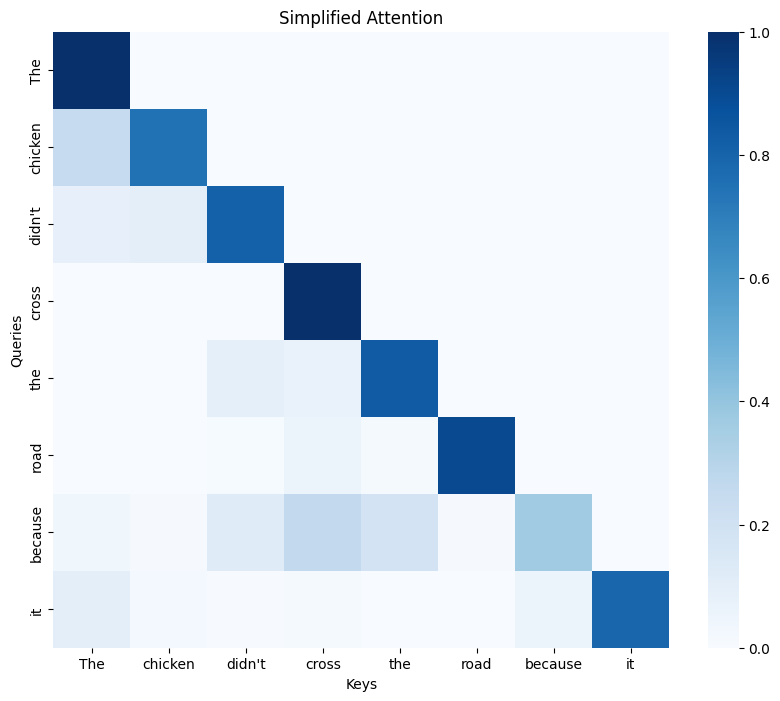

In [7]:
tokens = ["The", "chicken", "didn't", "cross", "the", "road", "because", "it"]
X = np.random.randn(len(tokens), 4)  # 8 tokens, 4 dims. In real models, dimensions are typically 512, 768, or 1024
output, weights = simplified_attention(X)

# Viz
visualize_attention(weights[:, :len(tokens)], tokens, "Simplified Attention")


# Attention with Q, K, V Matrices using NumPy

In [8]:
class AttentionNumpy:
  """
  Single attention head with Query, Key, Value matrices

  d_model: Dimension of input/output embeddings (model's hidden size)
  d_k: Dimension of queries and keys (typically d_model / num_heads)
  d_v: Dimension of values (often same as d_k)
  """

  def __init__(self, d_model, d_k, d_v):
    self.d_model = d_model
    self.d_k = d_k
    self.d_v = d_v

    # Initialize weight matrices
    self.W_Q = np.random.randn(d_model, d_k) * 0.1 # Query Projection
    self.W_K = np.random.randn(d_model, d_k) * 0.1 # Key Projection
    self.W_V = np.random.randn(d_model, d_v) * 0.1 # Value Projection

    self.W_O = np.random.randn(d_v, d_model) * 0.1  # Output projection: Projects concatenated/summed attention outputs back to model dimension

    print(f"Initialized weights: W_Q{self.W_Q.shape}, W_K{self.W_K.shape}, W_V{self.W_V.shape}, W_O{self.W_O.shape}")


  def forward(self, X):
    """
    X: [N, d_model] input sequence
    Returns: [N, d_model] attention output
    """

    N = X.shape[0] # Num of tokens/positions of the sequence

    Q = X @ self.W_Q # shpae [N, d_k]
    K = X @ self.W_K # shpae [N, d_k]
    V = X @ self.W_V # shpae [N, d_v]

    print(f"Q: {Q.shape}, K: {K.shape}, V: {V.shape}")


    # Scaled dot prod attention
    scores = (Q @ K.T) / np.sqrt(self.d_k) # [N, N]

    # Causal mask
    mask = np.triu(np.ones((N,N)) * -np.inf, k=1)
    scores = scores + mask

    # Softmax
    exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True)) # np.triu: Upper triangular matrix (k=1 means above main diagonal)
    attention_weights = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True) #  axis=-1: Apply along last dimension (rows) ;  keepdims=True: Maintains shape for broadcasting

    print(f"\nexp_scores shape: {exp_scores.shape}\n")
    print(f"\nexp_scores:\n {exp_scores.round(3)}\n")

    print(f"\nAttention weights shape: {attention_weights.shape}\n")
    print(f"\nAttention weights:\n {attention_weights.round(3)}\n")


    # Weighted sum of values
    head_output = attention_weights @ V # [N, d_v]

    # Output projection
    output = head_output @ self.W_O # [N, d_model]

    return output, attention_weights


#### Simple test

Initialized weights: W_Q(8, 4), W_K(8, 4), W_V(8, 4), W_O(4, 8)
Q: (8, 4), K: (8, 4), V: (8, 4)

exp_scores shape: (8, 8)


exp_scores:
 [[1.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.999 1.    0.    0.    0.    0.    0.    0.   ]
 [1.    0.943 0.935 0.    0.    0.    0.    0.   ]
 [0.919 0.884 0.964 1.    0.    0.    0.    0.   ]
 [0.995 0.995 0.925 0.94  1.    0.    0.    0.   ]
 [0.969 0.917 0.91  0.98  0.947 1.    0.    0.   ]
 [0.943 0.921 0.964 1.    0.88  0.961 0.938 0.   ]
 [0.913 0.952 0.97  0.94  0.919 0.907 1.    0.939]]


Attention weights shape: (8, 8)


Attention weights:
 [[1.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.5   0.5   0.    0.    0.    0.    0.    0.   ]
 [0.348 0.328 0.325 0.    0.    0.    0.    0.   ]
 [0.244 0.235 0.256 0.265 0.    0.    0.    0.   ]
 [0.205 0.205 0.191 0.194 0.206 0.    0.    0.   ]
 [0.169 0.16  0.159 0.171 0.165 0.175 0.    0.   ]
 [0.143 0.139 0.146 0.151 0.133 0.146 0.142 0.   ]
 [0.121 0.126 0.129 0.125 0.122 0.12  0.1

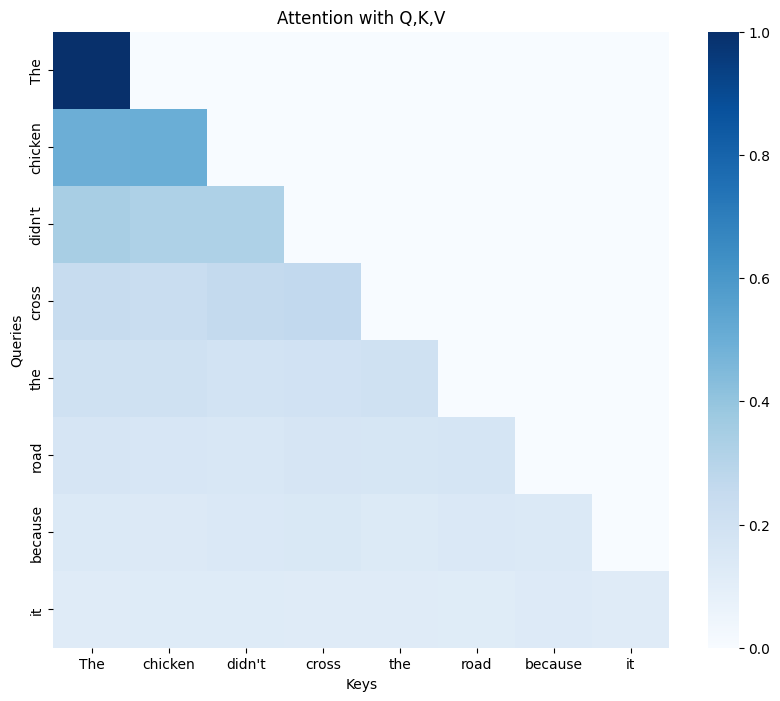

In [9]:
d_model, d_k, d_v = 8,4,4
attention = AttentionNumpy(d_model, d_k, d_v)

X = np.random.randn(len(tokens), d_model)
output, weights = attention.forward(X)

print(f"\nFinal output shape: {output.shape}")
visualize_attention(weights, tokens, "Attention with Q,K,V")

## Explanation of how nn.Linear handles batched inputs

Here's a brief explanation of how `nn.Linear` handles batched inputs:

```python
self.W_Q = nn.Linear(d_model, d_head, bias=False)
# Creates a weight matrix of shape [d_model, d_head]
# This is just a matrix, like W_Q = [[w11, w12, ...], [w21, w22, ...], ...]

Q = self.W_Q(x)  # x shape: [batch, seq_len, d_model]
                 # Q shape: [batch, seq_len, d_head]
```

**What's happening under the hood:**

`nn.Linear` is smart about dimensions. It applies matrix multiplication to the **last dimension** while preserving all previous dimensions:

```python
# What nn.Linear does internally (simplified):
# For input x with shape [batch, seq_len, d_model]
# It treats this as [*, d_model] where * = any number of preceding dimensions
# Then does: x @ W_Q.T for the last dimension

# Effectively, for each batch and each position:
# Q[batch_i][seq_j] = x[batch_i][seq_j] @ W_Q.T
# where @ is matrix multiply
```

**THE ONLY REQUIREMENT:**
- Input's **last dimension** must equal the Linear layer's **in_features**
- Everything else (batch size, sequence length, extra dimensions) can be anything

**Examples:**
```python
layer = nn.Linear(64, 32)  # Expects last dim = 64, outputs last dim = 32

# ✅ These all work:
layer(torch.randn(10, 64))        # [10, 64] → [10, 32]
layer(torch.randn(5, 20, 64))     # [5, 20, 64] → [5, 20, 32]
layer(torch.randn(2, 8, 12, 64))  # [2, 8, 12, 64] → [2, 8, 12, 32]

# ❌ These fail:
layer(torch.randn(10, 32))        # Error! Last dim 32 ≠ 64
layer(torch.randn(5, 20, 128))    # Error! Last dim 128 ≠ 64
```



**Visual example:**
```
If x = [2, 8, 64]  (2 batches, 8 positions, 64-dim embeddings)
   W_Q = [64, 16]   (transforms 64-dim → 16-dim)
   
nn.Linear applies the SAME weight matrix to:
- Batch 0, Position 0: [64] → [16]
- Batch 0, Position 1: [64] → [16]
- ...
- Batch 1, Position 7: [64] → [16]

Result Q = [2, 8, 16]  (same batch & seq_len, new dimension)
```

**The key insight:** `nn.Linear` automatically broadcasts its operation across all dimensions except the last one, so you don't need to write loops over batches or sequences. One weight matrix, applied everywhere!




**In summary:** Only the **last dimension** needs to match the layer's `in_features`. All other dimensions pass through unchanged.


# Single Attention Head using PyTorch

In [10]:
class AttentionHead(nn.Module):
  """
  PyTorch implementation of a single attention head

  d_model is the dimension of input/output embeddings (model's hidden size)
  d_head  is the compressed/projected dimension for computational efficiency and multi-head splitting, usually the embedding // num of attention heads

  """

  def __init__(self, d_model, d_head):
    super(AttentionHead,self).__init__()  #Initialize parent nn.Module class, this registers parameters and enables .to(device), .train(), etc.

    self.d_head  = d_head # Dimension of this attention head, although total model may have multiple heads (multi-head attention)

    # Linear projections for Q, K, V
    self.W_Q = nn.Linear(d_model, d_head, bias = False)
    self.W_K = nn.Linear(d_model, d_head, bias = False)
    self.W_V = nn.Linear(d_model, d_head, bias = False)
    self.W_O = nn.Linear(d_head, d_model, bias = False) # shape (hidden, output)

    self.scale = 1.0 / math.sqrt(d_head) # Pre-compute scaling factor for efficiency to prevent softmax saturation

  def forward(self, x, mask=None):
    """
    x: [batch, seq_len, d_model] ## PyTorch convention: batch dimension first for efficiency. This allows processing multiple sequences in parallel on GPU
    Returns: [batch, seq_len, d_model], attention_weights
    """

    batch_size, seq_len, d_model = x.shape


    # comput Q, K, V
    Q = self.W_Q(x)  # [batch, seq_len, d_head]  PyTorch's nn.Linear automatically handles batch dimension. It applies the same transformation to each batch element
    K = self.W_K(x)  # nn.Linear is smart about dimensions. It applies matrix multiplication to the last dimension while preserving all previous dimensions
    V = self.W_V(x)

    # Scaled dot prod attention
    scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale # [batch, seq_len, seq_len].   K.transpose(-2, -1): Swaps last two dimensions (seq_len, d_head) → (d_head, seq_len). Negative indexing: -1 = last dim, -2 = second-to-last

    # Mask if provided
    if mask is not None:
      scores = scores.masked_fill(mask == 0, -1e9)

    attn_weights = F.softmax(scores, dim = -1)  # dim=-1: Apply softmax along last dimension (over keys for each query)

    # Apply attention to values
    context = torch.matmul(attn_weights, V)  # [batch, seq_len, d_head]

    # Output
    output = self.W_O(context) # [batch, seq_len, d_model]  Project head dim back to model dim. Enables residual connections in full Transformer

    return(output, attn_weights)




### Test Multi-Head Attention

Input shape: torch.Size([2, 8, 64])
Mask shape: torch.Size([1, 8, 8])
Output shape: torch.Size([2, 8, 64])
Attention weights shape: torch.Size([2, 8, 8])


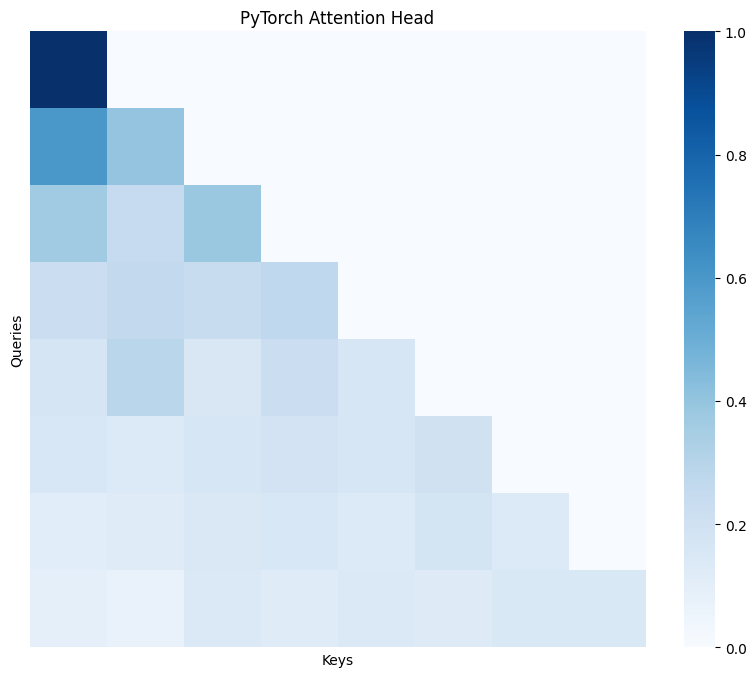

Layer (type:depth-idx)                   Output Shape              Param #
AttentionHead                            [2, 8, 64]                --
├─Linear: 1-1                            [2, 8, 16]                1,024
├─Linear: 1-2                            [2, 8, 16]                1,024
├─Linear: 1-3                            [2, 8, 16]                1,024
├─Linear: 1-4                            [2, 8, 64]                1,024
Total params: 4,096
Trainable params: 4,096
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.04

In [11]:
# Test PyTorch attention head
d_model, d_head = 64, 16
attention_head = AttentionHead(d_model, d_head)

# Create sample input
batch_size, seq_len = 2, 8
x = torch.randn(batch_size, seq_len, d_model)

# Create causal mask
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
print(f"Input shape: {x.shape}")
print(f"Mask shape: {mask.shape}")

output, attn_weights = attention_head(x, mask)
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")

# Visualize attention for first batch
visualize_attention(attn_weights[0].detach().numpy(), title="PyTorch Attention Head")

# Model summary
summary(attention_head, input_data=[x, mask], verbose=0)

#Multi-Head Attention with NumPy


In [12]:
class MultiHeadAttentionNumPy:
  """Multi-Head attention mechanism"""

  def __init__(self, d_model, n_heads, d_k, d_v):
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_k = d_k
    self.d_v = d_k

    self.W_Q = [np.random.randn(d_model, d_k) * 0.1 for _ in range(n_heads)  ]
    self.W_K = [np.random.randn(d_model, d_k) * 0.1 for _ in range(n_heads)  ]
    self.W_V = [np.random.randn(d_model, d_v) * 0.1 for _ in range(n_heads)  ]
    self.W_O = np.random.randn(n_heads * d_v, d_model) * 0.1

    print(f"Multi-head attention: {n_heads} heads, d_k={d_k}, d_v={d_v}")

  def forward(self, X):
    """
    X: [N, d_model]
    Returns: [N, d_model], list of attention weights per head
    """


    N = X.shape[0]
    head_outputs = []
    attention_weights_all = []

    # Processing each head
    for h in range(self.n_heads):
      # Compute Q, K, V per head
      Q_h = X @ self.W_Q[h]
      K_h = X @ self.W_K[h]
      V_h = X @ self.W_V[h]

      # scaled dot prod attntion
      scores = (Q_h @ K_h.T) / (np.sqrt(self.d_k))

      # causal mask
      mask = np.triu(np.ones((N,N)) * -np.inf,k=1 )
      scores = scores + mask

      # softmax with optimization and normalization
      exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True))  # Numerical stability trick: subtract max before exp
      attn_weights = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True) # Normalize to get probabilities [N, N]
      attention_weights_all.append(attn_weights)

      # Weighted sum
      head_out = attn_weights @ V_h  # [N, N] × [N, d_v] = [N, d_v] - Weighted combination of values
      head_outputs.append(head_out)

    # Concat heads
    concat_heads = np.concatenate(head_outputs, axis=1) # [N, d_v] × n_heads → [N, n_heads * d_v]
    print(f"Concatenated heads shape: {concat_heads.shape}")

    # Output projection
    output = concat_heads @ self.W_O  # [N, n_heads*d_v] × [n_heads*d_v, d_model] = [N, d_model] - Final output

    return(output, attention_weights_all)

### Test multi-head attention with Numpy


Multi-head attention: 4 heads, d_k=16, d_v=16
Concatenated heads shape: (8, 64)
Output shape: (8, 64)
Number of attention matrices: 4


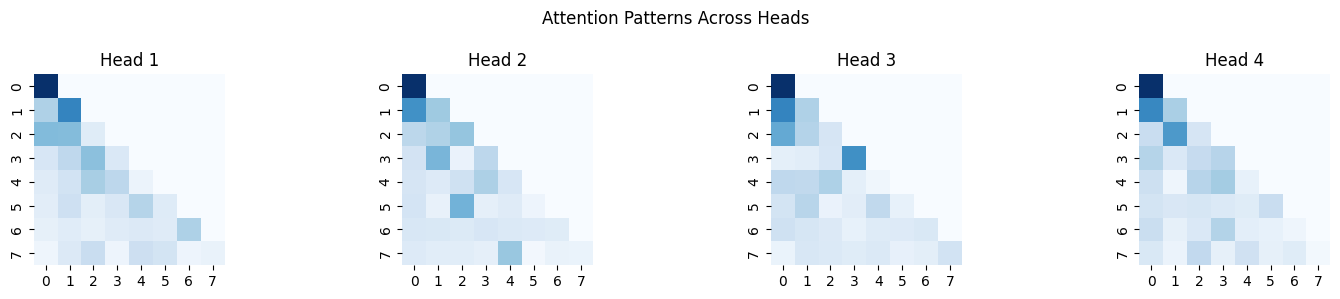

In [13]:
d_model, n_heads = 64, 4  # 64-dim embeddings, 4 parallel attention heads
d_k = d_v = d_model // n_heads  # 16 dims per head (64/4)
mha = MultiHeadAttentionNumPy(d_model, n_heads, d_k, d_v)
X = np.random.randn(8, d_model)  # Input: 8 tokens, each 64-dimensional
output, attn_weights_list = mha.forward(X)
print(f"Output shape: {output.shape}")  # Should be [8, 64]
print(f"Number of attention matrices: {len(attn_weights_list)}")  # Should be 4 (one per head)

# Visualize attention from different heads
fig, axes = plt.subplots(1, n_heads, figsize=(15, 3))
for i, (ax, attn) in enumerate(zip(axes, attn_weights_list)):
    sns.heatmap(attn, ax=ax, cmap='Blues', cbar=False, square=True)  # Each head learns different attention patterns
    ax.set_title(f"Head {i+1}")
plt.suptitle("Attention Patterns Across Heads")  # Different heads capture different relationships
plt.tight_layout()
plt.show()

#Multi-Head Attention with PyTorch

In [14]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads, dropout=0.1):
    super().__init__()

    assert d_model % n_heads == 0 # Ensure d_model is divisible by n_heads for even split

    self.d_model = d_model
    self.n_heads = n_heads
    self.d_k = d_model // n_heads

    # Single projection for all heads (more efficient)
    self.W_Q = nn.Linear(d_model, d_model, bias=False)
    self.W_K = nn.Linear(d_model, d_model, bias=False)
    self.W_V = nn.Linear(d_model, d_model, bias=False)
    self.W_O = nn.Linear(d_model, d_model, bias=False)

    self.dropout = nn.Dropout(dropout) # Regularization
    self.scale = 1.0 / math.sqrt(self.d_k)

  def forward(self, x, mask=None):
    """
    x: [batch, seq_len, d_model]
    Returns:
      x: [batch, seq_len, d_model] - transformed output
      attn_weights: [batch, n_heads, seq_len, seq_len] - attention weights
    """

    batch_size, seq_len, d_model = x.shape

    # Linear projections in batch from d_model => n_heads * d_k
    Q = self.W_Q(x).view(batch_size, seq_len, self.n_heads, self.d_k)  # [B, L, d] → [B, L, h, d_k] - Reshape to separate heads. view() is O(1) - just changes stride info. Each head gets d_k dimensions
    K = self.W_K(x).view(batch_size, seq_len, self.n_heads, self.d_k)
    V = self.W_V(x).view(batch_size, seq_len, self.n_heads, self.d_k)


    print(f"\nQ shape before transpose: {Q.shape}")


    # Transpose for attention: [batch, n_heads, seq_len, d_k].  [B, L, h, d_k] -> [B, h, L, d_k]
    Q = Q.transpose(1,2) # moves position 1 to position 2
    K = K.transpose(1,2)
    V = V.transpose(1,2)

    print(f"Q shape after transpose: {Q.shape}\n")


    # Scaled dot-product attention
    scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale  # [B, h, L, d_k] × [B, h, d_k, L] = [B, h, L, L]
    print(f"Attention scores shape: {scores.shape}\n")  # Each position attends to all positions


    # Apply mask
    if mask is not None:
       mask = mask.unsqueeze(0).unsqueeze(1) # [L,L] -> [1,L,L] broadcasting for heads dimension
       scores = scores.masked_fill(mask == 0, -1e4)  # FP16 safe: -10000 < 65504

    # Softmax
    attn_weights = F.softmax(scores,dim=-1)
    attn_weights = self.dropout(attn_weights) # Dropout

    # Apply attention to values
    context = torch.matmul(attn_weights, V)  # [B, h, L, L] × [B, h, L, d_k] = [B, h, L, d_k] - Weighted sum of values

    # Cncat heads
    context = context.transpose(1, 2).contiguous().view(  # transpose back: [B, L, h, d_k]
        batch_size, seq_len, d_model  # view: [B, L, h*d_k] = [B, L, d_model] - Merge all heads
    )  # contiguous() ensures memory layout is sequential after transpose (required for view)
    print(f"Context after concatenation: {context.shape}\n")

    # final linear projection
    output = self.W_O(context)  # [B, L, d_model] → [B, L, d_model] - Mix information from all heads

    return(output, attn_weights)


### Test PyTorch Multi-head attention


In [15]:
mha_torch = MultiHeadAttention(d_model=128, n_heads=8)  # 8 heads × 16 dims = 128 total
x = torch.randn(2, 10, 128)  # [batch=2, seq=10, d_model=128] - 2 sequences, 10 tokens each
mask = torch.tril(torch.ones(10, 10))  # Lower triangular causal mask (can't attend to future)
output, attn_weights = mha_torch(x, mask)
print(f"\nFinal output shape: {output.shape}")  # Should be [2, 10, 128]
print(f"Attention weights shape: {attn_weights.shape}")  # [2, 8, 10, 10] - attention map per head per batch

# Create computation graph
y = output.mean()  # Scalar output needed for autograd graph
graph = make_dot(y, params=dict(mha_torch.named_parameters()))  # Visualize backward pass connections
graph.render("Multi_head_attention", format="png", cleanup=True)
print("Computation graph saved as 'Multi_head_attention.png'")


Q shape before transpose: torch.Size([2, 10, 8, 16])
Q shape after transpose: torch.Size([2, 8, 10, 16])

Attention scores shape: torch.Size([2, 8, 10, 10])

Context after concatenation: torch.Size([2, 10, 128])


Final output shape: torch.Size([2, 10, 128])
Attention weights shape: torch.Size([2, 8, 10, 10])
Computation graph saved as 'Multi_head_attention.png'


#Feedforward Network

In [16]:
class FeedForward(nn.Module):
  """
  FFN(x) = ReLU(xW1 + b1)W2 + b2
  Usually d_ff = 4 * d_model
  """

  def __init__(self, d_model, d_ff=None, dropout=0.1, activation='relu'):
    super().__init__()

    d_ff = 4*d_model # Default: expand by 4x (e.g., 512 → 2048)

    self.linear1 = nn.Linear(d_model, d_ff)
    self.linear2 = nn.Linear(d_ff, d_model)

    self.dropout = nn.Dropout(dropout)

    self.activation = nn.ReLU() if activation =='relu' else nn.GELU() # GELU: smoother, differentiable everywhere
    self.activation_name = activation

    print(f"\nFFN: {d_model} → {d_ff} → {d_model} with {activation}")


  def forward(self,x):
    """
    x: [batch, seq_len, d_model]
    Returns: [batch, seq_len, d_model]
    """

    # First layer: linear + activation + regularization
    x = self.linear1(x) # [B, L, d_model] → [B, L, d_ff] - Project to higher dimension
    x = self.activation(x)
    x = self.dropout(x)

    # Second layer
    x = self.linear2(x) # [B, L, d_ff] → [B, L, d_model] - Project back to original dimension

    print(f"After linear2: {x.shape}")

    return(x)


### Simple test comparing ReLU vs GELU


FFN: 128 → 512 → 128 with relu

FFN: 128 → 512 → 128 with gelu
After linear2: torch.Size([2, 10, 128])
After linear2: torch.Size([2, 10, 128])


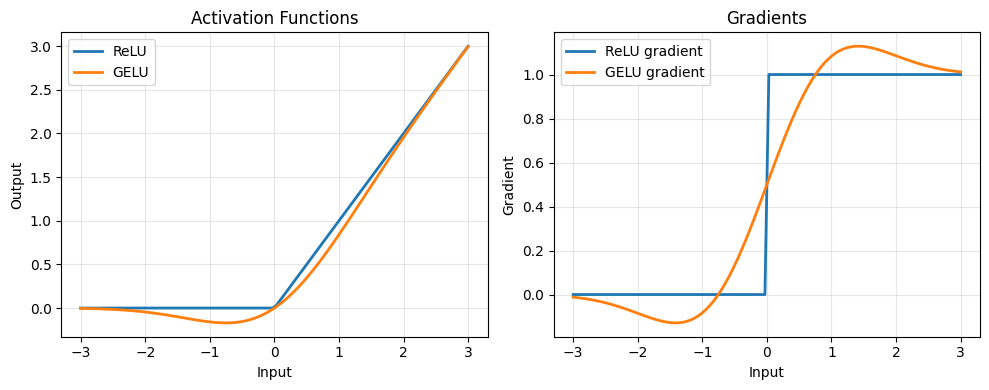

In [17]:
d_model = 128

ffn_relu = FeedForward(d_model, activation='relu')
ffn_gelu = FeedForward(d_model, activation='gelu')

x = torch.randn(2,10, d_model)   # [batch=2, seq=10, features=128]

out_relu = ffn_relu(x)
out_gelu = ffn_gelu(x)

# Visualization
x_test = torch.linspace(-3,3, 100)
relu_out = F.relu(x_test)
gelu_out = F.gelu(x_test)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(x_test, relu_out, label='ReLU', linewidth=2)
plt.plot(x_test, gelu_out, label='GELU', linewidth=2)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Activation Functions')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2) # Derivatives
relu_grad = (x_test > 0).float()  # ReLU gradient: 0 if x<0, 1 if x>0 (undefined at 0)
x_test.requires_grad = True  # Enable gradient computation for GELU
gelu_out = F.gelu(x_test)
gelu_grad = torch.autograd.grad(gelu_out.sum(), x_test, create_graph=True)[0]  # Compute GELU gradient via autograd

plt.plot(x_test.detach(), relu_grad, label='ReLU gradient', linewidth=2)  # Step function
plt.plot(x_test.detach(), gelu_grad.detach(), label='GELU gradient', linewidth=2)  # Smooth S-curve
plt.xlabel('Input')
plt.ylabel('Gradient')
plt.title('Gradients')  # GELU has non-zero gradients for negative inputs (helps with dead neurons)
plt.legend()
plt.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

#Layer Normalization with Numpy

In [18]:
class LayerNormNumPy:
  def __init__(self, d_model, eps=1e-5):
    self.d_model = d_model # Channels
    self.eps = eps # Small constant for numerical stability

    # Learnable params
    self.gamma = np.ones(d_model)
    self.beta  = np.zeros(d_model)

  def forward(self, x):
    """ Normalize over last dimetnsion"""

    # Compute mean and std
    mean = np.mean(x, axis=-1, keepdims=True) # axis=-1 apply along last dim (rows), keepdims mantain dimensionality for broadcasting
    var = np.var(x, axis=-1, keepdims=True)
    std = np.sqrt(var + self.eps) # epsilon brings num stability

    print(f"Mean shape: {mean.shape}, first 3 values: {mean.flat[:3].round(3)}\n")
    print(f"Std shape: {std.shape}, first 3 values: {std.flat[:3].round(3)}\n")


    # Normalize
    x_norm = (x-mean)/std

    # Scale and shift
    output = self.gamma * x_norm + self.beta

    print("output = self.gamma * x_norm + self.beta \n")
    print(f"output {output} =\n gamma {self.gamma} * \n x_norm{x_norm.ravel()} \n+ beta {self.beta} ")


    return(output)

In [19]:
d_model = 8
x = np.random.randn(2, 4, d_model) * 5 + 2  # Non-normalized input

# Numpy implementation
ln_numpy = LayerNormNumPy(d_model)
out_numpy = ln_numpy.forward(x)

# Same but with pyTorch
ln_torch = nn.LayerNorm(d_model)
x_torch = torch.tensor(x, dtype=torch.float32)
out_torch = ln_torch(x_torch)

print(f"\nInput stats - Mean: {x.mean():.3f}, Std: {x.std():.3f}")
print(f"Numpy output stats - Mean: {out_numpy.mean():.3f}, Std: {out_numpy.std():.16f}")
print(f"PyTorch output stats - Mean: {out_torch.mean():.3f}, Std: {out_torch.std():.16f}")

print(f"{'PyTorch' if (abs(1-out_torch.std().item()) < abs(1-out_numpy.std())) else 'NumPy'} std closest to 1.0")

Mean shape: (2, 4, 1), first 3 values: [0.889 1.195 6.311]

Std shape: (2, 4, 1), first 3 values: [4.039 5.595 4.764]

output = self.gamma * x_norm + self.beta 

output [[[ 0.05608816 -0.43263643  0.12793853  0.89538233 -2.41932988
    0.76287743  0.65769833  0.35198154]
  [ 0.01050664 -2.1494205  -0.24915214  1.74319159  0.15547978
   -0.1306787   0.15905901  0.46101432]
  [-0.21345203 -1.14518367 -0.45895448  0.8548644   0.15121159
    1.55143179 -1.59429784  0.85438023]
  [-1.23940163  0.16690202  0.63259379 -0.89540083 -0.15953033
    0.85134195 -1.14058434  1.78407938]]

 [[-1.51781366  2.0076912   1.01252731 -0.14456499 -0.47644982
   -0.58712671 -0.19342364 -0.10083967]
  [ 1.22779166  1.9014589   0.23078953 -0.7559787  -0.47279035
   -0.1303654  -0.93019016 -1.07071549]
  [ 1.63434473  0.15092271 -0.78793422  0.57580894 -1.07330209
   -1.00524121 -0.76305993  1.26846106]
  [ 0.11066001 -1.80997058  1.39435166  0.06371421 -1.29024582
    0.05467441  0.7897202   0.6870959 ]]] =
 

#Complete Transformer Block

In [20]:
class TransformerBlock(nn.Module):
  """
  Pre-norm Transformer block with Residual Connections
  x -> Norm Layer -> Residual Layer -> Norm Layer -> FeedForward -> Residual Connection
  """

  def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1):
    super().__init__()

    # Multi-head attention
    self.attention = MultiHeadAttention(d_model, n_heads, dropout)
    self.norm1 = nn.LayerNorm(d_model)

    # Feedforward
    self.ffn = FeedForward(d_model, d_ff, dropout)
    self.norm2 = nn.LayerNorm(d_model)

    self.dropout = nn.Dropout(dropout)


  def forward(self, x, mask=None):
    """
    x: [batch, seq_len, d_model]
    Returns: [batch, seq_len, d_model], attn_weights
    """

    # Self-attention with Residual Connection
    residual = x
    x = self.norm1(x)  # Pre-norm architecture
    attn_out, attn_weights = self.attention(x, mask)
    x = residual + self.dropout(attn_out) # Residual Connection


    # FFN with Residual Connection
    residual = x
    x = self.norm2(x) # Pre-norm arch
    ffn_out = self.ffn(x)
    x = residual + self.dropout(ffn_out)# Residual Connection


    return( x, attn_weights)


# Test transformer block



FFN: 128 → 512 → 128 with relu

Q shape before transpose: torch.Size([2, 10, 8, 16])
Q shape after transpose: torch.Size([2, 8, 10, 16])

Attention scores shape: torch.Size([2, 8, 10, 10])

Context after concatenation: torch.Size([2, 10, 128])

After linear2: torch.Size([2, 10, 128])
Block input shape: torch.Size([2, 10, 128])
Block output shape: torch.Size([2, 10, 128])
Attention weights shape: torch.Size([2, 8, 10, 10])


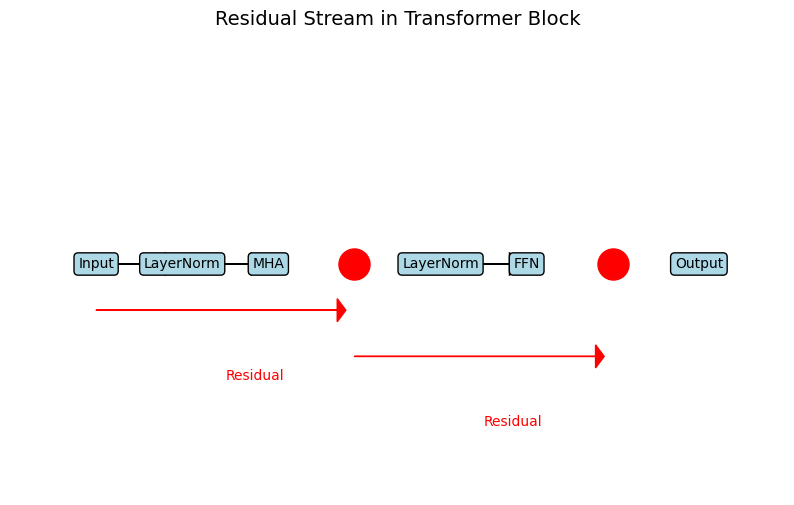


Q shape before transpose: torch.Size([2, 10, 8, 16])
Q shape after transpose: torch.Size([2, 8, 10, 16])

Attention scores shape: torch.Size([2, 8, 10, 10])

Context after concatenation: torch.Size([2, 10, 128])

After linear2: torch.Size([2, 10, 128])


Layer (type:depth-idx)                   Output Shape              Param #
TransformerBlock                         [2, 10, 128]              --
├─LayerNorm: 1-1                         [2, 10, 128]              256
├─MultiHeadAttention: 1-2                [2, 10, 128]              --
│    └─Linear: 2-1                       [2, 10, 128]              16,384
│    └─Linear: 2-2                       [2, 10, 128]              16,384
│    └─Linear: 2-3                       [2, 10, 128]              16,384
│    └─Dropout: 2-4                      [2, 8, 10, 10]            --
│    └─Linear: 2-5                       [2, 10, 128]              16,384
├─Dropout: 1-3                           [2, 10, 128]              --
├─LayerNorm: 1-4                         [2, 10, 128]              256
├─FeedForward: 1-5                       [2, 10, 128]              --
│    └─Linear: 2-6                       [2, 10, 512]              66,048
│    └─ReLU: 2-7                         [2, 10, 512]          

In [21]:
block = TransformerBlock(d_model=128, n_heads=8)
x = torch.randn(2, 10, 128)
mask = torch.tril(torch.ones(10, 10))

output, attn_weights = block(x, mask)
print(f"Block input shape: {x.shape}")
print(f"Block output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")

# Visualize residual stream concept
def visualize_residual_stream():
    """Show how information flows through residual connections"""
    fig, ax = plt.subplots(figsize=(10, 6))

    # Draw components
    components = ['Input', 'LayerNorm', 'MHA', '+', 'LayerNorm', 'FFN', '+', 'Output']
    positions = [(1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3)]

    # Residual connections
    ax.arrow(1, 2.8, 2.8, 0, head_width=0.1, head_length=0.1, fc='red', ec='red')
    ax.text(2.5, 2.5, 'Residual', color='red')
    ax.arrow(4, 2.6, 2.8, 0, head_width=0.1, head_length=0.1, fc='red', ec='red')
    ax.text(5.5, 2.3, 'Residual', color='red')

    # Main flow
    for i, (comp, pos) in enumerate(zip(components, positions)):
        if comp == '+':
            ax.scatter(*pos, s=500, c='red', marker='o')
        else:
            ax.text(*pos, comp, ha='center', va='center',
                   bbox=dict(boxstyle='round', facecolor='lightblue'))

        if i < len(positions) - 1 and components[i] != '+' and components[i+1] != '+':
            ax.arrow(pos[0], pos[1], 0.8, 0, head_width=0.1, head_length=0.1)

    ax.set_xlim(0, 9)
    ax.set_ylim(2, 4)
    ax.axis('off')
    ax.set_title('Residual Stream in Transformer Block', fontsize=14)
    plt.show()

visualize_residual_stream()

# Model summary
summary(block, input_data=[x, mask], verbose=0)

# Stacking Transformer Blocks

In [22]:
class TransformerStack(nn.Module):
  """
  Stack of Transformer Blocks
  """

  def __init__(self, n_layers, d_model, n_heads, d_ff=None, dropout=0.1):
    super(TransformerStack, self).__init__()

    # ModuleList ensures proper parameter registration
    self.layers = nn.ModuleList([
      TransformerBlock(d_model, n_heads, d_ff, dropout)
      for _ in range(n_layers) #  Create n_layers identical blocks (but with different weights)
                                 ])

    self.n_layers = n_layers

  def forward(self, x, mask=None, return_all_hidden=False):
    """
    x: [batch, seq_len, d_model]
    Returns: [batch, seq_len, d_model] or all hidden states
    """
    hidden_states = []      # Store output from each layer for analysis
    attention_weights = []  # Store attention patterns from each layer

    for i, layer in enumerate(self.layers):
      x, attn = layer(x, mask)  # Each layer transforms x in-place (residual architecture)
      hidden_states.append(x)
      attention_weights.append(attn)
      print(f"After layer {i+1}: mean={x.mean():.3f}, std={x.std():.3f}")  # Monitor for vanishing/exploding

    if return_all_hidden:
      return x,hidden_states, attention_weights # Return intermediate representations

    return x, attention_weights


### Test stacked blocks


In [23]:
n_layers = 6  # Typical: GPT-1: 12 layers, GPT-2: 12/24/36/48 (small/medium/large/XL), BERT: 12 (base) / 24 (large), GPT-3: 12 to 96 depending on size

transformer = TransformerStack(n_layers, d_model=128, n_heads=8)
x = torch.randn(2, 10, 128)  # [batch=2, seq=10, features=128]
mask = torch.tril(torch.ones(10, 10))  # Causal mask


output, all_hidden, all_attn = transformer(x, mask, return_all_hidden=True)
print(f"\nNumber of layers: {len(all_hidden)}\n")
print(f"\nFinal output shape: {output.shape}\n")

# Add torchinfo summary
print("\n" + "="*50)
print("Transformer Stack Summary:")
summary(transformer, input_data=[x, mask], verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'])

# Add torchviz computation graph
output_for_graph, _ = transformer(x, mask)
y = output_for_graph.mean()
graph = make_dot(y, params=dict(transformer.named_parameters()))
graph.render("transformer_stack", format="png", cleanup=True)
print("Computation graph saved as 'Transformer_stack.png'")




FFN: 128 → 512 → 128 with relu

FFN: 128 → 512 → 128 with relu

FFN: 128 → 512 → 128 with relu

FFN: 128 → 512 → 128 with relu

FFN: 128 → 512 → 128 with relu

FFN: 128 → 512 → 128 with relu

Q shape before transpose: torch.Size([2, 10, 8, 16])
Q shape after transpose: torch.Size([2, 8, 10, 16])

Attention scores shape: torch.Size([2, 8, 10, 10])

Context after concatenation: torch.Size([2, 10, 128])

After linear2: torch.Size([2, 10, 128])
After layer 1: mean=0.010, std=1.030

Q shape before transpose: torch.Size([2, 10, 8, 16])
Q shape after transpose: torch.Size([2, 8, 10, 16])

Attention scores shape: torch.Size([2, 8, 10, 10])

Context after concatenation: torch.Size([2, 10, 128])

After linear2: torch.Size([2, 10, 128])
After layer 2: mean=0.018, std=1.084

Q shape before transpose: torch.Size([2, 10, 8, 16])
Q shape after transpose: torch.Size([2, 8, 10, 16])

Attention scores shape: torch.Size([2, 8, 10, 10])

Context after concatenation: torch.Size([2, 10, 128])

After linear

## Analyze how representations evolve


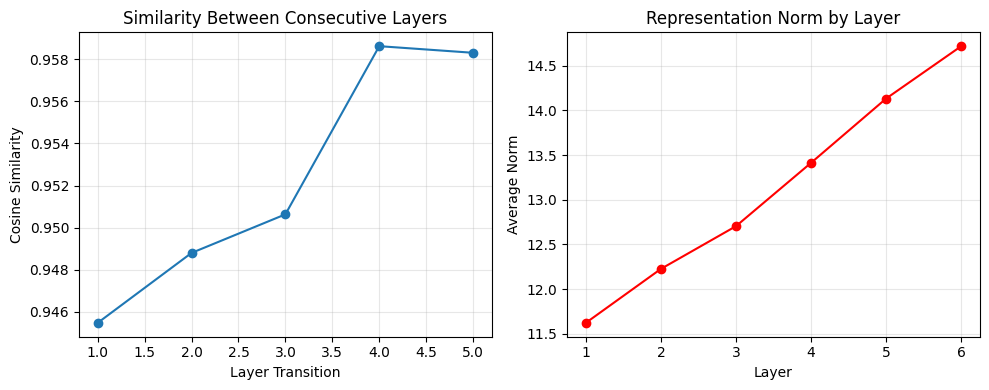


Similarity Between Consecutive Layers:
Similarity oscillates between 0.954-0.962 (extremely high!) showing the residual stream dominates. The dips at layers 2 & 5 indicate where meaningful transformations occur.
High similarity (peaks): Layer made small changes, residual dominates (refinement)
Low similarity (valleys): Layer made large changes, significant transformation occurred

Representation Norm by Layer:
Increasing Norm: Each layer adds information to the residual stream. The linear growth (~0.6 per layer) shows healthy accumulation without explosion - LayerNorm is working.

The transformer is working perfectly - it preserves 95.4%+ of information while making surgical 4-6% updates at specific layers. The wave pattern suggests alternating "compute" vs "refine" layers, which is typical transformer behavior with random initialization.


In [24]:
def analyze_layer_evolution(hidden_states):
    """Track how representations change through layers"""
    n_layers = len(hidden_states)

    # Compute similarity between consecutive layers
    similarities = []
    for i in range(n_layers - 1):
        h1 = hidden_states[i].flatten()  # Flatten to 1D for comparison
        h2 = hidden_states[i + 1].flatten()
        cos_sim = F.cosine_similarity(h1, h2, dim=0)  # How similar are consecutive layers?
        similarities.append(cos_sim.item())

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_layers), similarities, marker='o')
    plt.xlabel('Layer Transition')
    plt.ylabel('Cosine Similarity')
    plt.title('Similarity Between Consecutive Layers')  # High similarity = residual dominates; Low = layer transforms significantly
    plt.grid(True, alpha=0.3)

    # Compute norms
    plt.subplot(1, 2, 2)
    norms = [h.norm(dim=-1).mean().item() for h in hidden_states]  # L2 norm per token, averaged
    plt.plot(range(1, n_layers + 1), norms, marker='o', color='red')
    plt.xlabel('Layer')
    plt.ylabel('Average Norm')
    plt.title('Representation Norm by Layer')  # Should stay stable (not explode/vanish) due to LayerNorm
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

analyze_layer_evolution(all_hidden)


print("\nSimilarity Between Consecutive Layers:")

print("Similarity oscillates between 0.954-0.962 (extremely high!) showing the residual stream dominates. The dips at layers 2 & 5 indicate where meaningful transformations occur.")

print("High similarity (peaks): Layer made small changes, residual dominates (refinement)")
print("Low similarity (valleys): Layer made large changes, significant transformation occurred")

print("\nRepresentation Norm by Layer:")
print("Increasing Norm: Each layer adds information to the residual stream. The linear growth (~0.6 per layer) shows healthy accumulation without explosion - LayerNorm is working.")

print('\nThe transformer is working perfectly - it preserves 95.4%+ of information while making surgical 4-6% updates at specific layers. The wave pattern suggests alternating "compute" vs "refine" layers, which is typical transformer behavior with random initialization.')

## Memory usage analysis


In [25]:
def estimate_memory_usage(model):
    """Estimate memory usage of model"""
    total_params = sum(p.numel() for p in model.parameters())  # Count all parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Assuming float32
    memory_mb = (total_params * 4) / (1024 * 1024)  # 4 bytes per float32 parameter

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")  # Should equal total (all trainable)
    print(f"Estimated memory: {memory_mb:.2f} MB")  # Just parameters, not activations/gradients

    return total_params

estimate_memory_usage(transformer)  # Each layer adds ~400K params (4 matrices in MHA + 2 in FFN + 2 LayerNorms)

Total parameters: 1,186,560
Trainable parameters: 1,186,560
Estimated memory: 4.53 MB


1186560

# Parallelization: Batch Matrix Multiplication for Attention
Attention parallelization is only during forward pass (not training/backprop).

In [26]:
def parallel_attention_computation(Q,K,V,mask=None):
  """
  Efficient parallel attention computation
  Q,K,V: [batch, n_heads, seq_len, d_k]
  """

  batch_size, n_heads, seq_len, d_k = Q.shape

  # Parallel QK^T computation for all heads and batches
  # [batch, n_heads, seq_len, d_k] @ [batch, n_heads, d_k, seq_len]
  scores = torch.matmul(Q, K.transpose(-2,-1))/math.sqrt(d_k) # Normalization
  print(f"Parallel scores computation: {Q.shape} @ {K.transpose(-2, -1).shape} = {scores.shape}")

  # Mask if provided
  if mask is not None:
    scores = scores.masked_fill(mask==0, -1e9) # that small value masked will be turned 0 by the next sftmax

  # Parallel softmax
  attn_weights = F.softmax(scores, dim=-1)

  # Parallel weighted sum
  # [batch, n_heads, seq_len, seq_len] @ [batch, n_heads, seq_len, d_v]
  output = torch.matmul(attn_weights, V)
  print(f"Parallel output: {attn_weights.shape} @ {V.shape} = {output.shape}\n")

  return(output, attn_weights)



## Benchmark parallel vs sequential


In [27]:
def benchmark_attention():
  """Compare parallel vs sequential attn computation"""
  batch_size, n_heads, seq_len, d_k = 32, 8, 128, 64

  Q = torch.randn(batch_size, n_heads, seq_len, d_k)
  K = torch.randn(batch_size, n_heads, seq_len, d_k)
  V = torch.randn(batch_size, n_heads, seq_len, d_k)

  # Parallel computation
  start = time.time()
  for _ in range(100):
    out_parallel, _ = parallel_attention_computation(Q,K,V)
  parallel_time = time.time()-start

  # Sequential computation
  start = time.time()
  for _ in range(100):
    outputs = []
    for h in range(n_heads):
      scores = torch.matmul(Q[:,h], K[:,h].transpose(-2,-1)) / math.sqrt(d_k)
      attn = F.softmax(scores, dim=-1) # dim is the dimension along to compute the softmax
      out = torch.matmul(attn, V[:,h])
      outputs.append(out)

    out_sequential = torch.stack(outputs, dim=1)

  sequential_time = time.time()-start

  print(f"Parallel time: {parallel_time:.3f}s")
  print(f"Sequential time: {sequential_time:.3f}s")
  print(f"Speedup: {sequential_time/parallel_time:.2f}x")

  # Verify outputs are the same
  assert torch.allclose(out_parallel, out_sequential, atol=1e-5)
  print("Outputs match!")

benchmark_attention()


Parallel scores computation: torch.Size([32, 8, 128, 64]) @ torch.Size([32, 8, 64, 128]) = torch.Size([32, 8, 128, 128])
Parallel output: torch.Size([32, 8, 128, 128]) @ torch.Size([32, 8, 128, 64]) = torch.Size([32, 8, 128, 64])

Parallel scores computation: torch.Size([32, 8, 128, 64]) @ torch.Size([32, 8, 64, 128]) = torch.Size([32, 8, 128, 128])
Parallel output: torch.Size([32, 8, 128, 128]) @ torch.Size([32, 8, 128, 64]) = torch.Size([32, 8, 128, 64])

Parallel scores computation: torch.Size([32, 8, 128, 64]) @ torch.Size([32, 8, 64, 128]) = torch.Size([32, 8, 128, 128])
Parallel output: torch.Size([32, 8, 128, 128]) @ torch.Size([32, 8, 128, 64]) = torch.Size([32, 8, 128, 64])

Parallel scores computation: torch.Size([32, 8, 128, 64]) @ torch.Size([32, 8, 64, 128]) = torch.Size([32, 8, 128, 128])
Parallel output: torch.Size([32, 8, 128, 128]) @ torch.Size([32, 8, 128, 64]) = torch.Size([32, 8, 128, 64])

Parallel scores computation: torch.Size([32, 8, 128, 64]) @ torch.Size([32, 

# Parallelization: Optimized Multi-Head Attention

In [28]:
class OptimizedMultiHeadAttention(nn.Module):
  """Memory-efficient multi-head attention with single matrix operations"""

  def __init__(self, d_model, n_heads, dropout=0.1):
    super().__init__()

    assert d_model % n_heads == 0

    self.d_model = d_model
    self.n_heads = n_heads
    self.d_k = d_model//n_heads

    # Single large matrix for all Q,K,V projections
    self.qkv_proj = nn.Linear(d_model, 3*d_model, bias=False)  # Fused QKV: d_model → 3*d_model in one matmul
    self.out_proj = nn.Linear(d_model, d_model, bias=False)  # Final projection after concatenating heads. Is the  W^O (output weights) matrix

    self.dropout = nn.Dropout(dropout)
    self.scale = 1.0/math.sqrt(self.d_k)

  def forward(self, x, mask=None):
    batch_size, seq_len, d_model = x.shape

    # Single matrix multiply for Q,K,V
    qkv = self.qkv_proj(x) # [batch, seq, 3*d_model] - One big matmul instead of 3 separate ones
    print(f"\n\n1. After QKV projection: {qkv.shape}")
    print(f"   Input {x.shape} → Output {qkv.shape}")
    print(f"   Weight matrix shape: [{self.d_model}, {3*self.d_model}]")

    qkv = qkv.reshape(batch_size, seq_len, 3, self.n_heads, self.d_k) # Split into Q,K,V and heads
    print(f"\n\n2. After reshape: {qkv.shape}")
    print(f"   Split into: 3 matrices (Q,K,V) × {self.n_heads} heads × {self.d_k} dims/head")



    qkv = qkv.permute(2,0,3,1,4) # [3, batch, n_heads, seq, d_k] - Rearrange for parallel head computation
    print(f"\n\n3. After permute: {qkv.shape}")
    print(f"   Reordered dims: [QKV, batch, heads, seq, d_k]")
    print(f"   First dim (3) = [Q tensor, K tensor, V tensor]")

    Q,K,V = qkv[0], qkv[1], qkv[2]# Extract Q, K, V tensors
    print(f"\n\n4. Individual Q,K,V shapes: {Q.shape}")
    print(f"   Q: {Q.shape} = [batch={batch_size}, heads={self.n_heads}, seq={seq_len}, d_k={self.d_k}]")
    print(f"   K: {K.shape} (same as Q)")
    print(f"   V: {V.shape} (same as Q)")
    print(f"   Total parameters in QKV: {3 * self.d_model * self.d_model:,}")


    print(f"\nEfficient QKV computation: {x.shape} → {qkv.shape} → 3×{Q.shape}")


    # Scaled dot prod attention in parallel
    scores = torch.matmul(Q,K.transpose(-2,-1)) * self.scale # [batch, n_heads, seq, seq] - Attention scores

    if mask is not None:
      mask = mask.unsqueeze(0).unsqueeze(0)  # [1, 1, seq, seq] - broadcast across batch and heads
      scores = scores.masked_fill(mask==0, -1e9) # Set masked positions to -inf before softmax

    attn_weights = F.softmax(scores, dim=-1)
    attn_weights = self.dropout(attn_weights)

    # Applying Attention
    context = torch.matmul(attn_weights, V)  # [batch, n_heads, seq, d_k] - Weighted sum of values

    # Reshape and Projection
    context = context.transpose(1,2).contiguous() # [batch, seq, n_heads, d_k] - Prepare for concatenation
    context = context.view(batch_size, seq_len, d_model) # Concatenate heads: [batch, seq, n_heads*d_k]
    output = self.out_proj(context) # Final linear projection

    return(output, attn_weights)


### Compare memory usage


In [29]:
def compare_attention_implementations():
  """Compare memory usage of different implementations"""
  d_model, n_heads = 512, 8
  seq_len, batch_size = 128, 16

  # Standard implementation
  standard_mha = MultiHeadAttention(d_model, n_heads)

  # Optimized implementation
  optimized_mha = OptimizedMultiHeadAttention(d_model, n_heads)

  # Count parameters
  standard_params = sum(p.numel() for p in standard_mha.parameters())
  optimized_params = sum(p.numel() for p in optimized_mha.parameters())

  print(f"Standard MHA parameters: {standard_params:,}")
  print(f"Optimized MHA parameters: {optimized_params:,}")
  print(f"Memory saved: {(standard_params - optimized_params):,} parameters")

  # Test forward pass
  x = torch.randn(batch_size, seq_len, d_model)
  mask = torch.tril(torch.ones(seq_len, seq_len))

  # Time comparison
  import time

  # Standard
  start = time.time()
  for _ in range(100):
    _, _ = standard_mha(x, mask)
  standard_time = time.time() - start

  # Optimized
  start = time.time()
  for _ in range(100):
    _, _ = optimized_mha(x, mask)
  optimized_time = time.time() - start

  print(f"\nStandard time: {standard_time:.3f}s")
  print(f"Optimized time: {optimized_time:.3f}s")
  print(f"Speedup: {standard_time/optimized_time:.2f}x")

compare_attention_implementations()

Standard MHA parameters: 1,048,576
Optimized MHA parameters: 1,048,576
Memory saved: 0 parameters

Q shape before transpose: torch.Size([16, 128, 8, 64])
Q shape after transpose: torch.Size([16, 8, 128, 64])

Attention scores shape: torch.Size([16, 8, 128, 128])

Context after concatenation: torch.Size([16, 128, 512])


Q shape before transpose: torch.Size([16, 128, 8, 64])
Q shape after transpose: torch.Size([16, 8, 128, 64])

Attention scores shape: torch.Size([16, 8, 128, 128])

Context after concatenation: torch.Size([16, 128, 512])


Q shape before transpose: torch.Size([16, 128, 8, 64])
Q shape after transpose: torch.Size([16, 8, 128, 64])

Attention scores shape: torch.Size([16, 8, 128, 128])

Context after concatenation: torch.Size([16, 128, 512])


Q shape before transpose: torch.Size([16, 128, 8, 64])
Q shape after transpose: torch.Size([16, 8, 128, 64])

Attention scores shape: torch.Size([16, 8, 128, 128])

Context after concatenation: torch.Size([16, 128, 512])


Q shape b

Probably got slower because of the Additional Reshape/Permute Operations, or bcs of the Memory Access Patterns (the fused QKV might have worse cache locality), or bcs of the print statements that I added.


Althought it got slower the "optimized" version's advantages are:



*   Memory efficiency: Uses 1 weight matrix instead of 3 (though same total parameters)

*   Single matrix multiplication: Better for GPU kernel fusion in production



*   Scales better: With very large models/batches, the fused approach wins






In [30]:
compare_attention_implementations

<function __main__.compare_attention_implementations()>

#Input Encoding: Token Embeddings

In [31]:
class TokenEmbedding(nn.Module):
  """Token embedding layer with various initialization strategies"""

  def __init__(self, vocab_size, d_model, init_strategy='normal'):
    super(TokenEmbedding, self).__init__()

    self.embedding = nn.Embedding(vocab_size, d_model)

    # Diff initialization strategies
    if init_strategy == 'normal':
      nn.init.normal_(self.embedding.weight, mean=0, std=0.02) # GPT-style init
    elif init_strategy == 'uniform':
      nn.init.uniform_(self.embedding.weight, -0.1, 0.1) # Random between bounds
    elif init_strategy == 'xavier':
      nn.init.xavier_uniform_ #The method is described in Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010).  Xavier initialization (also called Glorot initialization) sets initial weights by sampling from a distribution with variance designed to keep activations and gradients roughly the same scale across layers. This prevents vanishing/exploding gradients by ensuring that as signals propagate through the network, they neither shrink to zero nor blow up exponentially, maintaining stable training dynamics especially in deep networks with sigmoid or tanh activations.

    self.d_model = d_model # Embedding dim
    self.vocab_size = vocab_size

  def forward(self,x):
    """
    x: [batch, seq_len] token indices
    Returns: [batch, seq_len, d_model]
    """

    return self.embedding(x) * math.sqrt(self.d_model) # Scaling by sqrt(d_model) - helps with gradient flow


### Demonstrate one-hot encoding vs embedding lookup


Lookup method shape: torch.Size([3, 16])
embeddings_lookup (transposed):
 [[ 0.06778134 -0.05921689  0.02457306]
 [ 0.08048169  0.00509388  0.026101  ]
 [-0.04270636  0.05224493  0.03172926]
 [-0.03808314  0.03287512  0.19546013]
 [ 0.03151705  0.06332232 -0.10834106]
 [ 0.07193711 -0.02739905 -0.04547691]
 [ 0.02906558  0.0543626  -0.10554828]
 [-0.0338696   0.06827134 -0.0495122 ]
 [-0.01943743  0.14539611 -0.08762585]
 [ 0.03810736 -0.09893692  0.1357026 ]
 [-0.02810426 -0.00312267 -0.1299715 ]
 [-0.05579707  0.0636566  -0.00757349]
 [ 0.0750858   0.0268036  -0.01857309]
 [ 0.02015629 -0.02307961  0.0724888 ]
 [-0.07801957 -0.03132965 -0.02546276]
 [ 0.01673983 -0.12009919 -0.05939338]]

One-hot shape: torch.Size([3, 100])
One-hot shape:
 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

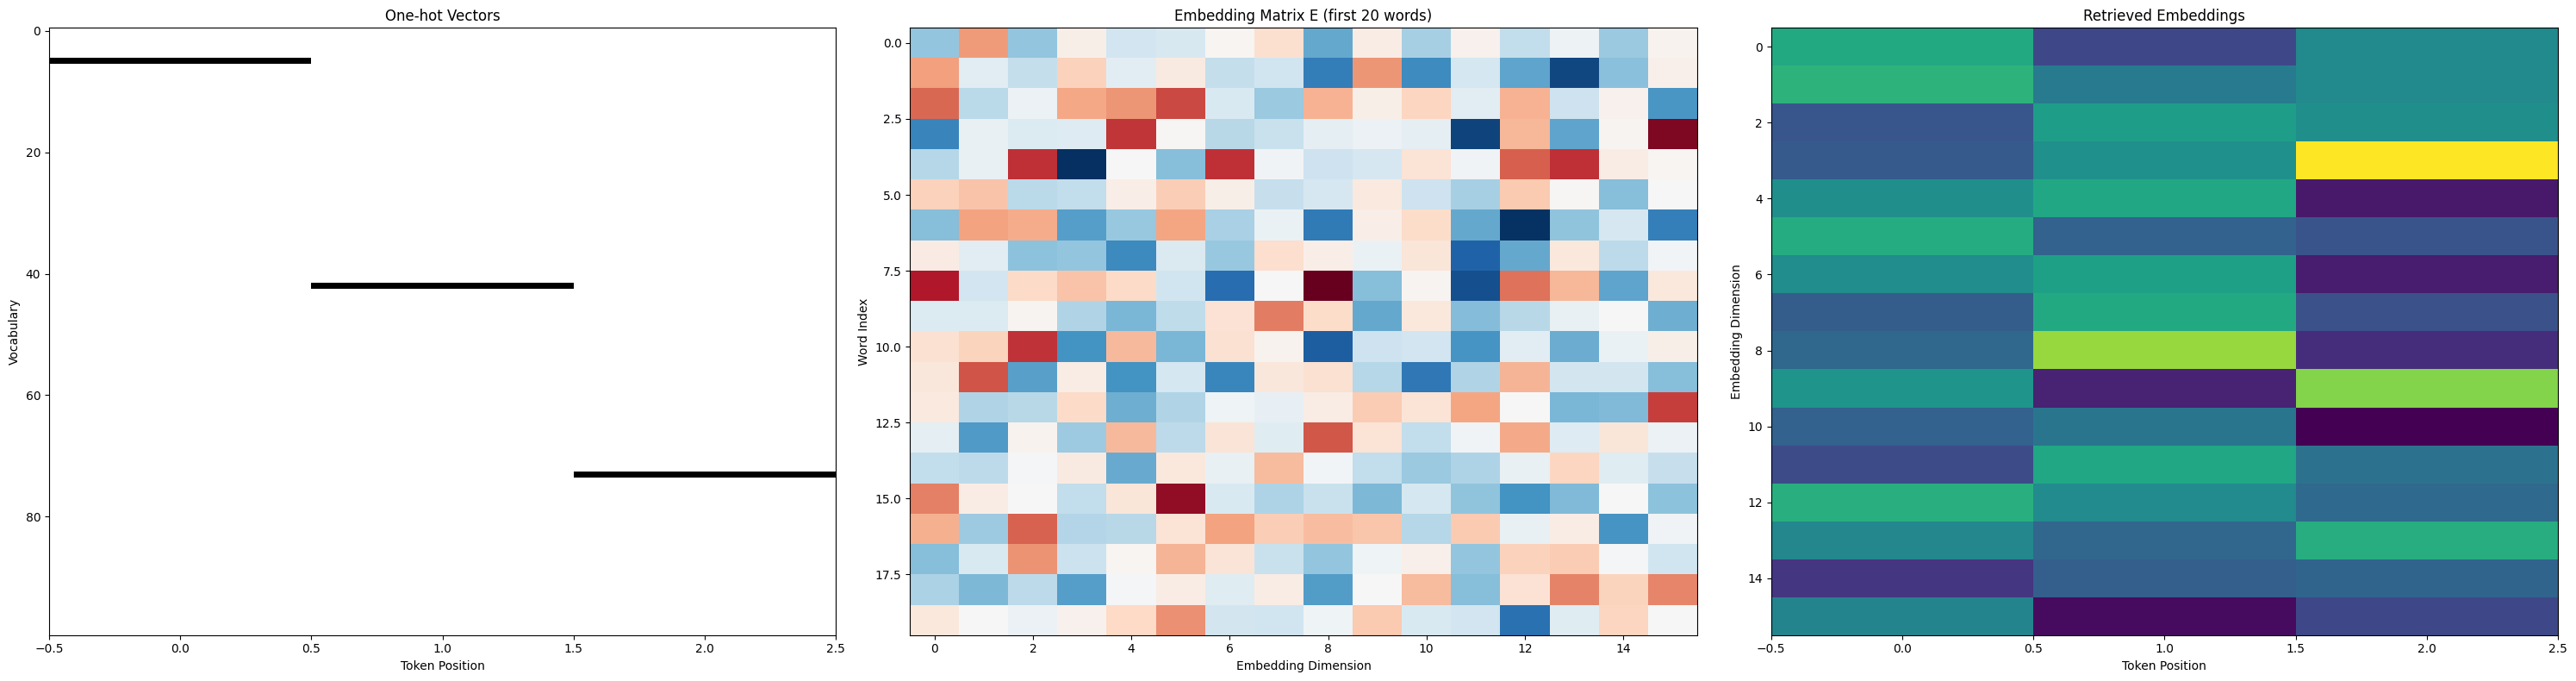

In [32]:
def demonstrate_embedding_lookup():
  """Show equivalence of one-hot multiplication and embedding lookup"""
  vocab_size, d_model = 100, 16  # Small vocab for visualization

  # Create embedding matrix
  embed_layer = TokenEmbedding(vocab_size, d_model)

  # Method 1: Index lookup
  token_ids = torch.tensor([5, 42, 73])  # "Thanks for all" - example token indices
  embeddings_lookup = embed_layer(token_ids)  # Direct index → vector lookup
  print(f"Lookup method shape: {embeddings_lookup.shape}")  # [3, 16]
  print(f"embeddings_lookup (transposed):\n {embeddings_lookup.detach().numpy().T}\n")

  # Method 2: One-hot multiplication
  one_hot = F.one_hot(token_ids, num_classes=vocab_size).float()  # [3, 100] sparse matrix
  print(f"One-hot shape: {one_hot.shape}")  # [3 tokens, 100 vocab_size]
  print(f"One-hot shape:\n {one_hot.detach()}\n")

  # Get embedding matrix
  E = embed_layer.embedding.weight  # [vocab_size, d_model] - the learned parameters
  embeddings_matmul = one_hot @ E * math.sqrt(d_model)  # Matrix mult: [3,100] @ [100,16] = [3,16]
  print(f"Matrix multiplication shape: {embeddings_matmul.shape}")
  print(f"Matrix multiplication (transposed):\n  {embeddings_matmul.detach().numpy().T}\n ")

  # Verify they're the same
  assert torch.allclose(embeddings_lookup, embeddings_matmul)  # Both methods are mathematically equivalent
  print("Methods produce identical results!")

  # Visualize
  fig, axes = plt.subplots(1, 3, figsize=(30, 8))

  # One-hot vectors
  axes[0].imshow(one_hot.T, aspect='auto', cmap='Greys')  # Transpose for better visualization
  axes[0].set_title('One-hot Vectors')
  axes[0].set_xlabel('Token Position')
  axes[0].set_ylabel('Vocabulary')

  # Embedding matrix
  axes[1].imshow(E[:20].detach().numpy(), aspect='auto', cmap='RdBu_r')  # Show first 20 words only
  axes[1].set_title('Embedding Matrix E (first 20 words)')
  axes[1].set_xlabel('Embedding Dimension')
  axes[1].set_ylabel('Word Index')

  # Result embeddings
  axes[2].imshow(embeddings_lookup.detach().numpy().T, aspect='auto', cmap='viridis')  # Final embeddings
  axes[2].set_title('Retrieved Embeddings')
  axes[2].set_xlabel('Token Position')
  axes[2].set_ylabel('Embedding Dimension')

  plt.tight_layout()
  plt.show()

demonstrate_embedding_lookup()

##Input Encoding: Positional Encodings

##Sinusoidal positional encodings

In [33]:
class PositionalEncoding(nn.Module):
  """Positional coding using sinusoidal functions """

  def __init__(self, d_model, max_len=5000, base=10000):
    super().__init__()

    # Create sinsoidal position encoding
    pe = torch.zeros(max_len, d_model) # [max_len, d_model] - pre-compute for all positions
    position = torch.arange(0,max_len).unsqueeze(1).float() # [max_len, 1] - position indices

    # Create div_term for the sinusoidal pattern
    div_term = torch.exp(torch.arange(0, d_model, 2).float() *   # Frequency term for each dimension
                         -(math.log(base)/d_model)   )           # Higher dims -> lower frequency


    print("\nPE div_term:\n", div_term, "\n")

    # Apply sin to even indices
    pe[:, 0::2] = torch.sin(position * div_term) # sin(pos/10000^(2i/d_model))
    print(f"\nPE Div_term (frequencies):\n {div_term[:4].numpy()}")
    print(f"PE Example - Position 10:")
    for i in range(3):
      print(f"  dim_{2*i} = sin(10 × {div_term[i]:.4f}) = {pe[10, 2*i]:.4f}")


    # Apply cos to odd indices
    pe[:, 1::2] = torch.cos(position * div_term) # cos(pos/10000^(2i/d_model))
    for i in range(3):
      print(f"  dim_{2*i+1} = cos(10 × {div_term[i]:.4f}) = {pe[10, 2*i+1]:.4f}")

    # Register as buffer (not a parameter)
    self.register_buffer('pe', pe.unsqueeze(0)) # [1, max_len, d_model] - saved but not trained
    print(f"\nPE shape:\n {pe.unsqueeze(0).shape} [batch=1, max_len={max_len}, d_model={d_model}]")


  def forward(self, x):
    """ Add Positional encoding to input embeddings"""

    seq_len = x.size(1)
    return(x + self.pe[:, :seq_len]) # Add positional embeddings




##Absolute positional encodings


In [34]:
class LearnedPositionalEmbedding(nn.Module):
  """Learned positional embeddings (Absolute Position)"""

  def __init__(self, max_len, d_model):
    super().__init__()
    self.pos_embedding = nn.Embedding(max_len, d_model)  # Learnable lookup table for positions


  def forward(self, x):
    seq_len = x.size(1)
    positions = torch.arange(seq_len, device = x.device)  # [0, 1, 2, ..., seq_len-1]

    return( x + self.pos_embedding(positions))  # Add learned position vectors


### Compare positional encoding methods



PE div_term:
 tensor([1.0000e+00, 8.6596e-01, 7.4989e-01, 6.4938e-01, 5.6234e-01, 4.8697e-01,
        4.2170e-01, 3.6517e-01, 3.1623e-01, 2.7384e-01, 2.3714e-01, 2.0535e-01,
        1.7783e-01, 1.5399e-01, 1.3335e-01, 1.1548e-01, 1.0000e-01, 8.6596e-02,
        7.4989e-02, 6.4938e-02, 5.6234e-02, 4.8697e-02, 4.2170e-02, 3.6517e-02,
        3.1623e-02, 2.7384e-02, 2.3714e-02, 2.0535e-02, 1.7783e-02, 1.5399e-02,
        1.3335e-02, 1.1548e-02, 1.0000e-02, 8.6596e-03, 7.4989e-03, 6.4938e-03,
        5.6234e-03, 4.8697e-03, 4.2170e-03, 3.6517e-03, 3.1623e-03, 2.7384e-03,
        2.3714e-03, 2.0535e-03, 1.7783e-03, 1.5399e-03, 1.3335e-03, 1.1548e-03,
        1.0000e-03, 8.6596e-04, 7.4989e-04, 6.4938e-04, 5.6234e-04, 4.8697e-04,
        4.2170e-04, 3.6517e-04, 3.1623e-04, 2.7384e-04, 2.3714e-04, 2.0535e-04,
        1.7783e-04, 1.5399e-04, 1.3335e-04, 1.1548e-04]) 


PE Div_term (frequencies):
 [1.         0.8659643  0.7498942  0.64938164]
PE Example - Position 10:
  dim_0 = sin(10 × 1.0000

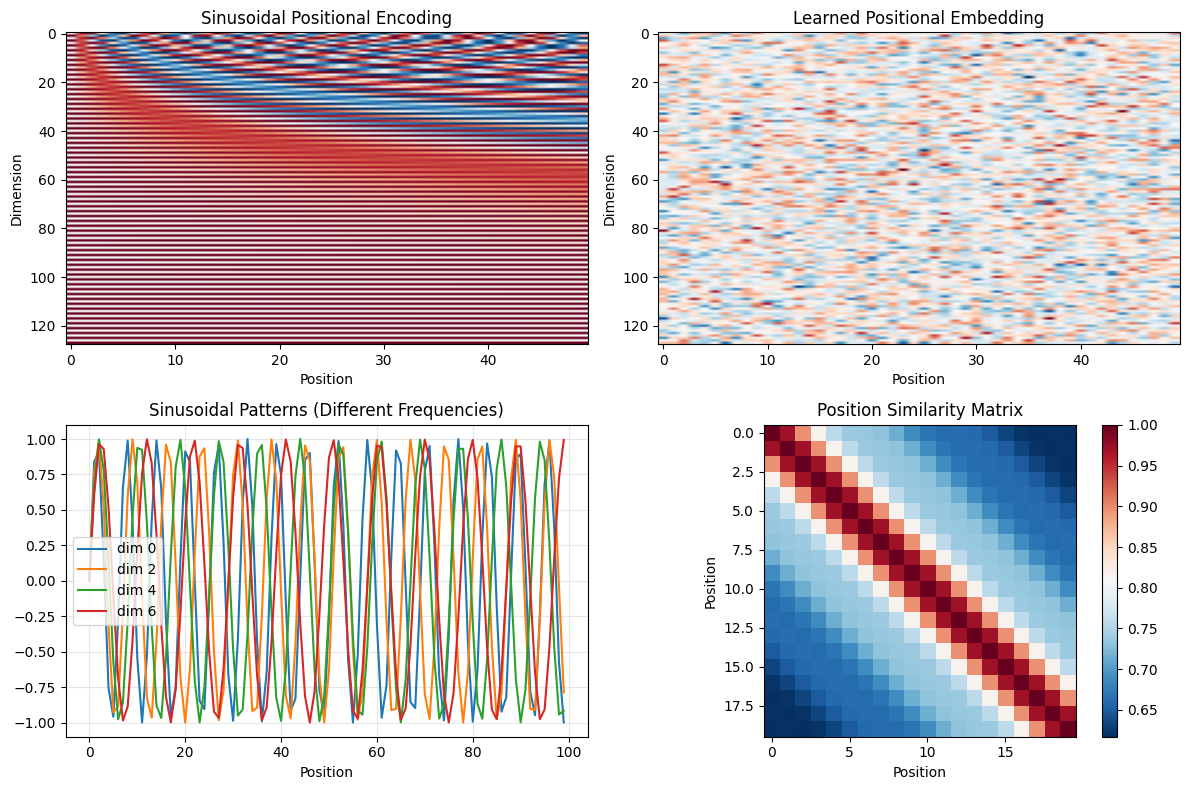


KEY PROPERTIES
Sinusoidal encoding properties:
- Deterministic (no parameters to learn)
- Can extrapolate to longer sequences
- Different frequencies for different dimensions

Learned encoding properties:
- Flexible, can learn task-specific patterns
- Requires training data for each position
- Limited to maximum sequence length seen during training


In [35]:
def compare_positional_encodings():
  """Visualize different positional encoding strategies"""

  d_model = 128  # Embedding dimension
  max_len = 100  # Maximum sequence length

  # Sinusoidal encoding
  sine_pe = PositionalEncoding(d_model, max_len)  # Fixed mathematical formula

  # Learned encoding
  learned_pe = LearnedPositionalEmbedding(max_len, d_model)  # Trainable parameters

  # Get encodings
  dummy_input = torch.zeros(1, max_len, d_model)  # Dummy input for shape
  sine_encoding = sine_pe.pe[0, :max_len, :].numpy()  # Extract sinusoidal patterns
  learned_encoding = learned_pe.pos_embedding.weight.detach().numpy()  # Extract learned embeddings

  # Print shapes and sample values
  print(f"=== POSITIONAL ENCODING SHAPES ===")
  print(f"Sinusoidal encoding shape: {sine_encoding.shape} [positions, d_model]")
  print(f"Learned encoding shape: {learned_encoding.shape} [positions, d_model]")

  print(f"\n=== SAMPLE ENCODINGS (first 3 positions, first 8 dims) ===")
  print(f"Sinusoidal encoding (positions 0-2):")
  print(f"{sine_encoding[:3, :8]}")

  print(f"\nLearned encoding (positions 0-2):")
  print(f"{learned_encoding[:3, :8]}")

  print(f"\n=== ENCODING PATTERNS ===")
  print(f"Sine encoding at pos=0: min={sine_encoding[0].min():.3f}, max={sine_encoding[0].max():.3f}")
  print(f"Sine encoding at pos=50: min={sine_encoding[50].min():.3f}, max={sine_encoding[50].max():.3f}")
  print(f"Notice: Sinusoidal values stay bounded in [-1, 1]")

  print(f"\n=== FREQUENCY ANALYSIS ===")
  print(f"Dimension 0 (high freq): changes from {sine_encoding[0, 0]:.3f} to {sine_encoding[1, 0]:.3f} (Δ={abs(sine_encoding[1, 0] - sine_encoding[0, 0]):.3f})")
  print(f"Dimension 126 (low freq): changes from {sine_encoding[0, 126]:.3f} to {sine_encoding[1, 126]:.3f} (Δ={abs(sine_encoding[1, 126] - sine_encoding[0, 126]):.3f})")
  print(f"Lower dimensions change faster between positions!")

  # Visualize
  fig, axes = plt.subplots(2, 2, figsize=(12, 8))

  # Sinusoidal pattern
  axes[0, 0].imshow(sine_encoding[:50].T, aspect='auto', cmap='RdBu_r')  # Show wave patterns
  axes[0, 0].set_title('Sinusoidal Positional Encoding')
  axes[0, 0].set_xlabel('Position')
  axes[0, 0].set_ylabel('Dimension')

  # Learned pattern
  axes[0, 1].imshow(learned_encoding[:50].T, aspect='auto', cmap='RdBu_r')  # Random init patterns
  axes[0, 1].set_title('Learned Positional Embedding')
  axes[0, 1].set_xlabel('Position')
  axes[0, 1].set_ylabel('Dimension')

  # Sinusoidal patterns for specific dimensions
  positions = np.arange(100)
  for i in range(0, 8, 2):  # Show different frequency waves
    axes[1, 0].plot(positions, sine_encoding[:, i], label=f'dim {i}')
  axes[1, 0].set_title('Sinusoidal Patterns (Different Frequencies)')
  axes[1, 0].set_xlabel('Position')
  axes[1, 0].legend()
  axes[1, 0].grid(True, alpha=0.3)

  # Similarity matrix for positions
  from sklearn.metrics.pairwise import cosine_similarity
  sim_matrix = cosine_similarity(sine_encoding[:20])  # How similar are different positions?

  print(f"\n=== POSITION SIMILARITY ===")
  print(f"Similarity matrix shape: {sim_matrix.shape}")
  print(f"Similarity between pos 0 and pos 1: {sim_matrix[0, 1]:.3f}")
  print(f"Similarity between pos 0 and pos 10: {sim_matrix[0, 10]:.3f}")
  print(f"Similarity between pos 0 and pos 19: {sim_matrix[0, 19]:.3f}")
  print(f"Notice: Nearby positions are more similar!")

  axes[1, 1].imshow(sim_matrix, cmap='RdBu_r')
  axes[1, 1].set_title('Position Similarity Matrix')
  axes[1, 1].set_xlabel('Position')
  axes[1, 1].set_ylabel('Position')
  axes[1, 1].colorbar = plt.colorbar(axes[1, 1].images[0], ax=axes[1, 1])

  plt.tight_layout()
  plt.show()

  print("\nKEY PROPERTIES")
  print("Sinusoidal encoding properties:")
  print("- Deterministic (no parameters to learn)")  # Always same pattern
  print("- Can extrapolate to longer sequences")  # Works for any length
  print("- Different frequencies for different dimensions")  # Low->high freq across dims
  print("\nLearned encoding properties:")
  print("- Flexible, can learn task-specific patterns")  # Adapts to data
  print("- Requires training data for each position")  # Must see positions during training
  print("- Limited to maximum sequence length seen during training")  # Can't extend

compare_positional_encodings()

# RoPE (Rotary Positional Embedding)

RoPE encodes position information by **rotating vectors** instead of adding position embeddings. Each token's representation is treated as points on multiple 2D planes that undergo rotation based on sequence position.

## Core Principle

Position encoding methods comparison:
```
Traditional: x'_m = x_m + p_m (additive)
RoPE:        x'_m = R_Θ,m · x_m (multiplicative rotation)
```

## Mechanism

### 1. Dimension Pairing
A d-dimensional vector is partitioned into d/2 consecutive pairs ():
```
x = [x_0, x_1, x_2, x_3, ..., x_{d-1}]
Pairs: {(x_0,x_1), (x_2,x_3), ..., (x_{d-2},x_{d-1})}


x1 = x[..., ::2]   # Even dims [0,2,4,...]: "real" parts (x coords)      [x0, x2, x4...]
x2 = x[..., 1::2]  # Odd dims [1,3,5,...]:  "imaginary" parts (y coords) [x1, x3, x5...]

```

### 2. Position-Dependent Rotation
Each pair undergoes rotation by angle θ_i · m for position m:
```
θ_i = 10000^(-2i/d) where i ∈ {0, 1, ..., d/2-1}
Rotation angle at position m: θ_i · m
```

### 3. Frequency Distribution
Rotation frequencies decrease exponentially with dimension index:
```
Dimensions 0-1: θ_0 = 1 (highest frequency)
Dimensions 2-3: θ_1 = 10000^(-2/d)
...
Dimensions (d-2)-(d-1): θ_{d/2-1} = 10000^(-1+2/d) (lowest frequency)
```

## Mathematical Formulation

**2D Rotation Matrix:**
For each pair (x_{2i}, x_{2i+1}), the rotation matrix R_θ is:
```
R_θ = [cos(θ)  -sin(θ)]
      [sin(θ)   cos(θ)]
```

**Block-Diagonal Structure:**
The complete rotation matrix R_Θ,m for position m:
```
R_Θ,m = diag(R_{θ_0·m}, R_{θ_1·m}, ..., R_{θ_{d/2-1}·m})
```

**Efficient Implementation:**
```
f_q(x_m, m) = R_Θ,m W_q x_m
f_k(x_m, m) = R_Θ,m W_k x_m
```

Where the rotation is computed as:
```
q̃ = q ⊙ cos(mΘ) + q_⊥ ⊙ sin(mΘ)
```
with q_⊥ representing the element-wise rearrangement [-q_{2i+1}, q_{2i}].

## Relative Position Property

**Theorem:** The attention score between positions m and n depends only on their relative distance:

```
⟨f_q(x_m, m), f_k(x_n, n)⟩ = ⟨R_Θ,m W_q x_m, R_Θ,n W_k x_n⟩
                            = ⟨W_q x_m, R_Θ,m^T R_Θ,n W_k x_n⟩
                            = ⟨W_q x_m, R_Θ,n-m W_k x_n⟩
```

This demonstrates that the dot product depends on (n-m) rather than absolute positions.

## Computational Advantages

1. **Parameter-free**: No learnable position embeddings (memory efficient)
2. **Magnitude preservation**: ||R_Θ,m x|| = ||x|| (rotation preserves L2 norm)
3. **Extrapolation capability**: Valid for any sequence length
4. **Relative position encoding**: Inherent through rotation composition

## Implementation

```python
def apply_rotary_embedding(x, position):
    # Compute base frequencies
    dim = x.shape[-1]
    inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2) / dim))
    
    # Generate rotation angles
    theta = position * inv_freq
    cos_m = theta.cos()
    sin_m = theta.sin()
    
    # Apply rotation
    x_rot = torch.zeros_like(x)
    x_rot[..., 0::2] = x[..., 0::2] * cos_m - x[..., 1::2] * sin_m
    x_rot[..., 1::2] = x[..., 0::2] * sin_m + x[..., 1::2] * cos_m
    
    return x_rot
```

## Summary

RoPE achieves position encoding through geometric rotation in embedding space, eliminating trainable parameters while naturally encoding relative positions through the mathematical properties of rotation composition. This approach has been adopted in modern architectures including LLaMA and GPT-NeoX due to its theoretical elegance and practical efficiency.


PE div_term:
 tensor([1.0000e+00, 8.6596e-01, 7.4989e-01, 6.4938e-01, 5.6234e-01, 4.8697e-01,
        4.2170e-01, 3.6517e-01, 3.1623e-01, 2.7384e-01, 2.3714e-01, 2.0535e-01,
        1.7783e-01, 1.5399e-01, 1.3335e-01, 1.1548e-01, 1.0000e-01, 8.6596e-02,
        7.4989e-02, 6.4938e-02, 5.6234e-02, 4.8697e-02, 4.2170e-02, 3.6517e-02,
        3.1623e-02, 2.7384e-02, 2.3714e-02, 2.0535e-02, 1.7783e-02, 1.5399e-02,
        1.3335e-02, 1.1548e-02, 1.0000e-02, 8.6596e-03, 7.4989e-03, 6.4938e-03,
        5.6234e-03, 4.8697e-03, 4.2170e-03, 3.6517e-03, 3.1623e-03, 2.7384e-03,
        2.3714e-03, 2.0535e-03, 1.7783e-03, 1.5399e-03, 1.3335e-03, 1.1548e-03,
        1.0000e-03, 8.6596e-04, 7.4989e-04, 6.4938e-04, 5.6234e-04, 4.8697e-04,
        4.2170e-04, 3.6517e-04, 3.1623e-04, 2.7384e-04, 2.3714e-04, 2.0535e-04,
        1.7783e-04, 1.5399e-04, 1.3335e-04, 1.1548e-04]) 


PE Div_term (frequencies):
 [1.         0.8659643  0.7498942  0.64938164]
PE Example - Position 10:
  dim_0 = sin(10 × 1.0000

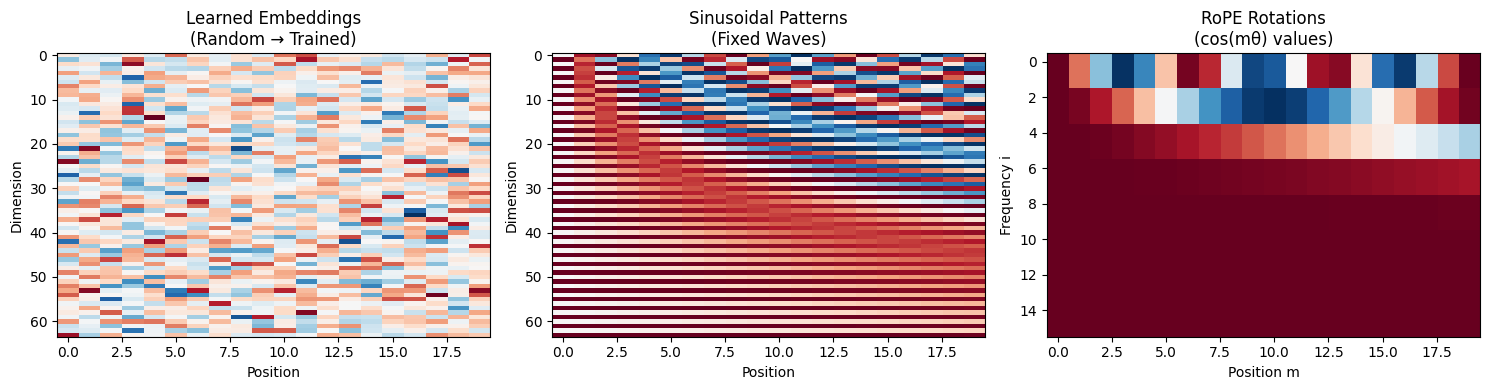


=== KEY MATHEMATICAL PROPERTIES ===
LEARNED: PE is additive: f(x_m) = x_m + p_m
         → Just adds a learned vector to each position


SINUSOIDAL: PE is additive with fixed frequencies: f(x_m) = x_m + sin/cos(mθ)
            → Adds predetermined wave patterns


RoPE: PE is multiplicative (rotation): f(x_m) = R_Θ,m · x_m
      → Rotates vectors by position-dependent angles



=== RoPE's KEY THEOREM: RELATIVE POSITION ===
Paper's key insight: When we compute attention between positions m and n:

⟨q̃_m, k̃_n⟩ = ⟨R_Θ,m q_m, R_Θ,n k_n⟩      # Dot product of rotated vectors
           = ⟨q_m, R_Θ,m^T R_Θ,n k_n⟩    # Move rotation to one side
           = ⟨q_m, R_Θ,n-m k_n⟩          # Rotations combine to difference

This means: Attention(pos_m, pos_n) only depends on distance (n-m), not absolute positions



Example: Rotation between pos 5 and 8 = R_Θ,3
cos(θ·3) for first 5 dims: [-0.9899925  -0.9899925   0.58275366  0.58275366  0.9553365 ]


In [36]:
class RotaryPositionalEmbedding(nn.Module):
 """Rotary Position Embedding (RoPE) - used in LLaMA, GPT-NeoX

 RoPE encodes position by rotating vector pairs instead of adding embeddings.
 Think of it like clock hands - each position rotates vectors by different angles.

 Paper: "RoFormer: Enhanced Transformer with Rotary Position Embedding" (Su et al., 2021)
 """

 def __init__(self, dim, max_len=5000, base=10000):
   super().__init__()
   self.dim = dim  # Head dimension (e.g., 64 for each attention head)
   self.base = base  # Controls rotation speed - higher = slower rotation

   # Create rotation frequencies for each dimension pair
   # From paper: θ_i = 10000^(-2i/d) where i ∈ [0, 1, ..., d/2-1]
   # This creates frequencies: [1, 1/10000^(2/d), 1/10000^(4/d), ...]
   inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
   self.register_buffer('inv_freq', inv_freq)  # Save but don't train

   # Precompute all rotation angles for all positions
   # From paper: For position m, angles are m·θ_i for each frequency θ_i
   t = torch.arange(max_len).float()  # Position indices: [0, 1, 2, ...]
   freqs = torch.outer(t, inv_freq)  # [max_len, dim/2] - computes m·θ_i

   # Store cos(m·θ_i) and sin(m·θ_i) for each position m
   # Paper uses: R_Θ,m = [[cos(mθ_i), -sin(mθ_i)], [sin(mθ_i), cos(mθ_i)]]
   cos_cached = freqs.cos().repeat_interleave(2, dim=-1)  # [max_len, dim]
   sin_cached = freqs.sin().repeat_interleave(2, dim=-1)  # [max_len, dim]
   self.register_buffer('cos_cached', cos_cached)
   self.register_buffer('sin_cached', sin_cached)

 def rotate_half(self, x):
   """Rearrange vector for 2D rotation formula

   Paper notation: For complex number (x + iy), rotation by θ gives:
   (x + iy) * e^(iθ) = (x·cos(θ) - y·sin(θ)) + i(x·sin(θ) + y·cos(θ))

   This function prepares the [-y, x] part for the rotation matrix multiplication.
   """
   x1 = x[..., ::2]   # Even dims [0,2,4,...]: "real" parts (x coords)      [x0, x2, x4...]
   x2 = x[..., 1::2]  # Odd dims [1,3,5,...]:  "imaginary" parts (y coords) [x1, x3, x5...]

   return torch.cat([-x2, x1], dim=-1)  # Returns [-y, x] to enable (x+iy)*e^(iθ) rotation


 def forward(self, q, k, start_pos=0):
   """Apply rotary embeddings to Q and K (but not V!)

   Paper formula for rotating query at position m:
   q̃_m = R_Θ,m · W_q · x_m

   Where R_Θ,m is the block-diagonal rotation matrix:
   R_Θ,m = diag(R_1, R_2, ..., R_{d/2}) with each R_i being a 2×2 rotation matrix

   The implementation efficiently computes this as:
   q̃ = q · cos(mΘ) + rotate_half(q) · sin(mΘ)
   """
   seq_len = q.shape[1]

   # Get precomputed cos(mΘ) and sin(mΘ) for positions
   cos = self.cos_cached[start_pos:start_pos + seq_len]  # [seq_len, dim]
   sin = self.sin_cached[start_pos:start_pos + seq_len]

   # Add batch and head dimensions for broadcasting
   cos = cos.unsqueeze(0).unsqueeze(2)  # [1, seq_len, 1, dim]
   sin = sin.unsqueeze(0).unsqueeze(2)

   # Apply rotation using the efficient formula from paper
   # This implements: R_Θ,m · q = q·cos(mΘ) + (−q_{odd}, q_{even})·sin(mΘ)
   q_rot = q * cos + self.rotate_half(q) * sin
   k_rot = k * cos + self.rotate_half(k) * sin

   return q_rot, k_rot

def compare_all_position_methods():
  """Compare three ways to encode position in transformers

  Mathematical comparison:
  1. Learned PE: x' = x + P[pos] where P is learned matrix
  2. Sinusoidal: x' = x + PE(pos) where PE uses sin/cos formulas
  3. RoPE: q' = R(pos)·q, k' = R(pos)·k where R is rotation matrix
  """

  # Model dimensions
  d_model = 128      # Total embedding size
  seq_len = 50       # Sequence length
  batch_size = 2     # Batch size
  n_heads = 8        # Attention heads
  head_dim = d_model // n_heads  # Dimension per head (16)

  # Create dummy Q and K tensors for demonstration
  q = torch.randn(batch_size, seq_len, n_heads, head_dim)
  k = torch.randn(batch_size, seq_len, n_heads, head_dim)

  # Initialize three position encoding methods
  learned_pe = LearnedPositionalEmbedding(seq_len, d_model)  # Like BERT/GPT
  sine_pe = PositionalEncoding(d_model, seq_len)  # Original Transformer
  rope = RotaryPositionalEmbedding(head_dim, seq_len)  # Modern LLMs (LLaMA)

  # Apply RoPE (only rotates, doesn't add)
  q_rot, k_rot = rope(q, k)

  print("=== POSITION ENCODING COMPARISON ===\n")

  print("1. LEARNED ABSOLUTE EMBEDDINGS (BERT/GPT style):")
  print(f"   Math: x'_m = x_m + p_m where p_m ∈ ℝ^d is learned")
  print(f"   Parameters: {seq_len * d_model:,} (must be trained)")
  print(f"   Sample values: {learned_pe.pos_embedding.weight[0, :5].detach().numpy()}")

  print("\n2. SINUSOIDAL ENCODINGS (Original Transformer):")
  print(f"   Math: PE(pos,2i) = sin(pos/10000^(2i/d))")
  print(f"        PE(pos,2i+1) = cos(pos/10000^(2i/d))")
  print(f"   Parameters: 0 (deterministic formula)")
  print(f"   Sample values: {sine_pe.pe[0, 0, :5].numpy()}")

  print("\n3. ROTARY POSITION EMBEDDINGS - RoPE (LLaMA/GPT-Neo):")
  print(f"   Math: q̃_m = R_Θ,m · q_m where R_Θ,m is rotation matrix")
  print(f"   Attention: q̃_m^T k̃_n = q_m^T R_Θ,n-m k_n (relative position!)")
  print(f"   Parameters: 0 (pure rotation)")
  print(f"   Input Q shape: {q.shape} → Output: {q_rot.shape} (unchanged!)")

  # Visualize the three methods
  fig, axes = plt.subplots(1, 3, figsize=(15, 4))

  # Plot 1: Learned embeddings (random at init, becomes meaningful after training)
  learned_encoding = learned_pe.pos_embedding.weight[:20, :64].detach().numpy()
  axes[0].imshow(learned_encoding.T, aspect='auto', cmap='RdBu_r')
  axes[0].set_title('Learned Embeddings\n(Random → Trained)')
  axes[0].set_xlabel('Position')
  axes[0].set_ylabel('Dimension')

  # Plot 2: Sinusoidal patterns (notice the wave patterns)
  sine_encoding = sine_pe.pe[0, :20, :64].numpy()
  axes[1].imshow(sine_encoding.T, aspect='auto', cmap='RdBu_r')
  axes[1].set_title('Sinusoidal Patterns\n(Fixed Waves)')
  axes[1].set_xlabel('Position')
  axes[1].set_ylabel('Dimension')

  # Plot 3: RoPE rotation angles (cos values showing rotation patterns)
  angles = rope.cos_cached[:20, :32].numpy()
  axes[2].imshow(angles.T, aspect='auto', cmap='RdBu_r')
  axes[2].set_title('RoPE Rotations\n(cos(mθ) values)')
  axes[2].set_xlabel('Position m')
  axes[2].set_ylabel('Frequency i')

  plt.tight_layout()
  plt.show()

  print("\n=== KEY MATHEMATICAL PROPERTIES ===")
  print("LEARNED: PE is additive: f(x_m) = x_m + p_m")
  print("         → Just adds a learned vector to each position")
  print("\n")

  print("SINUSOIDAL: PE is additive with fixed frequencies: f(x_m) = x_m + sin/cos(mθ)")
  print("            → Adds predetermined wave patterns")
  print("\n")

  print("RoPE: PE is multiplicative (rotation): f(x_m) = R_Θ,m · x_m")
  print("      → Rotates vectors by position-dependent angles")
  print("\n")

  print("\n=== RoPE's KEY THEOREM: RELATIVE POSITION ===")
  print("Paper's key insight: When we compute attention between positions m and n:")
  print("")
  print("⟨q̃_m, k̃_n⟩ = ⟨R_Θ,m q_m, R_Θ,n k_n⟩      # Dot product of rotated vectors")
  print("           = ⟨q_m, R_Θ,m^T R_Θ,n k_n⟩    # Move rotation to one side")
  print("           = ⟨q_m, R_Θ,n-m k_n⟩          # Rotations combine to difference")
  print("")
  print("This means: Attention(pos_m, pos_n) only depends on distance (n-m), not absolute positions")
  print("\n")

  pos1, pos2 = 5, 8
  distance = pos2 - pos1
  cos_diff = rope.cos_cached[distance, :5]
  print(f"\nExample: Rotation between pos {pos1} and {pos2} = R_Θ,{distance}")
  print(f"cos(θ·{distance}) for first 5 dims: {cos_diff.numpy()}")

compare_all_position_methods()

#Language Modeling Head: Unembedding and Output Projection

In [37]:
class LanguageModelingHead(nn.Module):
  """LM Head with Weight Tying option"""

  def __init__(self, d_model, vocab_size, weight_tying=True,embedding_layer=None):
    super(LanguageModelingHead, self).__init__()

    self.d_model = d_model
    self.vocab_size = vocab_size

    self.weight_tying = weight_tying # Share weights btwn embedding and output matrix

    if weight_tying and embedding_layer is not None:
      # Using trnsposed embedding matrix
      self.output_projection = None # No separate weights matrix needed
      self.embedding_layer = embedding_layer
      print(f"\nWill use E^T: [{d_model}, {vocab_size}] for output projection")

    else:
      # Independent output projection
      self.output_projection = nn.Linear(d_model, vocab_size, bias=False)  # Separate weight matrix [d_model, vocab_size]
      self.embedding_layer = None
      print(f"\nCreated new Linear layer: [{d_model}] → [{vocab_size}]")
      print(f"\nWeight matrix shape: {self.output_projection.weight.shape}\n")

  def forward(self, x, temperature=1.0):
    """
    x: [batch, seq_len, d_model] or [batch, d_model]
    Returns: logits [batch, seq_len, vocab_size] or [batch,vocab_size]
             (matches input shape structure, regardless of weight tying)

    """
    print(f"\nLM Head Forward Pass")
    print(f"Input x shape: {x.shape}")
    print(f"Temperature: {temperature}\n")

    if self.weight_tying and self.embedding_layer is not None:

      # Using transposed embedding matrix E^T, it is the "unembedding" - projects back to vocabulary space
      # [batch, seq, d_model] @ [d_model, vocab_size] = [batch, seq, vocab_size]
      E  = self.embedding_layer.embedding.weight # [vacb_size, d_model]
      print(f"\nUsing weight tying:")
      print(f"\nEmbedding matrix E shape: {E.shape}")
      print(f"\nE sample (first 3 tokens, first 5 dims):\n{E[:3, :5].detach().cpu().numpy().round(3)}")

      print(f"\nOperation: x @ E^T")
      print(f"\nx shape: {x.shape} @ E^T shape: [{E.shape[1]}, {E.shape[0]}]")

      logits = F.linear(x,self.embedding_layer.embedding.weight) # F.linear(x, W) = x @ W^T

      print(f"\nResult logits shape: {logits.shape}")

      # Handle both 2D and 3D cases
      if len(logits.shape) == 3:  # [batch, seq, vocab]
        print(f"  Sample logits (first batch, first position, first 10 tokens):\n  {logits[0, 0, :10].detach().cpu().numpy().round(2)}")
      else:  # [batch, vocab] - 2D case
        print(f"  Sample logits (first batch, first 10 tokens):\n  {logits[0, :10].detach().numpy().round(2)}")



    else:
      print(f"\nUsing a separete output projection:")
      print(f"\nWeight matrix shape: {self.output_projection.weight.shape}")
      logits = self.output_projection(x)
      print(f"\nResult logits shape: {logits.shape}")


    # Apply temperature sampling

    logits = logits/temperature # Scaling the logits.  Higher temp -> flatter distribution -> more random sampling

    return logits


  def get_probs(self,x,temperature=1.0):
    """Get probabiility distribution over the vocab"""

    logits = self.forward(x, temperature)
    print(f"\n\nLogits range: [{logits.min().item():.2f}, {logits.max().item():.2f}]")

    probs = F.softmax(logits, dim= -1) # applies softmax along last dim, the vocab dim

    print(f"\nProbs shape: {probs.shape}")

    # Handle both 2D and 3D cases
    if len(probs.shape) == 3:  # [batch, seq, vocab]
      print(f"\nProbs sum (should be 1.0): {probs[0, 0].sum().item():.6f}")
    else:  # [batch, vocab] - 2D case
      print(f"\nProbs sum (should be 1.0): {probs[0].sum().item():.6f}")


    print(f"\nMax prob: {probs.max().item():.4f}, Min prob: {probs.min().item():.6f}\n\n")

    return probs


### Showing weight tying and temperature effect



Will use E^T: [32, 100] for output projection

Created new Linear layer: [32] → [100]

Weight matrix shape: torch.Size([100, 32])


Parameter Count:
  With tying: 6,400 (100×32)
  Without: 6,400 (2×100×32)
  Saved: 0 (0%)

LM Head Forward Pass
Input x shape: torch.Size([2, 10, 32])
Temperature: 1.0


Using weight tying:

Embedding matrix E shape: torch.Size([100, 32])

E sample (first 3 tokens, first 5 dims):
[[ 0.     0.03  -0.022 -0.017 -0.031]
 [-0.013 -0.007  0.004  0.03  -0.016]
 [-0.012  0.003  0.006  0.022  0.04 ]]

Operation: x @ E^T

x shape: torch.Size([2, 10, 32]) @ E^T shape: [32, 100]

Result logits shape: torch.Size([2, 10, 100])
  Sample logits (first batch, first position, first 10 tokens):
  [ 0.07  0.02 -0.03  0.07 -0.06  0.26 -0.07 -0.05 -0.07  0.08]

LM Head Forward Pass
Input x shape: torch.Size([2, 10, 32])
Temperature: 1.0


Using a separete output projection:

Weight matrix shape: torch.Size([100, 32])

Result logits shape: torch.Size([2, 10, 100])

Output shap

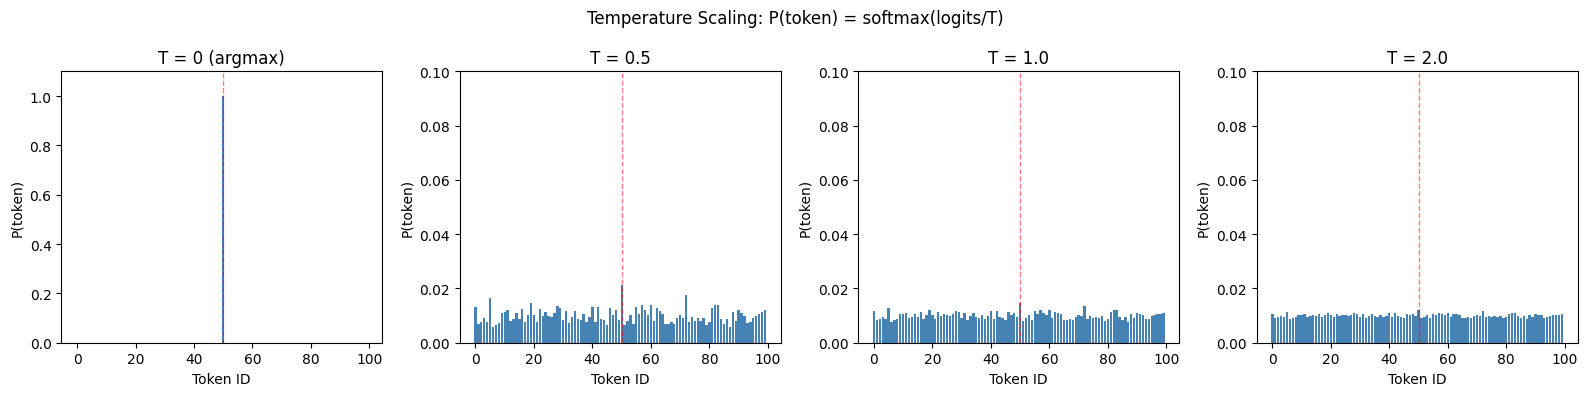


Math:
  T=0.0: argmax(logits) - deterministic selection
  T=0.5: softmax(2×logits) - sharpened distribution
  T=1.0: softmax(logits) - standard softmax
  T=2.0: softmax(0.5×logits) - flattened distribution


In [38]:
def demonstrate_weight_tying():
  """Show weight tying between embedding and unembedding"""
  vocab_size = 100
  d_model = 32

  # Create embedding layer
  embedding = TokenEmbedding(vocab_size, d_model)  # E: [vocab_size, d_model] maps tokens → vectors

  # LM head with weight tying
  lm_head_tied = LanguageModelingHead(d_model, vocab_size,
                                      weight_tying=True,  # Reuses embedding.weight^T
                                      embedding_layer=embedding)

  # LM head without weight tying
  lm_head_separate = LanguageModelingHead(d_model, vocab_size,
                                         weight_tying=False)  # Creates new weight matrix

  # Count parameters
  tied_params = sum(p.numel() for p in [embedding] + [lm_head_tied]
                   for p in p.parameters())  # Only counts embedding weights once
  separate_params = sum(p.numel() for p in [embedding] + [lm_head_separate]
                       for p in p.parameters())  # Counts both embedding + output weights

  print(f"\nParameter Count:")
  print(f"  With tying: {tied_params:,} ({vocab_size}×{d_model})")
  print(f"  Without: {separate_params:,} (2×{vocab_size}×{d_model})")
  print(f"  Saved: {separate_params - tied_params:,} ({(separate_params - tied_params) / separate_params * 100:.0f}%)")

  # Test forward pass
  x = torch.randn(2, 10, d_model)  # [batch=2, seq=10, d_model=32]
  logits_tied = lm_head_tied(x)  # [2, 10, 100] - logits for each position
  logits_separate = lm_head_separate(x)
  print(f"\nOutput shapes: {logits_tied.shape} (both)")  # [batch, seq, vocab_size]

  # Visualize effect of temperature
  temperatures = [0, 0.5, 1.0, 2.0]  # 0 = greedy/argmax, higher = more random
  x_single = torch.randn(1, d_model)  # Single hidden state [batch=1, d_model=32]

  print(f"\nTemperature Effects on Distribution:")
  plt.figure(figsize=(16, 4))

  for i, temp in enumerate(temperatures):
    if temp == 0:  # Special case: greedy decoding
      logits = lm_head_tied.forward(x_single, temperature=1.0)  # Get raw logits
      probs = torch.zeros_like(logits)  # Zero probability everywhere
      probs[0, logits.argmax()] = 1.0  # Probability 1 at argmax (deterministic)
    else:
      probs = lm_head_tied.get_probs(x_single, temperature=temp)  # softmax(logits/temp)

    # Compute statistics
    top5_probs, top5_indices = torch.topk(probs[0], 5)
    entropy = -(probs * (probs + 1e-10).log()).sum().item()  # Shannon entropy H(p)

    print(f"  T={temp:3.1f}: Top5={top5_indices[:3].detach().numpy()} "  # Show only top 3
          f"P_max={probs.max().item():.3f} H={entropy:.2f}")

    # Plot distribution
    plt.subplot(1, 4, i+1)
    plt.bar(range(vocab_size), probs[0].detach().numpy(), color='steelblue')
    plt.title(f'T = {temp}' + (' (argmax)' if temp == 0 else ''))
    plt.xlabel('Token ID')
    plt.ylabel('P(token)')
    plt.ylim(0, max(0.1, probs.max().item() * 1.1))

    # Mark top token
    max_idx = probs[0].argmax().item()
    plt.axvline(x=max_idx, color='red', linestyle='--', alpha=0.5, linewidth=1)

  plt.suptitle('Temperature Scaling: P(token) = softmax(logits/T)', fontsize=12)
  plt.tight_layout()
  plt.show()

  print(f"\nMath:")
  print(f"  T=0.0: argmax(logits) - deterministic selection")
  print(f"  T=0.5: softmax(2×logits) - sharpened distribution")
  print(f"  T=1.0: softmax(logits) - standard softmax")
  print(f"  T=2.0: softmax(0.5×logits) - flattened distribution")

demonstrate_weight_tying()

#Language Modeling Head: Unembedding and Logit Lens Implementation

In [39]:
class LogitLens:
  """
  Interpret intermediate transformer representationts
  Reveals what tokens the model predicts at each layer by projecting the hiddn states through the unembedding matrix
  Shows how predictions evolve from ealy layers to late layes.
  """

  def __init__(self,unembedding_matrix, vocab=None):
    """
    undembedding_matrix: [d_model, vocab_size] to projects to hidden states
    vocab: optional vocab for decoding
    """

    self.unembedding = unembedding_matrix
    self.vocab = vocab

    print(f"LogitLens initialized with unembedding matrix: {unembedding_matrix.shape}")
    print(f"  Sample W_U values: {unembedding_matrix[:2, :3].detach().numpy().round(3)}\n")  # First 2 dims, 3 vocab items

  def decode_hidden_state(self, hidden_state, top_k=5):
    """
    Project hidden state to vocab and show top predictions
    hidden_state: [d_model] or [batch, seq_len, d_model]

    logits = h @ W_U where h ∈ ℝ^d_model, W_U ∈ ℝ^{d_model × vocab_size}
    """

    print(f"\n\nDecoding hidden state: {hidden_state.shape}")

    # Ensure batched format for consistent processing
    if hidden_state.dim()==1:
      hidden_state = hidden_state.unsqueeze(0) # [d_model] → [1, d_model]
      print(f"  Expanded to batch format: {hidden_state.shape}")

    # Project to vocab space: [batch, *, d_model] @ [d_model, vocb_size] = [batch, * , vocab_size]
    print(f"Computing: hidden @ W_U^T | {hidden_state.shape} @ [{self.unembedding.shape[0]}, {self.unembedding.shape[1]}]")
    logits = hidden_state @ self.unembedding  # Direct matmul: [batch, d_model] @ [d_model, vocab_size]


    # Convert logits to probs
    probs = F.softmax(logits, dim=-1) # Normalize vocab dim
    print(f"  Probs: {probs.shape}, sum={probs[0].sum():.6f} (should be 1.0)")

    # Extract top-k most likely tokens
    top_probs, top_indices = torch.topk(probs, k=top_k, dim=-1)
    print(f"  Top-{top_k} tokens: {top_indices[0].detach().numpy()} with probs: {top_probs[0].detach().numpy().round(3)}\n")

    return top_probs, top_indices


  def analyze_layer_predictions(self, hidden_states_by_layer, position = -1):
    """
    Analyze the predictions at each layer for a specifc position
    hidden_states_by_layer: list of [batch, deq_len, d_model]

    Shows incremental refinement of the model, from randome guesses to confident predictions
    """

    n_layers = len(hidden_states_by_layer)
    print(f"Analyzing {n_layers} layers at position {position}")

    predictions_by_layer = []

    for layer_idx, hidden in enumerate(hidden_states_by_layer):
      layer_name = f"Embedding" if layer_idx == 0 else f"Layer {layer_idx}" if layer_idx < n_layers-1 else "Final"
      print(f"\n{layer_name}:")

      # Extract hidden state
      if hidden.dim() == 3:
        h = hidden[0, position] # First batch, specified position
        print(f"  Extracted position {position}: {h.shape} from {hidden.shape}")

      else:
        h = hidden

      # Analyze hidden state stats before projection
      print(f"  Hidden stats: mean={h.mean():.3f}, std={h.std():.3f}, norm={h.norm():.3f}")

      top_probs, top_indices = self.decode_hidden_state(h,top_k=5)
      predictions_by_layer.append((top_probs[0], top_indices[0]))

      # Show prediction confidence evolution
      max_prob = top_probs[0][0].item()
      entropy = -(top_probs[0] * (top_probs[0] + 1e-10).log()).sum().item() # H = -Σ p·log(p)
      print(f"  Max confidence: {max_prob:.3f}, Entropy: {entropy:.3f}")

    return(predictions_by_layer)


### Demonstrate Logit Lens


Model configuration:
  Vocab size: 100
  Model dim: 64
  Layers: 100
  Parameters: 6400 (embedding) + 1638400 (approx layers)

PE div_term:
 tensor([1.0000e+00, 7.4989e-01, 5.6234e-01, 4.2170e-01, 3.1623e-01, 2.3714e-01,
        1.7783e-01, 1.3335e-01, 1.0000e-01, 7.4989e-02, 5.6234e-02, 4.2170e-02,
        3.1623e-02, 2.3714e-02, 1.7783e-02, 1.3335e-02, 1.0000e-02, 7.4989e-03,
        5.6234e-03, 4.2170e-03, 3.1623e-03, 2.3714e-03, 1.7783e-03, 1.3335e-03,
        1.0000e-03, 7.4989e-04, 5.6234e-04, 4.2170e-04, 3.1623e-04, 2.3714e-04,
        1.7783e-04, 1.3335e-04]) 


PE Div_term (frequencies):
 [1.         0.7498942  0.56234133 0.42169648]
PE Example - Position 10:
  dim_0 = sin(10 × 1.0000) = -0.5440
  dim_2 = sin(10 × 0.7499) = 0.9376
  dim_4 = sin(10 × 0.5623) = -0.6129
  dim_1 = cos(10 × 1.0000) = -0.8391
  dim_3 = cos(10 × 0.7499) = 0.3476
  dim_5 = cos(10 × 0.5623) = 0.7901

PE shape:
 torch.Size([1, 5000, 64]) [batch=1, max_len=5000, d_model=64]

FFN: 64 → 256 → 64 with relu

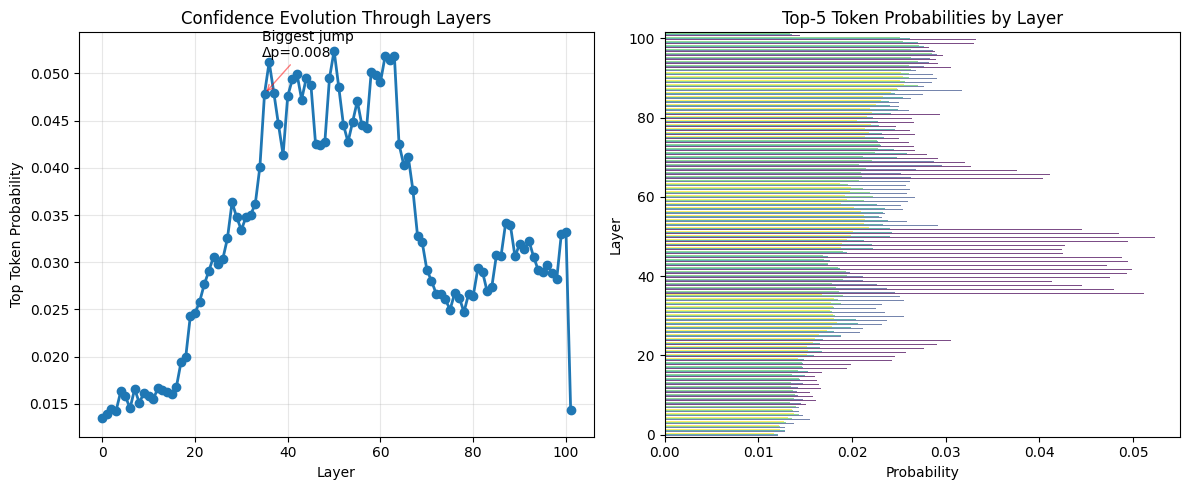


ENTROPY ANALYSIS (uncertainty measure):
  Embedding : H=0.269 (low uncertainty)
  Layer 1   : H=0.280 (low uncertainty)
  Layer 2   : H=0.281 (low uncertainty)
  Layer 3   : H=0.291 (low uncertainty)
  Layer 4   : H=0.309 (low uncertainty)
  Layer 5   : H=0.309 (low uncertainty)
  Layer 6   : H=0.300 (low uncertainty)
  Layer 7   : H=0.308 (low uncertainty)
  Layer 8   : H=0.300 (low uncertainty)
  Layer 9   : H=0.307 (low uncertainty)
  Layer 10  : H=0.305 (low uncertainty)
  Layer 11  : H=0.302 (low uncertainty)
  Layer 12  : H=0.305 (low uncertainty)
  Layer 13  : H=0.304 (low uncertainty)
  Layer 14  : H=0.310 (low uncertainty)
  Layer 15  : H=0.310 (low uncertainty)
  Layer 16  : H=0.318 (low uncertainty)
  Layer 17  : H=0.326 (low uncertainty)
  Layer 18  : H=0.330 (low uncertainty)
  Layer 19  : H=0.344 (low uncertainty)
  Layer 20  : H=0.352 (low uncertainty)
  Layer 21  : H=0.362 (low uncertainty)
  Layer 22  : H=0.366 (low uncertainty)
  Layer 23  : H=0.371 (low uncertainty)

In [40]:
def demonstrate_logit_lens():
  """Show predictions evolution through layers"""

  class MiniTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads):
      super().__init__()

      self.embedding = TokenEmbedding(vocab_size, d_model)
      self.pos_encoding = PositionalEncoding(d_model)
      self.layers = nn.ModuleList([
          TransformerBlock(d_model, n_heads) for _ in range(n_layers)
      ])
      self.ln_final = nn.LayerNorm(d_model) # final normalization before output

    def forward(self, x, return_all_hidden=False):
      print(f"\nMiniTransformer forward pass:")
      print(f"  Input tokens: {x.shape}")

      # Embedding
      x = self.embedding(x)
      print(f"  After embedding: {x.shape}, norm={x.norm():.2f}")

      x = self.pos_encoding(x) # Add position info: x + PE(pos)
      print(f"  After pos encoding: {x.shape}, norm={x.norm():.2f}")


      # Forward pass through layers adding to Residual Stream
      hidden_states = [x] # Intermediate representations
      for i,layer in enumerate(self.layers):
        x_before = x.clone()
        x, _ = layer(x) # x_new = x_old + ΔLayer (residual connection inside)

        # Measure change in the layer
        delta = (x - x_before).norm() / x_before.norm()
        print(f"  After layer {i+1}: norm={x.norm():.2f}, relative change={delta:.3f}")

        hidden_states.append(x)

      x = self.ln_final(x) # Layer Normalization before projection: (x - μ) / σ
      print(f"  After final LN: norm={x.norm():.2f}")

      hidden_states.append(x)

      if return_all_hidden:
        return( x, hidden_states)
      else:
        return(x)
  # Initialize model with specific dimensions
  vocab_size = 100  # Small vocabulary for demo
  d_model = 64      # Hidden dimension
  n_layers = 100      # Depth of network ## Tested on 10 and 100

  print(f"\nModel configuration:")
  print(f"  Vocab size: {vocab_size}")
  print(f"  Model dim: {d_model}")
  print(f"  Layers: {n_layers}")
  print(f"  Parameters: {vocab_size * d_model} (embedding) + {n_layers * (4*d_model**2)} (approx layers)")

  model = MiniTransformer(vocab_size, d_model, n_layers, n_heads=4)

  # Get unembedding matrix: E^T projects back to vocab | [d_model, vocab_size]
  unembedding = model.embedding.embedding.weight.T  # Transpose of embedding matrix
  print(f"\nUnembedding matrix: {unembedding.shape} (E^T)")
  print(f"  Frobenius norm: {unembedding.norm():.2f}")

  # Create logit lens analyzer
  logit_lens = LogitLens(unembedding)

  # Process sample input - random tokens for demonstration
  tokens = torch.randint(0, vocab_size, (1, 10))  # [batch=1, seq=10]
  print(f"\nInput tokens: {tokens[0].numpy()}")

  output, hidden_states = model(tokens, return_all_hidden=True)
  print(f"\nCollected {len(hidden_states)} hidden states")

  # Analyze predictions at each layer for last position
  predictions = logit_lens.analyze_layer_predictions(hidden_states, position=-1)

  # Visualize evolution of predictions through layers
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))

  # Plot 1: Top prediction probability by layer - shows confidence growth
  layers = list(range(len(predictions)))
  top_probs = [pred[0][0].item() for pred in predictions]  # Extract max probability
  top_tokens = [pred[1][0].item() for pred in predictions]  # Extract predicted token

  print(f"\n{'='*50}")
  print("CONFIDENCE EVOLUTION:")
  for i, (prob, token) in enumerate(zip(top_probs, top_tokens)):
    layer_name = f"Layer {i}" if 0 < i < len(predictions)-1 else ("Embedding" if i == 0 else "Final")
    print(f"  {layer_name:10}: Token {token:3d} (p={prob:.3f})")

  axes[0].plot(layers, top_probs, marker='o', linewidth=2)
  axes[0].set_xlabel('Layer')
  axes[0].set_ylabel('Top Token Probability')
  axes[0].set_title('Confidence Evolution Through Layers')
  axes[0].grid(True, alpha=0.3)

  # Annotate key transitions
  if len(top_probs) > 1:
    max_jump = np.diff(top_probs).argmax()
    y_range = max(top_probs) - min(top_probs)
    axes[0].annotate(f'Biggest jump\nΔp={top_probs[max_jump+1]-top_probs[max_jump]:.3f}',
                    xy=(max_jump+1, top_probs[max_jump+1]),
                    xytext=(max_jump+0.5, top_probs[max_jump+1] + y_range*0.1),
                    arrowprops=dict(arrowstyle='->', color='red', alpha=0.5))

  # Plot 2: Top-5 predictions at each layer - shows distribution changes
  for layer_idx, (probs, indices) in enumerate(predictions):
    y_positions = [layer_idx] * 5
    x_positions = probs.detach().numpy()
    colors = plt.cm.viridis(np.linspace(0, 1, 5))

    for i in range(5):
      axes[1].barh(layer_idx + i*0.15 - 0.3, x_positions[i],
                  height=0.15, color=colors[i], alpha=0.7)

  axes[1].set_ylabel('Layer')
  axes[1].set_xlabel('Probability')
  axes[1].set_title('Top-5 Token Probabilities by Layer')
  axes[1].set_ylim(-0.5, len(predictions) - 0.5)

  plt.tight_layout()
  plt.show()

  # Compute and display entropy evolution - measures prediction uncertainty
  print(f"\n{'='*50}")
  print("ENTROPY ANALYSIS (uncertainty measure):")
  for i, (probs, indices) in enumerate(predictions):
    # Shannon entropy: H = -Σ p·log(p) - higher means more uncertain
    entropy = -(probs * (probs + 1e-10).log()).sum().item()
    layer_name = f"Layer {i}" if 0 < i < len(predictions)-1 else ("Embedding" if i == 0 else "Final")
    print(f"  {layer_name:10}: H={entropy:.3f} {'(high uncertainty)' if entropy > 1.5 else '(low uncertainty)' if entropy < 0.5 else ''}")

  print("\nEarly layers: High entropy, uniform predictions (model unsure)")
  print("\nMiddle layers: Rapid refinement, confidence grows")
  print("\nLate layers: Low entropy, peaked distribution (model confident)")
  print("\nResidual stream accumulates information: h_final = h_0 + Σ ΔLayer_i")

demonstrate_logit_lens()

print("\nThe Model should be Trained on actual data in order to see the LogLens evolve")

print("""\nWith 10 Layers:
LogitLens on this untrained transformer shows near-uniform probability distributions
across all layers with randomly changing token predictions - a stark contrast to
trained models where early layers show high-entropy uncertainty that progressively
refines into confident, low-entropy predictions in later layers. Here, random
weights produce only noise rather than the incremental understanding that emerges
through the residual stream in trained transformers.
""")


print("""\nWith 100 Layers:
LogitLens on this untrained transformer reveals emergent structure from random weights:
early layers show unstable token predictions that converge to a dominant token
for many consecutive layers, with confidence peaking mid-network before collapsing back
to near-uniform at the output. Unlike trained models where entropy decreases as
understanding builds, here entropy rises then falls - reflecting mathematical artifacts
from compounding random transformations rather than meaningful information refinement.
These patterns (stable attractors, oscillating confidence) demonstrate how deep random
networks create statistical regularities that superficially mimic but fundamentally
differ from the incremental understanding in trained transformers.
""")


print("""\n
Key principle: LogitLens must be applied to a trained model during inference to see meaningful patterns.
Using it before or during training only shows noise or unstable learning dynamics.
The ideal spot is right after training completes, analyzing how the trained model processes
specific prompts to reveal the learned hierarchical representations - early layers showing uncertainty
that progressively refines into confident predictions in later layers.
""")

# Full Transformer Language Model

In [41]:
class TransformerLM(nn.Module):
  """
  Compete trnasformer language model (Decoder-Only)
  Implements GPT-stype arch:token embed -> pos encoding -> N transformers blocks -> layer norm -> lang model head

  No encoder, only causal self-attention for autorregressivne generation
  """

  def __init__(self, vocab_size, d_model=512, n_layers=6, n_heads = 8,
               d_ff=2048, max_len=5000, dropout=0.1, weight_tying=True ): # d_ff dim of the feed forward usually 4*d_model
    super(TransformerLM, self).__init__()


    print(f"\nInitializing TransformerLM:")
    print(f"  vocab_size={vocab_size}, d_model={d_model}, n_layers={n_layers}")
    print(f"  n_heads={n_heads}, d_head={d_model//n_heads}, d_ff={d_ff}")
    print(f"  weight_tying={weight_tying}\n")

    # Input layers: token ids -> dense vectors
    self.token_embedding = TokenEmbedding(vocab_size, d_model)
    self.pos_encoding = PositionalEncoding(d_model, max_len) # PE(pos, 2i) = sin(pos/10000^(2i/d))

    # Stack transformers blocks: each adds increm understanding
    # h_l = h_{h-1} + TrnasformerBlock(h_{l-1}) - residual connecitons inside each block
    self.transformer_blocks = nn.ModuleList([
        TransformerBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)
    ])

    print(f"\nCreated {n_layers} transformer blocks, each with:")
    print(f"  MHA params: {3*d_model*d_model + d_model*d_model} (QKV + O projections)")
    print(f"  FFN params: {d_model*d_ff + d_ff*d_model} (2 linear layers)\n")

    # Final layer norm: stabilization before projection
    self.ln_final = nn.LayerNorm(d_model) # (x - μ) / σ * γ + β

    # Language modeling head: project hidden states -> vocab logits
    # With weight_tying true: reuses embedding matrix E^T for memory efficiency
    self.lm_head = LanguageModelingHead(
        d_model, vocab_size, weight_tying=weight_tying,
        embedding_layer=self.token_embedding if weight_tying else None
        )

    if weight_tying:
      print(f"\nWeight tying enabled: sharing {vocab_size*d_model} parameters")
      print(f"  Embedding: tokens -> vectors via E[token_id]")
      print(f"  Unembedding: vectors -> logits via vector @ E^T\n")

    self.dropout = nn.Dropout(dropout) # Regularization on training
    self.d_model = d_model
    self.n_layers = n_layers

    # Initialize parameters for stable training
    self._init_parameters()

    total_params = sum(p.numel() for p in self.parameters())
    print(f"Total parameters: {total_params:,} ({total_params/1e6:.1f}M)\n")

  def _init_parameters(self):
    """
    Initialize params with Xavier Uniform

    Xavier/Glorot initialization: Var(W) = 2/(n_in + n_out)
    Maintains variance across layers, prevents vanishing/exploding gradients
    """

    for p in self.parameters():
      if p.dim() > 1:# Only for weight matrices, not biases/scalars
        nn.init.xavier_uniform_(p)


  def forward(self, input_ids, targets=None, return_all_hidden=False):
    """
    input_ids: [batch, seq_len] token indices
    targets: [batch, seq_len] next token labels (optional, for training)
    Returns: logits [batch, seq_len, vocab_size] and optionally loss

    Information flow: tokens -> embeddings -> N transformers layers -> logits
    """

    batch_size, seq_len = input_ids.shape
    print(f"\nForward pass: batch={batch_size}, seq_len={seq_len}")


    # Create causal mask: prevents attending to fut tokens
    # mask[i,j] = 1 if i >= j (can attend), 0 if i < j (cannot attend)
    mask = torch.tril(torch.ones(seq_len, seq_len, device=input_ids.device)) # lower triangle

    # Token embeddings: discrete tokens -> continuous vectors
    # x[i] = E[input_ids[i]] where E ∈ R^{vocab_size × d_model}
    x = self.token_embedding(input_ids) # [batch, seq_len] -> [batch, seq_len, d_model]
    print(f"After embedding: {x.shape}, norm={x.norm(dim=-1).mean():.3f}")

    # Adding positional information: x = x + PE(pos)
    # Order awareness
    x = self.pos_encoding(x) # x + sin/cos(pos/10000^(2i/d))
    print(f"After pos encoding: {x.shape}, norm={x.norm(dim=-1).mean():.3f}")

    x = self.dropout(x) # Regularization

    # Collecting hidden states for analysis and logitlens
    hidden_states = [x.clone()] if return_all_hidden else []

    # Pass through transformer blocks
    # Each block: x_new = x_old + MHA(LN(x_old)) + FFN(LN(x_old + MHA)) ##(LN-Layer Normamlization;MHA-Mult Head Attn)
    for i, block in enumerate(self.transformer_blocks):
      x_before = x.clone()
      x, attn_weights = block(x,mask) # Self-attn + FFN with Residuals

      # Measure transformation magnitude
      delta_norm = (x-x_before).norm() / x_before.norm()
      print(f"After block {i}: norm={x.norm(dim=-1).mean():.3f}, change={delta_norm:.4f}")

      if return_all_hidden:
        hidden_states.append(x.clone())

    # Final layer norm before projection to vocab
    x = self.ln_final(x)  # Stabilize gradients: (x - μ) / σ * γ + β
    print(f"After final LN: {x.shape}, norm={x.norm(dim=-1).mean():.3f}")

    if return_all_hidden:
      hidden_states.append(x.clone())

    # Project to vocabulary: hidden state4s -> logits for each token
    # logits[b,t,v] = probability score for token v at position-time t in batch b
    print(f"\nComputing logits: {x.shape} @ W_lm^T")  # [B,L,d] @ [d,V]
    logits = self.lm_head(x)  # [batch, seq_len, d_model] -> [batch, seq_len, vocab_size]
    print(f"Logits: {logits.shape}, range=[{logits.min():.2f}, {logits.max():.2f}]")

    # Calc loss if targets provided (for training)
    loss = None
    if targets is not None:
      # Flatten Cross Entropy, compare pred vs actual next token
      logits_view = logits.view(-1, logits.size(-1))  # [batch*seq_len, vocab_size]  #view() reshapes the tensor without copying memory, similar to numpy's reshape() # view(-1) 1-dimensional (1D) array, effectively "flattening". #In PyTorch, the equivalent of NumPy's size (which returns the total number of elements in an array) is torch.numel()
      targets_view = targets.view(-1) # [batch*seq_len]

      # Cross entropy loss -Σ y_true * log(softmax(y_pred))
      loss = F.cross_entropy(logits_view, targets_view, ignore_index=-100 )
      print(f"Loss: {loss.item():.4f} (perplexity={torch.exp(loss).item():.2f})")

    if return_all_hidden:
      return logits, loss, hidden_states
    else:
      return logits,loss

  @torch.no_grad()
  def generate(self, input_ids, max_length=100, temperature=1.0, top_k=50, top_p=0.95):
    """
    Generate text using diff sampling strategies

    Autoregressive generation: P(x_t|x_<t) via causal attention
    Sampling strategies balance quality vs diversity
    """

    self.eval() #In PyTorch, self.eval() (or more commonly, model.eval()) is a method called on a torch.nn.Module instance to set the model to "evaluation mode." .During training, dropout layers randomly set a fraction of neurons to zero to prevent overfitting. In evaluation mode, model.eval() ensures that dropout layers are disabled, meaning all neurons are active, which is necessary for consistent and accurate predictions.
    device = input_ids.device

    print(f"\nGenerating: max_length={max_length}, temp={temperature}, top_k={top_k}, top_p={top_p}")
    print(f"Starting from {input_ids.shape[1]} tokens")

    for step in range(max_length - input_ids.size(1)):   #tensor.size(1) returns the size of the second dimension of a given tensor
      # Get logits for next token: only needs the last position
      logits, _ = self.forward(input_ids) # [batch, seq_len, vocab_size]
      logits = logits[:,-1,:] / temperature # scaling by temp, high vals flatten the distrib while close to zero is more deterministic

      if step == 0:
        print(f"Step {step}: logits {logits.shape}, range=[{logits.min():.2f}, {logits.max():.2f}]")

      # Apply top-k filtering
      if top_k > 0:
        # k top threshold
        top_k_values = torch.topk(logits, top_k)[0] # [batch,k]
        threshold = top_k_values[..., -1, None] # [batch, 1]
        indices_to_remove = logits < threshold # Boolean mask
        logits[indices_to_remove] = -float('inf') # Zero prob after softmax

        if step == 0:
          print(f"  Top-k filtered: keeping {top_k}/{logits.size(-1)} tokens")

      # Apply top-p (nucleus) filtering: smallest set with cumsum(P) > p
      if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1),  dim=-1)


        # Cutoff: where cumsum exceeds p
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0 # Keep at least one token

        # Map back to original indices
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = -float('inf')

        if step == 0:
          kept = (~indices_to_remove).sum().item()
          print(f"  Top-p filtered: keeping {kept}/{logits.size(-1)} tokens (cumsum>{top_p})")


      # Sample from filtered distribution
      probs = F.softmax(logits, dim=-1) # Convert to probs
      next_token = torch.multinomial(probs, num_samples = 1) # Sample token predicted


      if step == 0:
        max_prob_token = probs.argmax(dim=-1)
        max_prob = probs.max(dim=-1)[0]
        print(f"  Sampled token {next_token[0,0]} (max prob token={max_prob_token[0]}, P={max_prob[0]:.3f})")


      # Append to sequence for next iteration
      input_ids = torch.cat([input_ids, next_token], dim=1) # [batch, seq_len+1]

    print(f"Generated {input_ids.shape[1]} total tokens\n")

    return(input_ids)





# Test the Full Transformer LM


In [42]:
def test_transformer_lm():
  """Test the complete transformer lang model"""

  # Model config Hyperparams
  config = {
      'vocab_size':1000,
      'd_model':256,
      'n_layers':4,
      'n_heads':8, # Attention heads (d_head = 256/8 = 32)
      'd_ff':1024, # # FFN intermediate dimension, usually  d_model * n_layers (d_model * 4)
      'max_len': 512,
      'dropout':0.1
      }
  print(f"\nModel Configuration:")
  for k,v in config.items():
    print(f"{k}:{v}")
    print("\n")

  # Model instance
  model = TransformerLM(**config)
  param_count = sum(p.numel() for p in model.parameters())
  print(f"Model created with {param_count:,} parameters")
  print(f"Memory estimate: {param_count * 4 / 1024**2:.1f} MB (float32)\n")  #Estimate model memory: param_count x 4 bytes (float32) -> convert to MB (/1024**2)

  # Test Forward Pass
  batch_size, seq_len = 2,50
  input_ids = torch.randint(0, config['vocab_size'], (batch_size, seq_len))
  targets = torch.randint(0, config['vocab_size'], (batch_size, seq_len))

  print(f"Testing forward pass:")
  print(f"  Input: {input_ids.shape} (random token ids)")
  print(f"  Sample input tokens: {input_ids[0, :10].tolist()}\n")

  logits, loss = model(input_ids, targets)
  print(f"\nForward pass results:")
  print(f"  Input shape: {input_ids.shape}")
  print(f"  Logits shape: {logits.shape}")  # [batch, seq_len, vocab_size]
  print(f"  Loss: {loss.item():.4f}")
  print(f"  Perplexity: {torch.exp(loss).item():.2f}\n")

  # Verify valid probs
  probs = F.softmax(logits[0,0], dim=-1) # First token, first batch
  print(f"  Prob sum check: {probs.sum():.6f} (should be 1.0)")
  print(f"  Top-5 probs: {probs.topk(5)[0].tolist()}\n")

  # Test generation
  prompt = torch.randint(0,config['vocab_size'], (1,5))
  print(f"\nTesting generation:")
  print(f"  Prompt tokens: {prompt[0].tolist()}\n")

  generated = model.generate(prompt, max_length=20, temperature=0.8)
  print(f"\nGeneration results:")
  print(f"  Prompt length: {prompt.size(1)}")
  print(f"  Generated length: {generated.size(1)}")
  print(f"  Generated tokens: {generated[0].tolist()}")
  print(f"  New tokens: {generated[0, prompt.size(1):].tolist()}\n")

  # Model summary
  print("\nModel Architecture Summary:")
  summary(model, input_data=input_ids, verbose=0,
          col_names=['input_size', 'output_size', 'num_params'])

  return model


model = test_transformer_lm()


Model Configuration:
vocab_size:1000


d_model:256


n_layers:4


n_heads:8


d_ff:1024


max_len:512


dropout:0.1



Initializing TransformerLM:
  vocab_size=1000, d_model=256, n_layers=4
  n_heads=8, d_head=32, d_ff=1024
  weight_tying=True


PE div_term:
 tensor([1.0000e+00, 9.3057e-01, 8.6596e-01, 8.0584e-01, 7.4989e-01, 6.9783e-01,
        6.4938e-01, 6.0430e-01, 5.6234e-01, 5.2330e-01, 4.8697e-01, 4.5316e-01,
        4.2170e-01, 3.9242e-01, 3.6517e-01, 3.3982e-01, 3.1623e-01, 2.9427e-01,
        2.7384e-01, 2.5483e-01, 2.3714e-01, 2.2067e-01, 2.0535e-01, 1.9110e-01,
        1.7783e-01, 1.6548e-01, 1.5399e-01, 1.4330e-01, 1.3335e-01, 1.2409e-01,
        1.1548e-01, 1.0746e-01, 1.0000e-01, 9.3057e-02, 8.6596e-02, 8.0584e-02,
        7.4989e-02, 6.9783e-02, 6.4938e-02, 6.0430e-02, 5.6234e-02, 5.2330e-02,
        4.8697e-02, 4.5316e-02, 4.2170e-02, 3.9242e-02, 3.6517e-02, 3.3982e-02,
        3.1623e-02, 2.9427e-02, 2.7384e-02, 2.5483e-02, 2.3714e-02, 2.2067e-02,
        2.0535e-02,

# Simple Tokenizer for Training Demo

In [43]:
class SimpleTokenizer:
  """
  Basic character-level tokenizer
    Maps characters to indices: 'a' -> 97 (ASCII)
  Character-level = finest granularity, no OOV but long sequences
  """


  def __init__(self, vocab_size=256):
    self.vocab_size = vocab_size

    # Bidirectional mappings for encode/decode
    self.char_to_id = { chr(i): i   for i in range(vocab_size)} # 'A' -> 65
    self.id_to_char = { i : chr(i)  for i in range(vocab_size)} # 65 -> 'A'

  def __call__(self, text):
    return([self.char_to_id.get(c,0) for c in text ])

  def decode(self, ids):
    return( ''.join([self.id_to_char.get(id, '') for id in ids ])  )

# tokenizer = SimpleTokenizer()
# tokenizer("Here Ari testing the tokenizer")


#Training Setup

In [44]:
class TextDataset(Dataset):
  """Simple text dataset for LM"""

  def __init__(self, texts, tokenizer, max_length=128):
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.texts = texts

    print(f"\nTextDataset initialized:")
    print(f"  Texts: {len(texts)} samples")
    print(f"  Max length: {max_length} tokens")
    print(f"  Sample text: '{texts[0][:50]}...'\n")

  def __len__(self):
    return(len(self.texts))


  def __getitem__(self,idx):
    text = self.texts[idx]
    tokens = self.tokenizer(text)[:self.max_length]

    # Pad if necessary
    if len(tokens) < self.max_length:
      tokens = tokens + [0] * (self.max_length - len(tokens)) # Right Padding with 0 (typically reserved for <PAD> token)

    tokens = torch.tensor(tokens, dtype=torch.long)


    # For language modeling, target is input shifted by 1
    # Autoregressive setup: predict next token from current

    input_ids = tokens[:-1]  # All except last:  [x₀, x₁, x₂, ..., x_{n-1}]

    targets = tokens[1:]     # All except first: [    x₁, x₂, x₃,   ...,   x_n]



    if idx == 0:  # Show alignment once
      print(f"Autoregressive alignment (first 5 tokens):")
      print(f"  Input:  {input_ids[:5].tolist()} -> predict")
      print(f"  Target: {targets[:5].tolist()}\n")

    return input_ids, targets


In [45]:
def setup_training():
  """Seup training components"""

  # Create simple dataset: 4 sentences repeated for sufficient data
  texts = [
    "The quick brown fox jumps over the lazy dog.",      # Pangram: contains all letters
    "Machine learning is fascinating and powerful.",      # Technical content
    "Transformers have revolutionized NLP.",             # Domain-specific
    "Attention is all you need for state-of-the-art results.",  # Paper reference
  ] * 25  # Repeat 25x -> 100 samples total

  print(f"\nDataset statistics:")
  print(f"  Unique texts: 4")
  print(f"  Total samples: {len(texts)}")
  print(f"  Total characters: {sum(len(t) for t in texts):,}")
  print(f"  Avg length: {sum(len(t) for t in texts) / len(texts):.1f} chars\n")

  tokenizer = SimpleTokenizer()
  dataset = TextDataset(texts, tokenizer, max_length=50)

  # DataLoader: handles batching, shuffling, parallel loading
  # batch_size=4: process 4 sequences simultaneously (efficiency vs memory)
  dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


  print(f"DataLoader configuration:")
  print(f"  Batch size: 4")
  print(f"  Batches per epoch: {len(dataloader)}")
  print(f"  Shuffle: True (randomize order each epoch)\n")


  # Small Transformer
  model = TransformerLM(
    vocab_size=256,  # Full ASCII range
    d_model=128,     # Hidden dimension (small for demo)
    n_layers=2,      # Shallow network (GPT-3 has 96)
    n_heads=4,       # 4 attention heads (d_head = 128/4 = 32)
    d_ff=256,        # FFN dimension (typically 4*d_model)
    dropout=0.1      # 10% dropout for regularization
  ).to(device)

  total_params = sum(p.numel() for p in model.parameters())
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

  print(f"Model architecture:")
  print(f"  Total parameters: {total_params:,}")
  print(f"  Trainable parameters: {trainable_params:,}")
  print(f"  Memory (float32): {total_params * 4 / 1024**2:.2f} MB\n") #Estimate model memory: total_params x 4 bytes (float32) -> convert to MB (/1024**2)

  # Optimizer: AdamW (Adam with decoupled weight decay)
  # Adam: adaptive learning rates per parameter based on moment estimates
  # Weight decay: L2 regularization, but applied directly (not via gradients)
  optimizer = optim.AdamW(
      model.parameters(),
      lr=1e-3, # 0.001
      weight_decay=0.01 # L2 penalty: ||w||**2 regularization, shrinks weights but does not eliminate them (like L1 does)
      )
  print(f"Optimizer (AdamW):")
  print(f"  Learning rate: 1e-3")
  print(f"  Weight decay: 0.01 (L2 regularization)")
  print(f"  Betas: (0.9, 0.999) (momentum parameters)")
  print(f"  Eps: 1e-08 (numerical stability)\n")


  # Learning rate scheduler: cosine annealing with linear warmup
  # Warmup: gradually increase lr from 0 to initial_lr (stability)
  # Cosine: smoothly decrease lr following cosine curve (better convergence)
  def get_lr_scheduler(optimizer, num_warmup_steps, num_training_steps):
    """
    Creates schedule: linear warmup then cosine decay

    lr(t) = t/warmup * lr_init                if t < warmup
    lr(t) = lr_init * 0.5 * (1 + cos(π*progress))  if t >= warmup
    where progress = (t - warmup) / (total - warmup)
    """

    def lr_lambda(current_step):
      #Warmup phase: linearincreasing from 0 to 1
      if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))

      # Cosine annealing phase: cosine decrease from 1 to 0
      progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps)) # remaining warmup steps divided by defined cos annealing decay steps
      return(max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress))))


    return( torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda))

  num_epochs = 10
  steps_per_epoch = len(dataloader) # batches per epoch
  total_steps = num_epochs * steps_per_epoch
  warmup_steps = total_steps // 10   # 10% warmup,  90% cosine annealing decay

  scheduler = get_lr_scheduler(optimizer, warmup_steps, total_steps)

  print(f"Training schedule:")
  print(f"  Epochs: {num_epochs}")
  print(f"  Steps per epoch: {steps_per_epoch}")
  print(f"  Total steps: {total_steps}")
  print(f"  Warmup steps: {warmup_steps} ({warmup_steps/total_steps*100:.0f}% of training)")


  # Show learning rate schedule
  print(f"\nLearning rate schedule samples:")
  test_steps = [0, warmup_steps//2, warmup_steps, total_steps//2, total_steps-1]
  for step in test_steps:
    scheduler.last_epoch = step - 1  # LambdaLR uses last_epoch
    lr = scheduler.get_last_lr()[0] * 1e-3  # Multiply by base lr
    phase = "warmup" if step < warmup_steps else "cosine"
    print(f"  Step {step:3d}: lr={lr:.6f} ({phase})")
  scheduler.last_epoch = -1  # Reset

  print(f"\nTraining ready to begin!")
  print(f"  Device: {device}")
  print(f"  Mixed precision: {'Enabled' if torch.cuda.is_available() else 'Disabled'}")
  print(f"  Gradient accumulation: Not configured (batch_size=4 sufficient)\n")

  return( model, optimizer, scheduler, dataloader, tokenizer)

# Initialize training components
model, optimizer, scheduler, dataloader, tokenizer = setup_training()



Dataset statistics:
  Unique texts: 4
  Total samples: 100
  Total characters: 4,525
  Avg length: 45.2 chars


TextDataset initialized:
  Texts: 100 samples
  Max length: 50 tokens
  Sample text: 'The quick brown fox jumps over the lazy dog....'

DataLoader configuration:
  Batch size: 4
  Batches per epoch: 25
  Shuffle: True (randomize order each epoch)


Initializing TransformerLM:
  vocab_size=256, d_model=128, n_layers=2
  n_heads=4, d_head=32, d_ff=256
  weight_tying=True


PE div_term:
 tensor([1.0000e+00, 8.6596e-01, 7.4989e-01, 6.4938e-01, 5.6234e-01, 4.8697e-01,
        4.2170e-01, 3.6517e-01, 3.1623e-01, 2.7384e-01, 2.3714e-01, 2.0535e-01,
        1.7783e-01, 1.5399e-01, 1.3335e-01, 1.1548e-01, 1.0000e-01, 8.6596e-02,
        7.4989e-02, 6.4938e-02, 5.6234e-02, 4.8697e-02, 4.2170e-02, 3.6517e-02,
        3.1623e-02, 2.7384e-02, 2.3714e-02, 2.0535e-02, 1.7783e-02, 1.5399e-02,
        1.3335e-02, 1.1548e-02, 1.0000e-02, 8.6596e-03, 7.4989e-03, 6.4938e-03,
        5.6234e-03,

### Show sample batch

In [46]:
print("\nSample batch inspection:")
for i, (input_ids, targets) in enumerate(dataloader):
  if i == 0:  # First batch only
    print(f"  Input shape: {input_ids.shape}")  # [batch=4, seq_len=49]
    print(f"  Target shape: {targets.shape}")   # [batch=4, seq_len=49]

    # Decode first sequence to show data
    sample_input = input_ids[0]
    sample_target = targets[0]

    # Find actual text length (before padding)
    non_pad = (sample_input != 0).sum() # counts all non 0

    print(f"\nFirst sequence (length={non_pad}):")
    print(f"  Input text:  '{tokenizer.decode(sample_input[:20].tolist())}...'")
    print(f"  Target text: '{tokenizer.decode(sample_target[:20].tolist())}...'")
    print(f"  Input tokens:  {sample_input[:10].tolist()}")
    print(f"  Target tokens: {sample_target[:10].tolist()}")
    print(f"  Shift check: input[1:] == target[:-1]? {torch.all(sample_input[1:] == sample_target[:-1])}")
    break


Sample batch inspection:
  Input shape: torch.Size([4, 49])
  Target shape: torch.Size([4, 49])

First sequence (length=49):
  Input text:  'Attention is all you...'
  Target text: 'ttention is all you ...'
  Input tokens:  [65, 116, 116, 101, 110, 116, 105, 111, 110, 32]
  Target tokens: [116, 116, 101, 110, 116, 105, 111, 110, 32, 105]
  Shift check: input[1:] == target[:-1]? True


#Training Loop with Modern Features

In [47]:
def training_with_modern_features(model, optimizer, scheduler, dataloader, num_epochs=10, gradient_accumulation_steps=4):
  """
  Training loop with gradient accumulation and mixed precision

  Gradient Accumulation: simulate larger batch sizes by accumulating gradients over multiple forward passes before actually updating the weights
  Effective batch = batch_size * gradient_accumulation_steps

  Gradient Clipping: prevents exploding gradients by rescaling

  Mixed Precision (AMP): Using float16 for forward pass which is faster, then float32 for the gradients calculations (more stable)
  Prevents underflow via gradient scaling: multiply loss by a scale before the backward pass
  Forward and backward compute run in FP16 (inside autocast), but the gradients are scaled and then stored/applied in FP32 (via the master weights). Weights update: always in FP32 (master weights)
  Searches/checks for inf/NaN and if not it will increase the scale for more stability, if it detects any inf/NaN scale is halved

  Learning Rate Scheduling: Warmup and Cosine annealing

   """

  print(f"\nTraining configuration:")
  print(f"  Epochs: {num_epochs}")
  print(f"  Gradient accumulation steps: {gradient_accumulation_steps}")
  print(f"  Effective batch size: {4 * gradient_accumulation_steps}")  # 4 from dataloader
  print(f"  Updates per epoch: {len(dataloader) // gradient_accumulation_steps}\n")

  # Mixed precision setup: FP16 compute with FP32 master weights
  # GradScaler preventing gradient underflow in FP16 by scaling the loss before the backward pass
  scaler = GradScaler() if torch.cuda.is_available() else None

  if scaler is not None:
    print(f"Mixed precision training enabled (AMP)")
    print(f"  Initial scale: {scaler.get_scale()}")
    print(f"  Growth factor: 2.0 (doubles scale if no inf/nan)")
    print(f"  Backoff factor: 0.5 (halves scale if inf/nan detected)\n")
  else:
    print(f"Mixed precision disabled (CPU mode)\n")

  # Tracking metrics
  losses = []
  learning_rates = []
  gradient_norms = [] # record the L2 norm of gradients after each update

  model.train() # Enabling dropout.Also Batch norm training mode. uses mini-batch statistics (mean/variance of the current batch) to normalize activations.
  global_step = 0

  for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    accumulation_loss = 0 # Track loss

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"  Learning rate: {scheduler.get_last_lr()[0]:.6f}")

    for batch_idx, (input_ids, targets) in enumerate(dataloader):
      # Move to device
      input_ids = input_ids.to(device) # [batch, seq_len]
      targets = targets.to(device)     # [batch, seq_len]


      if batch_idx == 0:
        print(f"  Batch shape: {input_ids.shape}")
        print(f"  Tokens range: [{input_ids.min()}, {input_ids.max()}]\n")

      # Mixed precision forward pass: FP16 for the pass and for the grads FP32
      if scaler is not None:
        # autocast: automatically uses FP16 where safe, and FP32 where needed

        with autocast():
          logits, loss = model(input_ids, targets) # FP16

          # Scale loss for grad accumulation
          # Loss for each mini-batch should be divided by the accumulation steps
          # Maintains correct gradient magnitudes
          loss = loss / gradient_accumulation_steps # Average over accumulation, same value over all the training

          if batch_idx % 10 == 0:
            print(f"  Step {batch_idx}: logits {logits.shape}, dtype={logits.dtype}")
            print(f"    Raw loss: {loss.item() * gradient_accumulation_steps:.4f}")
            print(f"    Scaled loss: {loss.item():.4f}")

        # Backward pass with the gradient scaling
        # scaling gradients up to prevent FP16 underflow: d(scale * loss)/dw = scale*dloss/dw
        scaler.scale(loss).backward() # accumulate scaled gradients
        accumulation_loss +=loss.item()

      else:
        # Standard FP32 training
        logits, loss = model(input_ids, targets)
        loss = loss / gradient_accumulation_steps
        loss.backward() # grad*= d(loss)/dw
        accumulation_loss += loss.item()

      # Gradient accumulation: update weights every N steps
      # Simulates batch_size = actual_batch * accumulation_steps
      # This simulates training with a bigger batch without needing more GPU memory
      # Large batches often improve training stability and allow higher learning rates. But GPUs may not fit big batches. Accumulating gradients over several small micro-batches achieves the same effect as one big batch.
      if (batch_idx + 1) % gradient_accumulation_steps == 0:
        if batch_idx < 20:
          print(f"\n  Accumulated {gradient_accumulation_steps} steps, updating weights...")
          print(f"    Accumulated loss: {accumulation_loss * gradient_accumulation_steps:.4f}")

        # gradient clipping: prevents inestability and expoding gradients
        # rescales gradients if || g || > max_norm, example: if ||g|| > 1.0: g = g * (1.0 / ||g||) ( Scale down to max norm = 1.0)
        if scaler is not None:
          scaler.unscale_(optimizer) # Unscale gradients to FP32 for clipping, bcs FP16 lacks precision for gradients, has tiny values that underflow to zero in fp16 (e.g., 1e-8)

        # Compute gradient norm before clipping
        total_norm = 0
        for p in model.parameters():
          if p.grad is not None:
            total_norm += p.grad.data.norm(2).item()**2 #  L2 "Ridge" regul. norm of param's gradient  √(Σ g²), converted to python float, squared and accumulated

        total_norm = total_norm ** 0.5 # sqrt of final norm

        # Clip gradients: g = g * min(1, max_norm/||g||)
        #clip_grad_norm_ rescales gradients if their total norm exceeds max_norm
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Compute gradient norm after clipping
        clipped_norm = 0
        for p in model.parameters():
          if p.grad is not None:
             clipped_norm += p.grad.data.norm(2).item() ** 2 # Ridge of gradient squared
        clipped_norm = clipped_norm ** 0.5 # sqrt

        if batch_idx < 20:
          print(f"    Gradient norm: {total_norm:.3f} -> {clipped_norm:.3f} (clipped)")

        gradient_norms.append(clipped_norm)


        # weight update, optimizer step: w = w - lr * grad
        if scaler is not None:
          scaler.step(optimizer) # Unscales and updates wihts
          scaler.update() # adjusts scale for nxt iteration

          if batch_idx < 10:
            print(f"    New scale: {scaler.get_scale()}")

        else:
          optimizer.step() # standard weight update: w -= lr*grad


        # update learning rate with the scheduler
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

        # Clear grads for next accumulation
        optimizer.zero_grad()

        global_step += 1

        # Track metrics
        losses.append(accumulation_loss * gradient_accumulation_steps ) # Actual loss
        learning_rates.append(current_lr)

        if global_step % 10 == 0:
          print(f"  Global step {global_step}: loss={losses[-1]:.4f}, lr={current_lr:.6f}")


        accumulation_loss = 0 # Reset for next accum


      epoch_loss += loss.item() * gradient_accumulation_steps
      num_batches += 1


      # Logging
      if batch_idx % 10 == 0 and batch_idx > 0 :
        current_loss = loss.item() * gradient_accumulation_steps
        current_lr = scheduler.get_last_lr()[0]
        perplexity = torch.exp(torch.tensor(current_loss))

        print(f"  Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(dataloader)}")
        print(f"    Loss: {current_loss:.4f} (perplexity: {perplexity:.2f})")
        print(f"    LR: {current_lr:.6f}")
        print(f"    Grad norm: {gradient_norms[-1] if gradient_norms else 0:.3f}")


    # Epoch summary
    avg_loss = epoch_loss / num_batches
    avg_perplexity = torch.exp(torch.tensor(avg_loss))
    print(f"\nEpoch {epoch+1} completed:")
    print(f"  Average loss: {avg_loss:.4f}")
    print(f"  Average perplexity: {avg_perplexity:.2f}")
    print(f"  Final LR: {scheduler.get_last_lr()[0]:.6f}")
    print(f"  Steps completed: {global_step}")

  print(f"\nTraining completed!")
  print(f"  Total steps: {global_step}")
  print(f"  Final loss: {losses[-1]:.4f}")
  print(f"  Loss reduction: {losses[0]:.4f} -> {losses[-1]:.4f} ({(losses[0]-losses[-1])/losses[0]*100:.1f}%)")


  # Plot training curves
  fig, axes = plt.subplots(2, 2, figsize=(12, 8))

  # Loss curve
  axes[0, 0].plot(losses, linewidth=2, alpha=0.8)
  axes[0, 0].set_xlabel('Step')
  axes[0, 0].set_ylabel('Loss')
  axes[0, 0].set_title(f'Training Loss (final={losses[-1]:.3f})')
  axes[0, 0].grid(True, alpha=0.3)

  # Learning rate schedule
  axes[0, 1].plot(learning_rates, linewidth=2, color='orange', alpha=0.8)
  axes[0, 1].set_xlabel('Step')
  axes[0, 1].set_ylabel('Learning Rate')
  axes[0, 1].set_title('Learning Rate Schedule (Cosine w/ Warmup)')
  axes[0, 1].grid(True, alpha=0.3)

  # Add warmup region shading
  warmup_end = len(learning_rates) * 0.1  # 10% warmup
  axes[0, 1].axvspan(0, warmup_end, alpha=0.2, color='blue', label='Warmup')
  axes[0, 1].legend()

  # Gradient norms
  if gradient_norms:
    axes[1, 0].plot(gradient_norms, linewidth=1, color='green', alpha=0.7)
    axes[1, 0].set_xlabel('Update Step')
    axes[1, 0].set_ylabel('Gradient Norm')
    axes[1, 0].set_title('Gradient Norm (after clipping)')
    axes[1, 0].axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Clip threshold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()

  # Perplexity
  perplexities = [torch.exp(torch.tensor(l)).item() for l in losses]
  axes[1, 1].plot(perplexities, linewidth=2, color='purple', alpha=0.8)
  axes[1, 1].set_xlabel('Step')
  axes[1, 1].set_ylabel('Perplexity')
  axes[1, 1].set_title(f'Perplexity (final={perplexities[-1]:.1f})')
  axes[1, 1].grid(True, alpha=0.3)
  axes[1, 1].set_yscale('log')  # Log scale for perplexity

  plt.suptitle(f'Training Metrics - {num_epochs} Epochs', fontsize=14)
  plt.tight_layout()
  plt.show()


  print("1. LOSS CURVE: Sharp initial drop = model rapidly learning patterns. Smooth descent = optimizer working well (AdamW momentum + gradient accumulation). Plateaus indicate memorization vs generalization boundary. Oscillations suggest batch variance or learning rate too high.")

  print("2. LR SCHEDULE: Warmup phase (blue) prevents chaotic early updates when gradients are unstable. Peak after warmup = maximum learning. Cosine decay formula: lr(t) = 0.5 * lr_max * (1 + cos(π*t/T)) enables fine-tuning. End spikes are scheduler artifacts (ignore).")

  print("3. GRADIENT NORMS: Healthy range: 0.5-1.0 never exceeding clip threshold. Below 0.5 = vanishing gradients (dying network). At 1.0 (red line) = clipping active: g = g * min(1, max_norm/||g||). Spikes = difficult loss regions (sharp curvature). Consistent magnitude = good backward flow through layers.")

  print("4. PERPLEXITY (e^loss): Measures prediction uncertainty. Perfect=1.0 (100% confident), Good LM=20-50, Confused=>1000. Log scale shows exponential improvement. High final value = needs more diverse data. Low (<10) on small dataset = overfitting/memorization.")



  # Print gradient statistics
  if gradient_norms:
    print(f"\nGradient norm statistics:")
    print(f"  Mean: {np.mean(gradient_norms):.3f}")
    print(f"  Std: {np.std(gradient_norms):.3f}")
    print(f"  Max: {np.max(gradient_norms):.3f}")
    print(f"  Clipped: {sum(g > 0.99 for g in gradient_norms)}/{len(gradient_norms)} steps")

  return losses


## Train Model


Starting training with modern features...
Device: cuda
Model parameters: 428,544

Initial model check (untrained):

Forward pass: batch=1, seq_len=10
After embedding: torch.Size([1, 10, 128]), norm=9.169
After pos encoding: torch.Size([1, 10, 128]), norm=12.076

Q shape before transpose: torch.Size([1, 10, 4, 32])
Q shape after transpose: torch.Size([1, 4, 10, 32])

Attention scores shape: torch.Size([1, 4, 10, 10])

Context after concatenation: torch.Size([1, 10, 128])

After linear2: torch.Size([1, 10, 128])
After block 0: norm=16.994, change=0.8862

Q shape before transpose: torch.Size([1, 10, 4, 32])
Q shape after transpose: torch.Size([1, 4, 10, 32])

Attention scores shape: torch.Size([1, 4, 10, 10])

Context after concatenation: torch.Size([1, 10, 128])

After linear2: torch.Size([1, 10, 128])
After block 1: norm=20.537, change=0.7046
After final LN: torch.Size([1, 10, 128]), norm=11.314

Computing logits: torch.Size([1, 10, 128]) @ W_lm^T

LM Head Forward Pass
Input x shape: t

/tmp/ipython-input-2420110488.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if torch.cuda.is_available() else None
/tmp/ipython-input-2420110488.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Streaming output truncated to the last 5000 lines.
Attention scores shape: torch.Size([4, 4, 49, 49])

Context after concatenation: torch.Size([4, 49, 128])

After linear2: torch.Size([4, 49, 128])
After block 0: norm=16.447, change=0.7887

Q shape before transpose: torch.Size([4, 49, 4, 32])
Q shape after transpose: torch.Size([4, 4, 49, 32])

Attention scores shape: torch.Size([4, 4, 49, 49])

Context after concatenation: torch.Size([4, 49, 128])

After linear2: torch.Size([4, 49, 128])
After block 1: norm=19.943, change=0.6680
After final LN: torch.Size([4, 49, 128]), norm=11.310

Computing logits: torch.Size([4, 49, 128]) @ W_lm^T

LM Head Forward Pass
Input x shape: torch.Size([4, 49, 128])
Temperature: 1.0


Using weight tying:

Embedding matrix E shape: torch.Size([256, 128])

E sample (first 3 tokens, first 5 dims):
[[-0.004 -0.069  0.028  0.065 -0.121]
 [ 0.002 -0.093 -0.102  0.119  0.048]
 [ 0.103  0.051 -0.074  0.125 -0.056]]

Operation: x @ E^T

x shape: torch.Size([4, 49, 

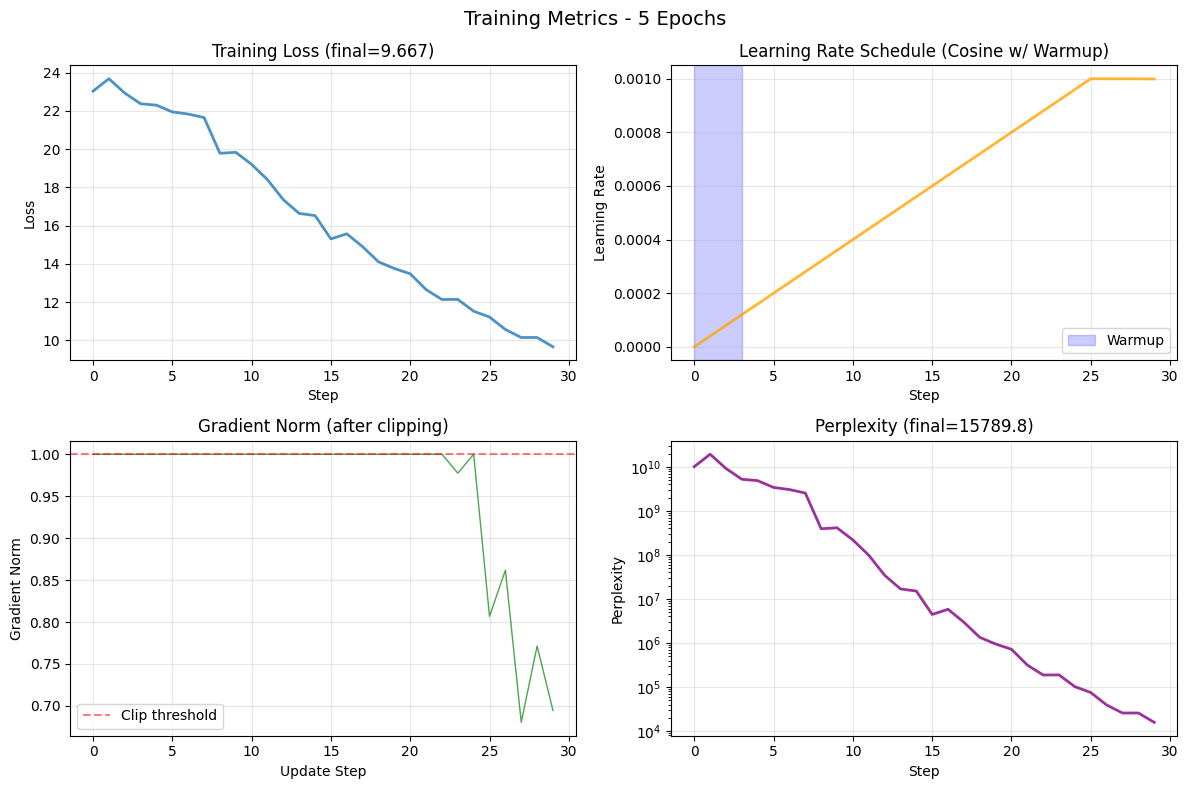

1. LOSS CURVE: Sharp initial drop = model rapidly learning patterns. Smooth descent = optimizer working well (AdamW momentum + gradient accumulation). Plateaus indicate memorization vs generalization boundary. Oscillations suggest batch variance or learning rate too high.
2. LR SCHEDULE: Warmup phase (blue) prevents chaotic early updates when gradients are unstable. Peak after warmup = maximum learning. Cosine decay formula: lr(t) = 0.5 * lr_max * (1 + cos(π*t/T)) enables fine-tuning. End spikes are scheduler artifacts (ignore).
3. GRADIENT NORMS: Healthy range: 0.5-1.0 never exceeding clip threshold. Below 0.5 = vanishing gradients (dying network). At 1.0 (red line) = clipping active: g = g * min(1, max_norm/||g||). Spikes = difficult loss regions (sharp curvature). Consistent magnitude = good backward flow through layers.
4. PERPLEXITY (e^loss): Measures prediction uncertainty. Perfect=1.0 (100% confident), Good LM=20-50, Confused=>1000. Log scale shows exponential improvement. High 

In [48]:
print("\nStarting training with modern features...")
print(f"Device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Check initial model predictions (untrained)
print(f"\nInitial model check (untrained):")
with torch.no_grad():
  sample_input = torch.randint(0, 256, (1, 10)).to(device)
  sample_logits, _ = model(sample_input)
  sample_probs = F.softmax(sample_logits[0, -1], dim=-1)
  top5_probs, top5_idx = torch.topk(sample_probs, 5)
  print(f"  Top-5 predictions: {top5_idx.tolist()}")
  print(f"  Top-5 probs: {top5_probs.tolist()}")
  print(f"  Entropy: {-(sample_probs * (sample_probs + 1e-10).log()).sum():.3f} (high = random)")

losses = training_with_modern_features(model, optimizer, scheduler, dataloader, num_epochs=5)

# Check model after training
print(f"\nPost-training model check:")
with torch.no_grad():
  sample_logits, _ = model(sample_input)
  sample_probs = F.softmax(sample_logits[0, -1], dim=-1)
  top5_probs, top5_idx = torch.topk(sample_probs, 5)
  print(f"  Top-5 predictions: {top5_idx.tolist()}")
  print(f"  Top-5 probs: {top5_probs.tolist()}")
  print(f"  Entropy: {-(sample_probs * (sample_probs + 1e-10).log()).sum():.3f} (low = confident)")

#Flash Attention

Flash Attention is an attention algorithm used to reduce this problem and scale transformer-based models more efficiently, enabling faster training and inference.

Standard attention mechanism uses High Bandwidth Memory (HBM) to store, read and write keys, queries and values. HBM is large in memory, but slow in processing, meanwhile SRAM is smaller in memory, but faster in operations. In the standard attention implementation, the cost of loading and writing keys, queries, and values from HBM is high. It loads keys, queries, and values from HBM to GPU on-chip SRAM, performs a single step of the attention mechanism, writes it back to HBM, and repeats this for every single attention step.


**Instead, Flash Attention loads keys, queries, and values once, fuses the operations of the attention mechanism, and writes them back.**

[Hugging Face](https://huggingface.co/docs/text-generation-inference/en/conceptual/flash_attention)


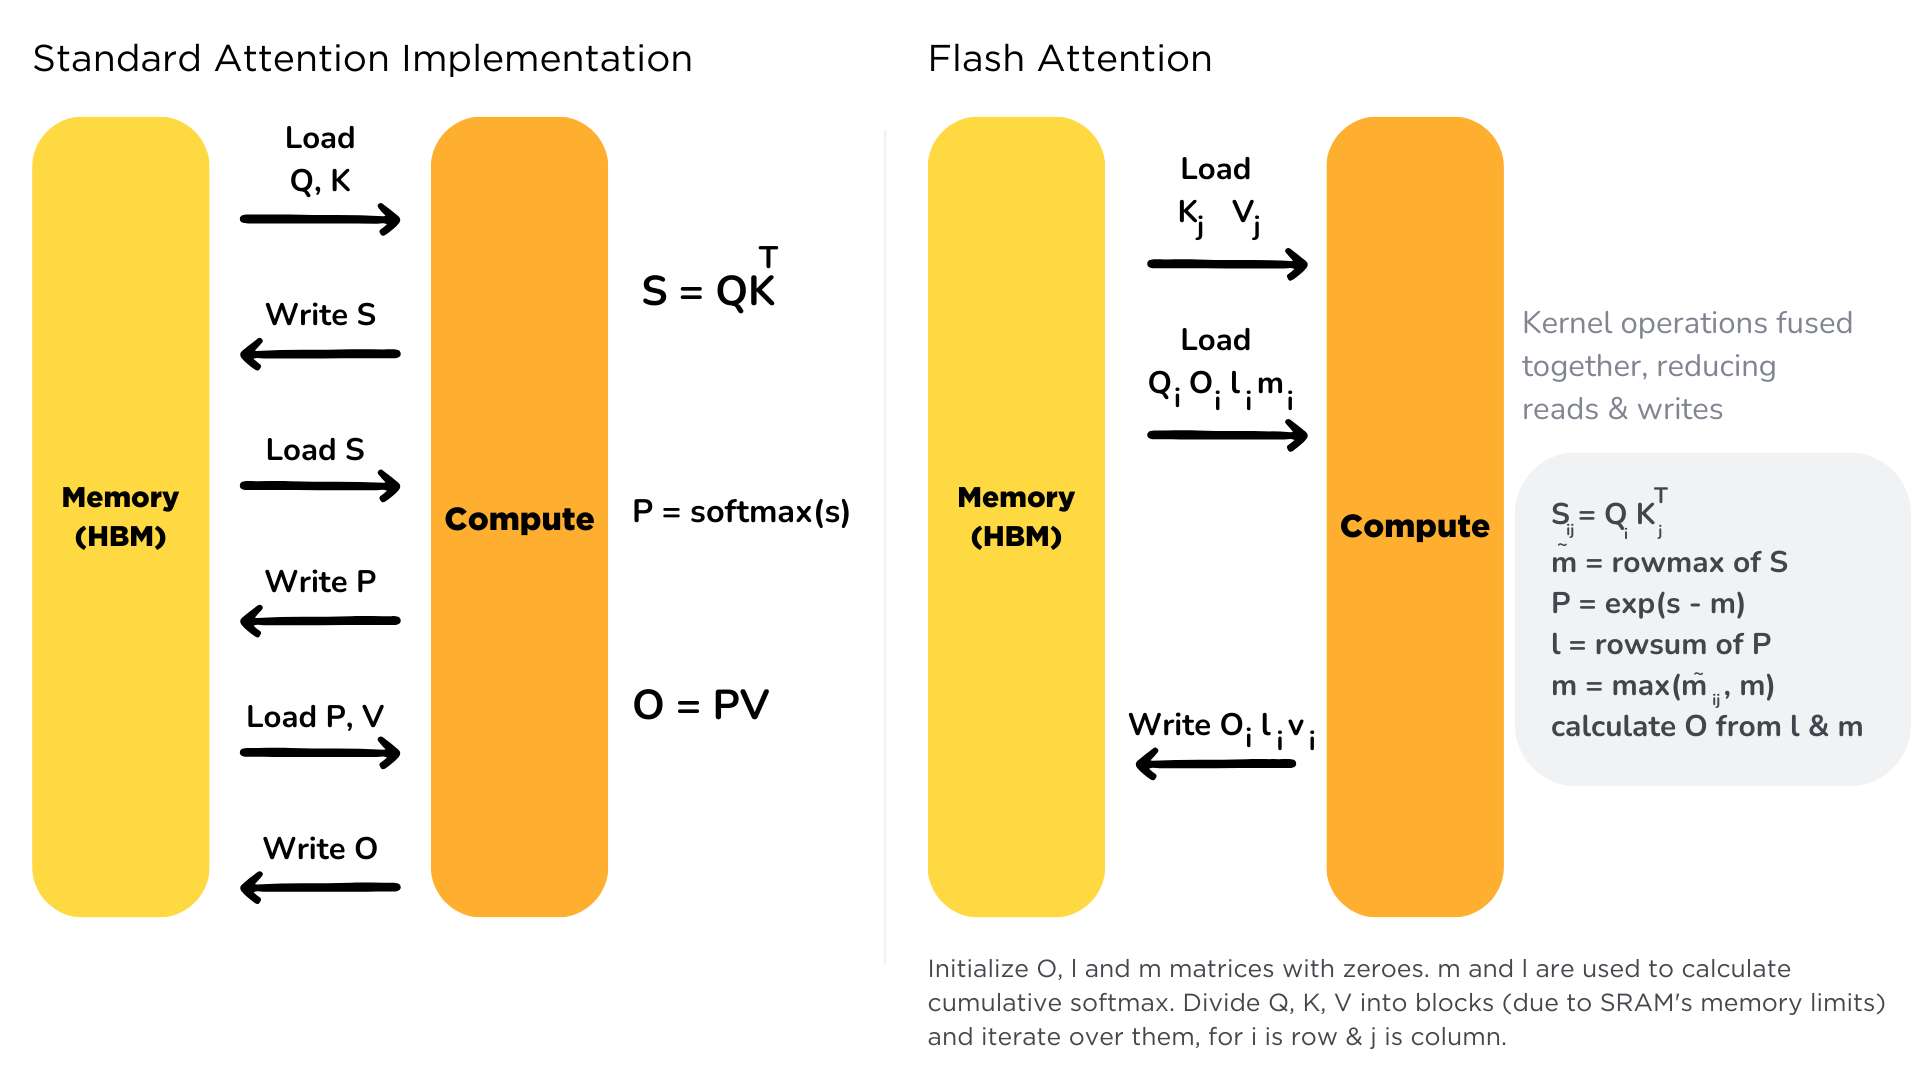

In [49]:
image_url = 'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/tgi/flash-attn.png'
file_name = "downloaded_image.jpg"
urllib.request.urlretrieve(image_url, file_name)
image = Image.open(file_name)
image

In [50]:
def flash_attention_forward(Q,K,V, mask=None, dropout_p=0.0):
  """
  Flash Attention with PyTorch's scaled_dot_product_attention
  O(N²) memory -> O(N) via tiling and recomputation

  Instead of materializing N×N attention matrix, compute attention in blocks and accumulate results
  """

  # Check pytorch version
  torch_version = torch.__version__
  if torch_version < "2.0":
    print(f"\nFlash Attention requires PyTorch 2.0+, current: {torch_version}")

    # starndard attention: Q @ K^T / √d_k -> softmax -> @ V
    scale = 1.0 / math.sqrt(Q.size(-1)) # 1/√d_k for variance stability

    print(f"Q: {Q.shape}, K^T: {K.transpose(-2,-1).shape}")  # [B,h,L,d] @ [B,h,d,L]
    scores = torch.matmul(Q,K.transpose(-2,-1)) * scale   # [B,h,L,L] attention matrix
    print(f"Scores: {scores.shape}, range: [{scores.min():.2f}, {scores.max():.2f}]")


    if mask is not None:
      scores = scores.masked_fill(mask == 0, -1e9)
      print(f"Masked scores: {(scores > -1e8).float().mean():.2%} visible")

    attn_weights = F.softmax(scores, dim=-1) # Normalize over keys
    print(f"Attention weights: {attn_weights.shape}, sparsity: {(attn_weights < 0.01).float().mean():.2%}")

    if dropout_p > 0:
      attn_weights = F.dropout(attn_weights, p=dropout_p)

    output = torch.matmul(attn_weights, V) # [B,h,L,L] @ [B,h,L,d] = [B,h,L,d]
    print(f"Output: {output.shape}, norm: {output.norm(dim=-1).mean():.3f}")

    return( output, attn_weights)


  # Flash Attention: memory-efficient attention via kernel fusion
  print(f"\nUsing Flash Attention (PyTorch {torch_version})")
  print(f"Memory: O(N) instead of O(N²) for sequence length N \n")

  with torch.backends.cuda.sdp_kernel(
    enable_flash = True,          # Using Flash Attention kernel
    enable_math  = False,         # Disabling fallback to standard math
    enable_mem_efficient = False  # Disabling memory-efficient attention
  ):
    # Fused kernel: no intermediate NxN matrix = no quadratic complexity
    output = F.scaled_dot_product_attention(
        Q,K,V,
        attn_mask = mask,
        dropout_p = dropout_p if torch.is_grad_enabled() else 0.0,
        is_causal = True if mask is None else False # Build-in causal masking
    )
    print(f"\nFlash output: {output.shape}, computed without materializing {Q.shape[2]}×{Q.shape[2]} matrix")
  return(output, None) # Flash attention does not return weights



In [51]:
class FlashMultiHeadAttention(nn.Module):
  """
  Multi-head attention using Flash Attention

  Flash Attention algorithm (Dao et al 2022)
  -Tiles Q,K,V into blocks that fit th SRAM
  - Computes attention block-by-block
  - Accumulates results without storing full attention matrix
  """

  def __init__(self, d_model, n_heads, dropout=0.1):
    super(FlashMultiHeadAttention, self).__init__()

    assert d_model % n_heads == 0 # Each head gets d_model (embedding dim) /n_heads dims (num of heads)

    self.d_model = d_model
    self.n_heads = n_heads
    self.d_k = d_model // n_heads # Head size

    # Fused QKV projection: 3*d_model params instead of 3 seprarate matrices
    self.qkv_proj = nn.Linear(d_model, 3 * d_model, bias=False) # W_QKV ∈ R^{d×3d}
    self.out_proj = nn.Linear(d_model, d_model, bias=False)     # W_O ∈ R^{d×d}
    self.dropout_p = dropout

    print(f"\nFlashMultiHeadAttention initialized:")
    print(f"  d_model={d_model}, n_heads={n_heads}, d_k={self.d_k}")
    print(f"  QKV params: {d_model * 3 * d_model:,}")
    print(f"  Output params: {d_model * d_model:,}\n")


  def forward(self, x, mask=None):
    batch_size, seq_len, _ = x.shape

    # Fused QKV projection: x @ W_QKV
    qkv = self.qkv_proj(x) # [B,L,d] @ [d,3d] = [B,L,3d]
    print(f"\nQKV projection: {x.shape} -> {qkv.shape}")

    # Reshape to split Q,K,V and heads
    qkv = qkv.reshape(batch_size, seq_len, 3 , self.n_heads, self.d_k) # [B,L,3,h,d_k]
    print(f"Reshape for heads: {qkv.shape}")

    # Permute for parallel computation
    qkv = qkv.permute(2,0,3,1,4) # [3,B,h,L,d_k] - Q,K,V first for easy splitting
    Q,K,V = qkv[0], qkv[1], qkv[2] # qkv shape: [3, B, h, L, d_k] -> Q, K, V each: [B, h, L, d_k]  (Batch, Heads, Sequence length, Head dimension)
    print(f"After permute: Q={Q.shape}, K={K.shape}, V={V.shape}")

    # Apply Flash Attention or fallback
    if torch.__version__ >="2.0" and torch.cuda.is_available():
      print(f"Using Flash Attention kernel (O(N) memory)")

      # Flash Attention: tiled computation without NxN matrices in HBM (High bandwidth mem)
      # context tensor of shape [B, h, L, d_k] (same as Q/K/V) computed with fused attention kernel
      context = F.scaled_dot_product_attention( # fused attention kernel
          Q,K,V,
          dropout_p = self.dropout_p if self.training else 0.0,  # before was if torch.is_grad_enabled() else 0.0
          is_causal = True # Automatic causal masking
      )

      attn_weights = None # Not computed (to save memory)

      print(f"Flash context: {context.shape}, computed via tiling")

    else:

      print(f"Fallback to standard attention (O(N²) memory)")
      context, attn_weights = flash_attention_forward(Q,K,V, mask, self.dropout_p)


    # Reshape: merge heads back
    context = context.transpose(1,2).contiguous() # [B,h,L,d_k] -> [B,L,h,d_k]
    context = context.view(batch_size, seq_len, self.d_model)   # [B,L,h*d_k] = [B,L,d] # Context needs d in the last dim shape to fit the nn.linear self.out_proj
    print(f"Merged heads: {context.shape}")

    # Final projection: context @ W_O
    output = self.out_proj(context) # [B,L,d] @ [d,d] = [B,L,d]
    print(f"Output projection: {output.shape}, norm: {output.norm(dim=-1).mean():.3f}")

    return(output, attn_weights)



Benchmarking Flash Attention vs Standard Attention
------------------------------------------------------------

FlashMultiHeadAttention initialized:
  d_model=512, n_heads=8, d_k=64
  QKV params: 786,432
  Output params: 262,144


Test configuration:
  Model dim: 512, Heads: 8
  Batch size: 8
  Sequence lengths: [128, 256, 512, 1024]


Sequence length 128:
  Input: torch.Size([8, 128, 512]), memory: 2.00 MB

Q shape before transpose: torch.Size([8, 128, 8, 64])
Q shape after transpose: torch.Size([8, 8, 128, 64])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 512])


Q shape before transpose: torch.Size([8, 128, 8, 64])
Q shape after transpose: torch.Size([8, 8, 128, 64])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 512])


Q shape before transpose: torch.Size([8, 128, 8, 64])
Q shape after transpose: torch.Size([8, 8, 128, 64])

Attention scores shape: torch.Size([8, 

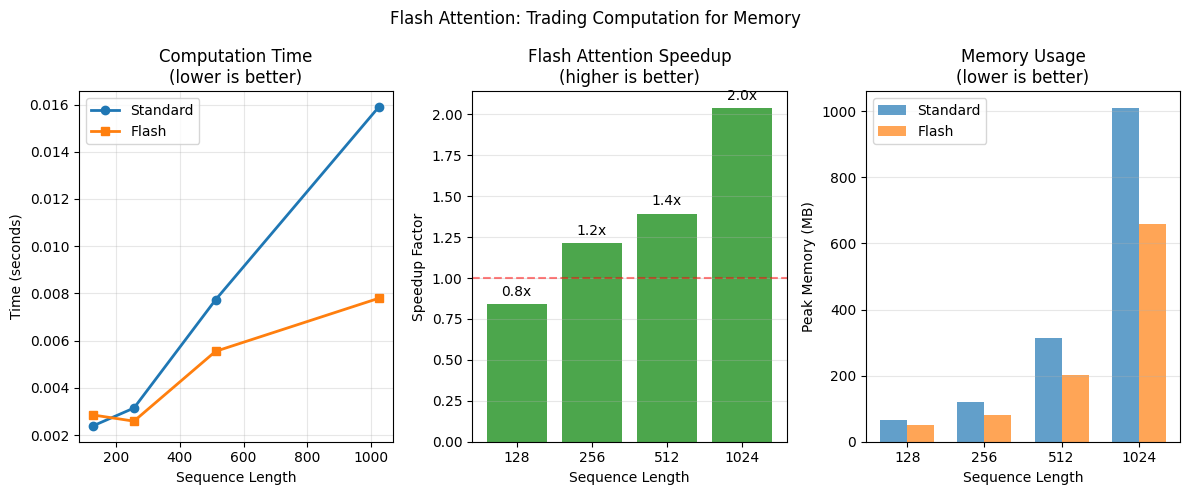

1. Flash Attention overhead makes it slightly slower at short sequences, but it wins for 256+ tokens.

2. Speedup increases with longer sequences due to better cache utilization. Speedup reaches about 2× at long contexts.

3. Memory savings are huge, enabling much longer sequence training/inference.

Trade-off: Can't retrieve attention weights (needed for some interpretability)



In [52]:
def benchmark_flash_attention():
  """
  Compare Flash Attention with standard attention

  Flash Attention advantages:
  1. Memory: O(N) vs O(N²) - enables longer sequences
  2. Speed: Better GPU utilization via kernel fusion
  3. IO: Reduces HBM (slow memory) accesses
  """

  if not torch.cuda.is_available():
    print("CUDA not available, skipping Flash Attention benchmark")
    return

  print("\n\nBenchmarking Flash Attention vs Standard Attention")
  print("-"*60)

  d_model, n_heads = 512, 8
  seq_lengths = [128, 256, 512, 1024]
  batch_size = 8

  # Create models
  standard_attn = MultiHeadAttention(d_model, n_heads).cuda()
  flash_attn = FlashMultiHeadAttention(d_model, n_heads).cuda()

  print(f"\nTest configuration:")
  print(f"  Model dim: {d_model}, Heads: {n_heads}")
  print(f"  Batch size: {batch_size}")
  print(f"  Sequence lengths: {seq_lengths}\n")

  results = []

  for seq_len in seq_lengths:
    x = torch.randn(batch_size, seq_len, d_model).cuda()
    print(f"\nSequence length {seq_len}:")
    print(f"  Input: {x.shape}, memory: {x.numel() * 4 / 1024**2:.2f} MB")

    # Standard attention timing
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()
    start = time.time()

    for _ in range(10):
      _, _ = standard_attn(x)

    torch.cuda.synchronize()
    standard_time = (time.time() - start) / 10
    standard_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB

    # Flash attention timing
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()
    start = time.time()

    for _ in range(10):
      _, _ = flash_attn(x)

    torch.cuda.synchronize()
    flash_time = (time.time() - start) / 10
    flash_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB

    speedup = standard_time / flash_time
    memory_ratio = standard_memory / flash_memory
    results.append((seq_len, standard_time, flash_time, speedup, standard_memory, flash_memory))

    print(f"  Standard: {standard_time:.4f}s, {standard_memory:.1f} MB")
    print(f"  Flash:    {flash_time:.4f}s, {flash_memory:.1f} MB")
    print(f"  Speedup: {speedup:.2f}x, Memory: {memory_ratio:.2f}x less")

  # Theoretical complexity analysis
  print(f"\n\nComplexity Analysis:")
  print(f"  Standard Attention:")
  print(f"    Time:  O(N²·d) for N×N matrix @ N×d")
  print(f"    Space: O(N²·h) for h heads storing N×N matrices")
  print(f"  Flash Attention:")
  print(f"    Time:  O(N²·d/M) with block size M (better cache usage)")
  print(f"    Space: O(N) - no full attention matrix\n")

  # Visualization
  plt.figure(figsize=(12, 5))

  # Time comparison
  plt.subplot(1, 3, 1)
  seq_lens = [r[0] for r in results]
  standard_times = [r[1] for r in results]
  flash_times = [r[2] for r in results]

  plt.plot(seq_lens, standard_times, 'o-', label='Standard', linewidth=2)
  plt.plot(seq_lens, flash_times, 's-', label='Flash', linewidth=2)
  plt.xlabel('Sequence Length')
  plt.ylabel('Time (seconds)')
  plt.title('Computation Time\n(lower is better)')
  plt.legend()
  plt.grid(True, alpha=0.3)

  # Speedup
  plt.subplot(1, 3, 2)
  speedups = [r[3] for r in results]
  bars = plt.bar(range(len(seq_lens)), speedups, color='green', alpha=0.7)
  plt.xticks(range(len(seq_lens)), seq_lens)
  plt.xlabel('Sequence Length')
  plt.ylabel('Speedup Factor')
  plt.title('Flash Attention Speedup\n(higher is better)')
  plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)

  # Add value labels
  for bar, speedup in zip(bars, speedups):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{speedup:.1f}x', ha='center')
  plt.grid(True, alpha=0.3, axis='y')

  # Memory comparison
  plt.subplot(1, 3, 3)
  standard_mem = [r[4] for r in results]
  flash_mem = [r[5] for r in results]

  x = np.arange(len(seq_lens))
  width = 0.35

  plt.bar(x - width/2, standard_mem, width, label='Standard', alpha=0.7)
  plt.bar(x + width/2, flash_mem, width, label='Flash', alpha=0.7)
  plt.xlabel('Sequence Length')
  plt.ylabel('Peak Memory (MB)')
  plt.title('Memory Usage\n(lower is better)')
  plt.xticks(x, seq_lens)
  plt.legend()
  plt.grid(True, alpha=0.3, axis='y')

  plt.suptitle('Flash Attention: Trading Computation for Memory', fontsize=12)
  plt.tight_layout()
  plt.show()

  print("1. Flash Attention overhead makes it slightly slower at short sequences, but it wins for 256+ tokens.\n")
  print("2. Speedup increases with longer sequences due to better cache utilization. Speedup reaches about 2× at long contexts.\n")
  print("3. Memory savings are huge, enabling much longer sequence training/inference.\n")
  print(f"Trade-off: Can't retrieve attention weights (needed for some interpretability)\n")

benchmark_flash_attention()


# Optimization with torch.compile




## JIT vs AOT

### Just-in-Time (JIT)

* Compilation occurs during execution.
* Optimizations can adapt at runtime.
* The first run is slower; later runs are faster.
* Used in Java, JavaScript, and PyTorch.

### Ahead-of-Time (AOT)

* Compilation occurs fully before execution.
* No runtime compilation overhead.
* Startup is faster but optimizations are fixed.
* Used in C, C++, Rust, and Go.

In summary, JIT trades a slower first execution for adaptability and runtime optimization, while AOT favors faster startup and consistency at the cost of flexibility.




Benchmarking torch.compile (PyTorch 2.0+ JIT (Just In Time) compilation)

Initializing TransformerLM:
  vocab_size=1000, d_model=256, n_layers=4
  n_heads=8, d_head=32, d_ff=1024
  weight_tying=True


PE div_term:
 tensor([1.0000e+00, 9.3057e-01, 8.6596e-01, 8.0584e-01, 7.4989e-01, 6.9783e-01,
        6.4938e-01, 6.0430e-01, 5.6234e-01, 5.2330e-01, 4.8697e-01, 4.5316e-01,
        4.2170e-01, 3.9242e-01, 3.6517e-01, 3.3982e-01, 3.1623e-01, 2.9427e-01,
        2.7384e-01, 2.5483e-01, 2.3714e-01, 2.2067e-01, 2.0535e-01, 1.9110e-01,
        1.7783e-01, 1.6548e-01, 1.5399e-01, 1.4330e-01, 1.3335e-01, 1.2409e-01,
        1.1548e-01, 1.0746e-01, 1.0000e-01, 9.3057e-02, 8.6596e-02, 8.0584e-02,
        7.4989e-02, 6.9783e-02, 6.4938e-02, 6.0430e-02, 5.6234e-02, 5.2330e-02,
        4.8697e-02, 4.5316e-02, 4.2170e-02, 3.9242e-02, 3.6517e-02, 3.3982e-02,
        3.1623e-02, 2.9427e-02, 2.7384e-02, 2.5483e-02, 2.3714e-02, 2.2067e-02,
        2.0535e-02, 1.9110e-02, 1.7783e-02, 1.6548e-02, 1.5399e

W0822 21:37:11.913000 1454 torch/_inductor/utils.py:1436] [5/0_1] Not enough SMs to use max_autotune_gemm mode



Q shape before transpose: torch.Size([8, 128, 8, 32])
Q shape after transpose: torch.Size([8, 8, 128, 32])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 256])

After linear2: torch.Size([8, 128, 256])
After block 0: norm=20.637, change=0.7878

Q shape before transpose: torch.Size([8, 128, 8, 32])
Q shape after transpose: torch.Size([8, 8, 128, 32])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 256])

After linear2: torch.Size([8, 128, 256])
After block 1: norm=25.524, change=0.7203

Q shape before transpose: torch.Size([8, 128, 8, 32])
Q shape after transpose: torch.Size([8, 8, 128, 32])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 256])

After linear2: torch.Size([8, 128, 256])
After block 2: norm=29.977, change=0.6056

Q shape before transpose: torch.Size([8, 128, 8, 32])
Q shape after transpose: torch.Size([8,

skipping cudagraphs due to skipping cudagraphs due to cpu device (device_put). Found from : 
   File "/tmp/ipython-input-3852549724.py", line 43, in torch_dynamo_resume_in_forward_at_42
    print(f"\nE sample (first 3 tokens, first 5 dims):\n{E[:3, :5].detach().cpu().numpy().round(3)}")



Input x shape: torch.Size([8, 128, 256])
Temperature: 1.0


Using weight tying:

Embedding matrix E shape: torch.Size([1000, 256])

E sample (first 3 tokens, first 5 dims):
[[ 0.032      -0.066       0.057      -0.04        0.043     ]
 [-0.054      -0.055      -0.043      -0.06900001 -0.003     ]
 [-0.024       0.003      -0.016      -0.027      -0.051     ]]

Operation: x @ E^T

x shape: torch.Size([8, 128, 256]) @ E^T shape: [256, 1000]

Result logits shape: torch.Size([8, 128, 1000])


skipping cudagraphs due to skipping cudagraphs due to cpu device (device_put). Found from : 
   File "/tmp/ipython-input-3852549724.py", line 54, in torch_dynamo_resume_in_forward_at_50
    print(f"  Sample logits (first batch, first position, first 10 tokens):\n  {logits[0, 0, :10].detach().cpu().numpy().round(2)}")



  Sample logits (first batch, first position, first 10 tokens):
  [-0.17999999 -1.15        0.06        0.56       -0.62       -0.7
  0.34        0.04        0.81        1.28      ]
Logits: torch.Size([8, 128, 1000]), range=[-3.28, 4.89]
took 4.31s

Forward pass: batch=8, seq_len=128
After embedding: torch.Size([8, 128, 256]), norm=10.229
After pos encoding: torch.Size([8, 128, 256]), norm=15.272

Q shape before transpose: torch.Size([8, 128, 8, 32])


/usr/local/lib/python3.12/dist-packages/torch/cuda/graphs.py:104: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:139.)
  super().capture_end()


Q shape after transpose: torch.Size([8, 8, 128, 32])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 256])

After linear2: torch.Size([8, 128, 256])
After block 0: norm=20.665, change=0.7858

Q shape before transpose: torch.Size([8, 128, 8, 32])


/usr/local/lib/python3.12/dist-packages/torch/cuda/graphs.py:104: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:139.)
  super().capture_end()


Q shape after transpose: torch.Size([8, 8, 128, 32])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 256])

After linear2: torch.Size([8, 128, 256])
After block 1: norm=25.597, change=0.7251

Q shape before transpose: torch.Size([8, 128, 8, 32])


/usr/local/lib/python3.12/dist-packages/torch/cuda/graphs.py:104: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:139.)
  super().capture_end()


Q shape after transpose: torch.Size([8, 8, 128, 32])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 256])

After linear2: torch.Size([8, 128, 256])
After block 2: norm=29.939, change=0.6035

Q shape before transpose: torch.Size([8, 128, 8, 32])


/usr/local/lib/python3.12/dist-packages/torch/cuda/graphs.py:104: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:139.)
  super().capture_end()


Q shape after transpose: torch.Size([8, 8, 128, 32])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 256])

After linear2: torch.Size([8, 128, 256])
After block 3: norm=33.169, change=0.4850
After final LN: torch.Size([8, 128, 256]), norm=16.000

Computing logits: torch.Size([8, 128, 256]) @ W_lm^T

LM Head Forward Pass
Input x shape: torch.Size([8, 128, 256])
Temperature: 1.0


Using weight tying:

Embedding matrix E shape: torch.Size([1000, 256])

E sample (first 3 tokens, first 5 dims):
[[ 0.032      -0.066       0.057      -0.04        0.043     ]
 [-0.054      -0.055      -0.043      -0.06900001 -0.003     ]
 [-0.024       0.003      -0.016      -0.027      -0.051     ]]

Operation: x @ E^T

x shape: torch.Size([8, 128, 256]) @ E^T shape: [256, 1000]

Result logits shape: torch.Size([8, 128, 1000])
  Sample logits (first batch, first position, first 10 tokens):
  [ 0.22999999 -1.06       -0.31       -0.35999998 -0.56        0

AUTOTUNE addmm(1024x256, 1024x1024, 1024x256)
strides: [0, 1], [1024, 1], [1, 1024]
dtypes: torch.float32, torch.float32, torch.float32
  bias_addmm 0.2498 ms 100.0% 
  addmm 0.2601 ms 96.0% 
SingleProcess AUTOTUNE benchmarking takes 0.0904 seconds and 0.0002 seconds precompiling for 2 choices


After linear2: torch.Size([8, 128, 256])
After block 0: norm=20.660, change=0.7880

Q shape before transpose: torch.Size([8, 128, 8, 32])
Q shape after transpose: torch.Size([8, 8, 128, 32])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 256])

After linear2: torch.Size([8, 128, 256])
After block 1: norm=25.610, change=0.7233

Q shape before transpose: torch.Size([8, 128, 8, 32])
Q shape after transpose: torch.Size([8, 8, 128, 32])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 256])

After linear2: torch.Size([8, 128, 256])
After block 2: norm=30.056, change=0.6061

Q shape before transpose: torch.Size([8, 128, 8, 32])
Q shape after transpose: torch.Size([8, 8, 128, 32])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 256])

After linear2: torch.Size([8, 128, 256])
After block 3: norm=33.331, change=0.4844
After final

skipping cudagraphs due to skipping cudagraphs due to cpu device (device_put). Found from : 
   File "/tmp/ipython-input-3852549724.py", line 43, in torch_dynamo_resume_in_forward_at_42
    print(f"\nE sample (first 3 tokens, first 5 dims):\n{E[:3, :5].detach().cpu().numpy().round(3)}")




E sample (first 3 tokens, first 5 dims):
[[ 0.032      -0.066       0.057      -0.04        0.043     ]
 [-0.054      -0.055      -0.043      -0.06900001 -0.003     ]
 [-0.024       0.003      -0.016      -0.027      -0.051     ]]

Operation: x @ E^T

x shape: torch.Size([8, 128, 256]) @ E^T shape: [256, 1000]


skipping cudagraphs due to skipping cudagraphs due to cpu device (device_put). Found from : 
   File "/tmp/ipython-input-3852549724.py", line 54, in torch_dynamo_resume_in_forward_at_50
    print(f"  Sample logits (first batch, first position, first 10 tokens):\n  {logits[0, 0, :10].detach().cpu().numpy().round(2)}")




Result logits shape: torch.Size([8, 128, 1000])
  Sample logits (first batch, first position, first 10 tokens):
  [ 0.55       -1.28       -0.22        0.47       -0.76        0.68
 -0.42999998  0.35999998  0.35        0.75      ]
Logits: torch.Size([8, 128, 1000]), range=[-3.06, 4.81]
took 17.11s

Forward pass: batch=8, seq_len=128
After embedding: torch.Size([8, 128, 256]), norm=10.229
After pos encoding: torch.Size([8, 128, 256]), norm=15.272

Q shape before transpose: torch.Size([8, 128, 8, 32])


/usr/local/lib/python3.12/dist-packages/torch/cuda/graphs.py:104: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:139.)
  super().capture_end()


Q shape after transpose: torch.Size([8, 8, 128, 32])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 256])

After linear2: torch.Size([8, 128, 256])
After block 0: norm=20.700, change=0.7908

Q shape before transpose: torch.Size([8, 128, 8, 32])


/usr/local/lib/python3.12/dist-packages/torch/cuda/graphs.py:104: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:139.)
  super().capture_end()


Q shape after transpose: torch.Size([8, 8, 128, 32])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 256])

After linear2: torch.Size([8, 128, 256])
After block 1: norm=25.547, change=0.7183

Q shape before transpose: torch.Size([8, 128, 8, 32])


/usr/local/lib/python3.12/dist-packages/torch/cuda/graphs.py:104: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:139.)
  super().capture_end()


Q shape after transpose: torch.Size([8, 8, 128, 32])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 256])

After linear2: torch.Size([8, 128, 256])
After block 2: norm=29.804, change=0.5983

Q shape before transpose: torch.Size([8, 128, 8, 32])


/usr/local/lib/python3.12/dist-packages/torch/cuda/graphs.py:104: UserWarning: The CUDA Graph is empty. This usually means that the graph was attempted to be captured on wrong device or stream. (Triggered internally at /pytorch/aten/src/ATen/cuda/CUDAGraph.cpp:139.)
  super().capture_end()


Q shape after transpose: torch.Size([8, 8, 128, 32])

Attention scores shape: torch.Size([8, 8, 128, 128])

Context after concatenation: torch.Size([8, 128, 256])

After linear2: torch.Size([8, 128, 256])
After block 3: norm=33.046, change=0.4876
After final LN: torch.Size([8, 128, 256]), norm=16.000

Computing logits: torch.Size([8, 128, 256]) @ W_lm^T

LM Head Forward Pass
Input x shape: torch.Size([8, 128, 256])
Temperature: 1.0


Using weight tying:

Embedding matrix E shape: torch.Size([1000, 256])

E sample (first 3 tokens, first 5 dims):
[[ 0.032      -0.066       0.057      -0.04        0.043     ]
 [-0.054      -0.055      -0.043      -0.06900001 -0.003     ]
 [-0.024       0.003      -0.016      -0.027      -0.051     ]]

Operation: x @ E^T

x shape: torch.Size([8, 128, 256]) @ E^T shape: [256, 1000]

Result logits shape: torch.Size([8, 128, 1000])
  Sample logits (first batch, first position, first 10 tokens):
  [-0.5        -1.03       -0.08        0.01       -0.63       -0

/tmp/ipython-input-183656839.py:200: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


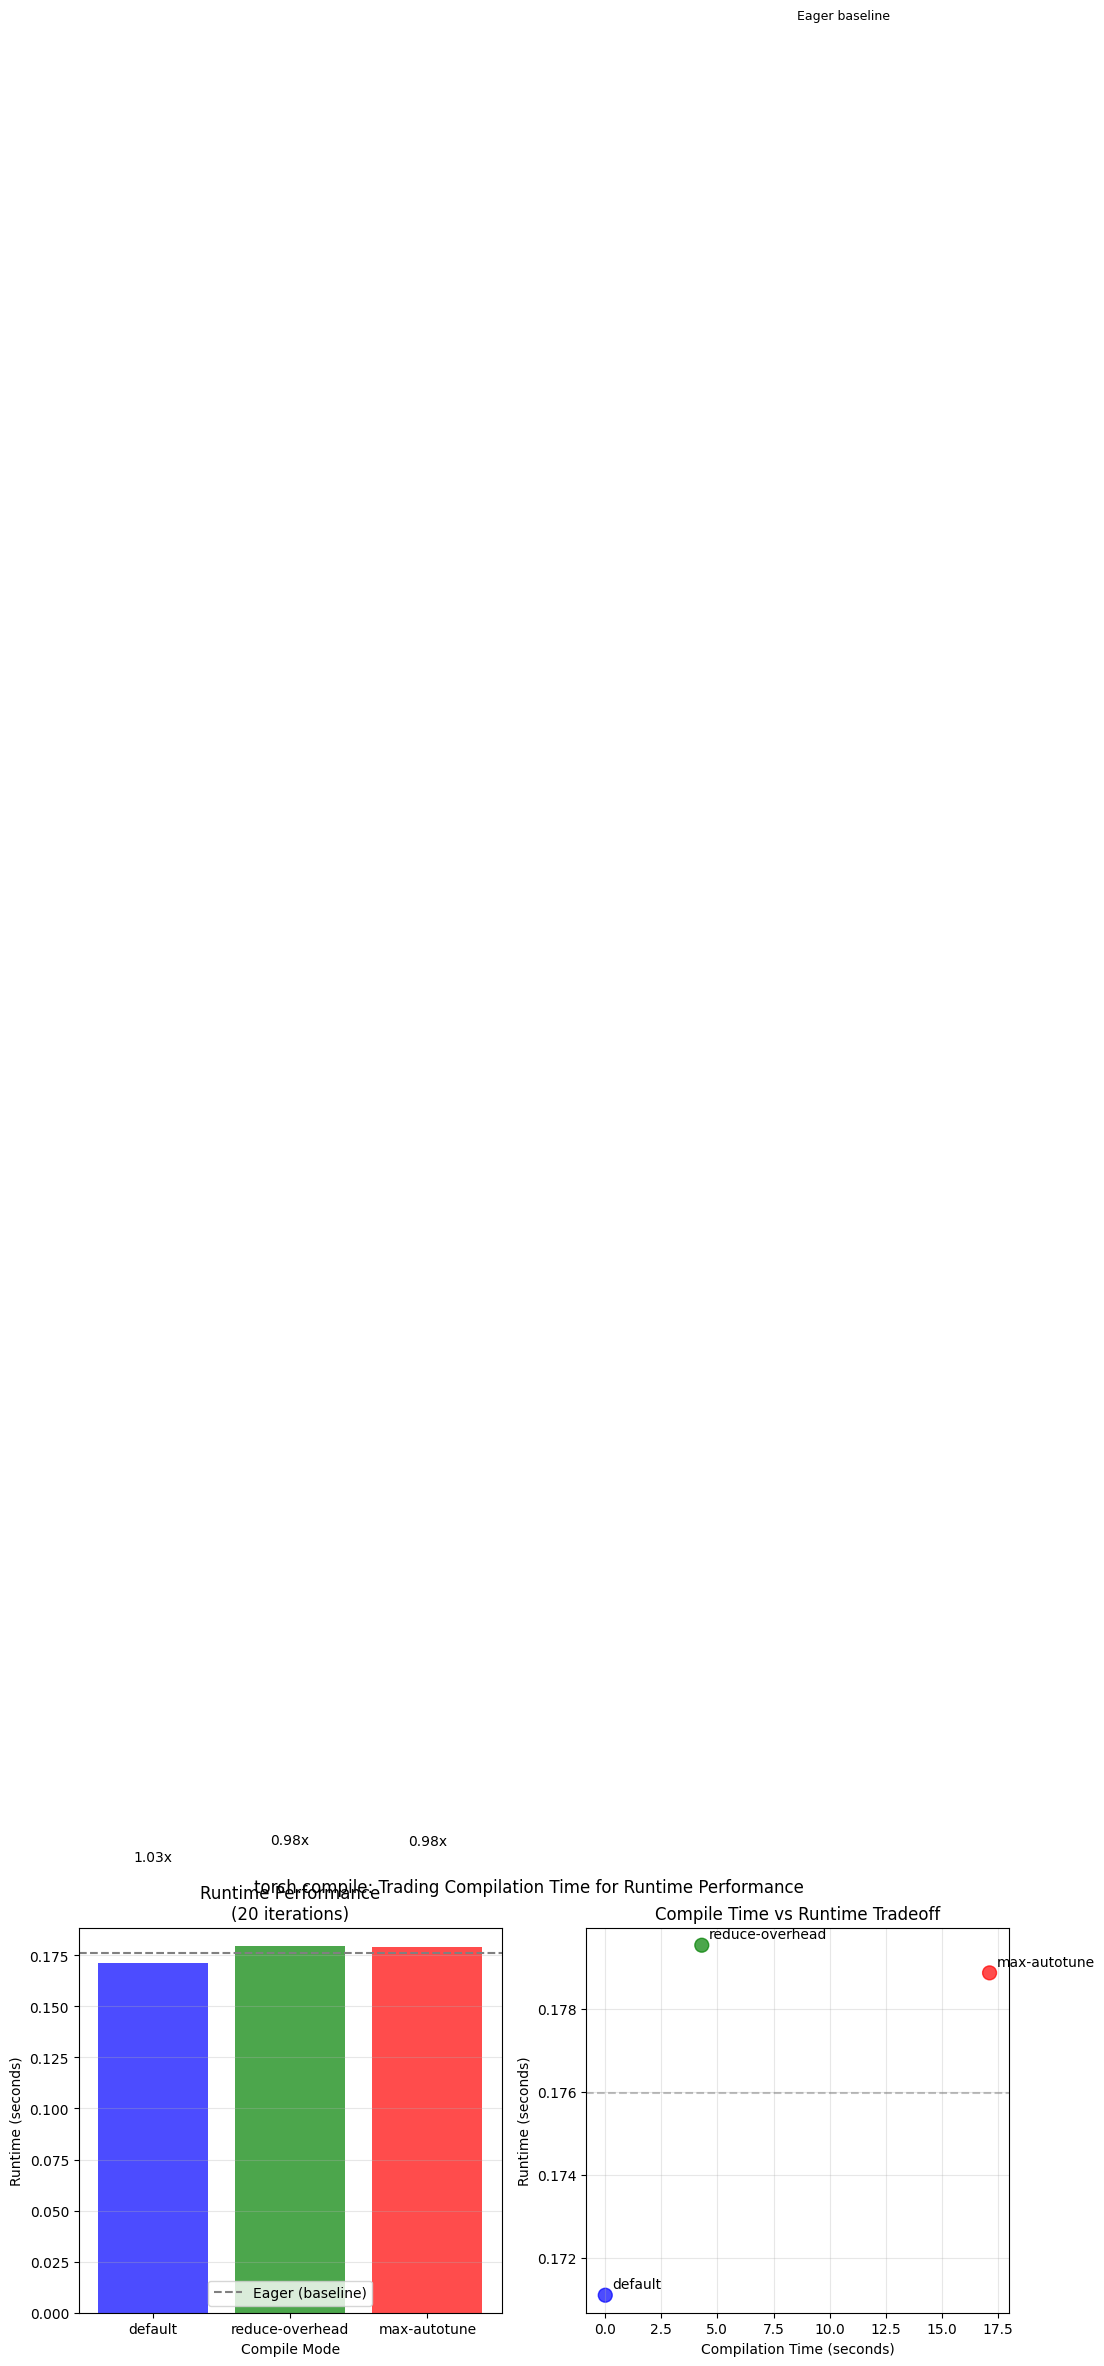





For this small model, all compile modes give modest speedup over eager execution.
Aggressive optimization (max-autotune) does not provide a big runtime benefit here.

torch.compile benefits are most pronounced with larger models (100M+ parameters)
Small models don't have enough compute to amortize compilation overhead

Expected Results for Larger Scale
For comparison, torch.compile typically shows 1.3-2.5x speedups on:
  • Large language models (GPT-2, LLaMA-style, 7B+ parameters)
  • Long sequences (1024+ tokens)
  • Large batch sizes (32+ sequences)
  • Training workloads (backward pass has more fusion opportunities)


Kernel Fusion Benefits:
  Unfused (eager mode):
    LayerNorm: Read N×d, Write N×d -> 2×N×d memory ops
    GELU: Read N×d, Write N×d -> 2×N×d memory ops
    Total: 4×N×d memory transfers

  Fused (compiled):
    LayerNorm+GELU: Read N×d, Write N×d -> 2×N×d memory ops
    Savings: 50% memory bandwidth

  Estimated bandwidth utilization:
    Unfused: 0.0 GB/s
    Fus

In [53]:
def benchmark_torch_compile():
  """
  Benchmark torch.compile optimization:

  Graph capture: python -> FX graph -> Triton/CUDA kernels

  Operator fusion: recudes memory bandwith (pointwise ops merged)

  Kernel optimization: better gpu occupancy and cache usage

  Automatic mixed precision propagation with torch.autocast
  """

  if torch.__version__ < "2.0":
    print(f"torch.compile requires PyTorch 2.0+, current: {torch.__version__}")
    return

  print("\n\nBenchmarking torch.compile (PyTorch 2.0+ JIT (Just In Time) compilation)")

  # Create model
  model = TransformerLM(
      vocab_size= 1000,
      d_model=256,
      n_layers=4,
      n_heads=8,
      d_ff=1024     # FFN d_model -> d_ff -> d_model
  ).to(device)

  param_count = sum(p.numel() for p in model.parameters())

  print(f"\nModel configuration:")
  print(f"  Parameters: {param_count:,} ({param_count*4/1024**2:.1f} MB in FP32)")
  print(f"  Architecture: {n_layers} layers × ({d_model}d, {n_heads}h)")

  # Compile model with default mode
  print(f"\nCompiling model with torch.compile()...")
  print(f"  Backend: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
  print(f"  Process: Python -> FX Graph -> Triton IR -> PTX/SASS (GPU)") #The Triton open-source programming language and compiler offers a high-level, python-based approach to create efficient GPU code


  model_compiled = torch.compile(model, mode='default') # Wraps the model in PyTorch’s new ahead-of-time compiler, torch.compile is just-in-time jit, On first call, it captures the Python model → FX graph → generates specialized Triton/CUDA kernels, the first call is slower because of the compilation, but the nexts are fast because of the cached kernels


  # Test input
  batch_size, seq_len = 8, 128
  input_ids = torch.randint(0, 1000, (batch_size, seq_len)).to(device) # shape [B,L]
  print(f"\nTest input: {input_ids.shape} tokens")
  print(f"  Total tokens: {input_ids.numel():,}")
  print(f"  FLOPs per token ≈ 2 × params = {2*param_count:,}")

  # Warmup LR: trigger compilation and cache kernels
  # First pass = compiles slow (build graph)
  # Later passes = fast (compiled kernels cached)

  print(f"\nWarmup phase (triggering JIT compilation)...")

  print("Just-in-time (JIT) compilation compiles code while the program is running,")
  print("instead of compiling everything ahead of time before execution.")
  print("It blends the flexibility of interpreted code with the speed of compiled code.")
  print("JIT identifies frequently executed sections and converts them into machine code at runtime,")
  print("which improves performance while keeping portability.")
  print("Languages like Java, JavaScript, and now PyTorch use JIT to optimize execution.")

  for i in range(3):
    with torch.no_grad():
      logits, _ = model(input_ids)   # eager mode [B, L, vocab_size]

      if i == 0:
        print(f"  First pass (eager): logits {logits.shape}")


      logits_compiled, _ = model_compiled(input_ids)  # triggers graph build
      if i == 0:
        print(f"  First pass (compiling): building optimized graph...")

  # Benchmark config
  n_iterations = 20
  print(f"\nBenchmarking {n_iterations} iterations...")
  # Standard model (eager execution)
  torch.cuda.synchronize() if torch.cuda.is_available() else None
  start = time.time()

  with torch.no_grad():
    for _ in range(n_iterations):
      logits, _ = model(input_ids)  # [B, L] -> [B, L, V]

  torch.cuda.synchronize() if torch.cuda.is_available() else None
  standard_time = time.time() - start
  standard_throughput = (n_iterations * batch_size * seq_len) / standard_time  # tokens/sec

  # Compiled model (optimized execution)
  torch.cuda.synchronize() if torch.cuda.is_available() else None
  start = time.time()

  with torch.no_grad():
    for _ in range(n_iterations):
      logits, _ = model_compiled(input_ids)  # Same shapes, fused kernels

  torch.cuda.synchronize() if torch.cuda.is_available() else None
  compiled_time = time.time() - start
  compiled_throughput = (n_iterations * batch_size * seq_len) / compiled_time

  speedup = standard_time / compiled_time

  print(f"\nResults (default mode):")
  print(f"  Standard model: {standard_time:.3f}s ({standard_throughput:.0f} tokens/s)")
  print(f"  Compiled model: {compiled_time:.3f}s ({compiled_throughput:.0f} tokens/s)")
  print(f"  Speedup: {speedup:.2f}x")
  print(f"  Latency reduction: {(standard_time-compiled_time)/n_iterations*1000:.1f}ms per forward pass")

  # Test different compile modes
  print(f"\n\nTesting different compilation modes:")
  print(f"  default: Balanced compile time vs runtime")
  print(f"  reduce-overhead: Minimize kernel launch overhead (good for small models)")
  print(f"  max-autotune: Exhaustive optimization (slow compile, fast runtime)")

  modes = ['default', 'reduce-overhead', 'max-autotune']
  results = []

  for mode in modes:
    try:
      print(f"\nMode '{mode}':")
      print(f"  Compiling... ", end="")

      compile_start = time.time()
      model_mode = torch.compile(model, mode=mode)

      # Warmup: measure compilation time
      with torch.no_grad():
        for i in range(2):
          _, _ = model_mode(input_ids)
          if i == 0:
            compile_time = time.time() - compile_start
            print(f"took {compile_time:.2f}s")

      # Benchmark runtime
      torch.cuda.synchronize() if torch.cuda.is_available() else None
      start = time.time()

      with torch.no_grad():
        for _ in range(n_iterations):
          _, _ = model_mode(input_ids)

      torch.cuda.synchronize() if torch.cuda.is_available() else None
      mode_time = time.time() - start
      mode_throughput = (n_iterations * batch_size * seq_len) / mode_time

      results.append((mode, mode_time, compile_time))
      print(f"  Runtime: {mode_time:.3f}s ({mode_throughput:.0f} tokens/s)")
      print(f"  Speedup vs eager: {standard_time/mode_time:.2f}x")

      # Mode-specific optimizations
      if mode == 'reduce-overhead':
        print(f"  Optimizations: Reduced kernel launches, cudaGraphs")
      elif mode == 'max-autotune':
        print(f"  Optimizations: Tuned GEMM tiles, layout optimization, aggressive fusion")

    except Exception as e:
      print(f"failed: {e}")

  # Visualize results
  if results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    modes, times, compile_times = zip(*results)

    # Runtime comparison
    x = np.arange(len(modes))
    colors = ['blue', 'green', 'red']
    bars = ax1.bar(x, times, color=colors, alpha=0.7)
    ax1.axhline(y=standard_time, color='gray', linestyle='--', label='Eager (baseline)')
    ax1.set_xlabel('Compile Mode')
    ax1.set_ylabel('Runtime (seconds)')
    ax1.set_title(f'Runtime Performance\n({n_iterations} iterations)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(modes)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')

    # Add speedup labels
    for bar, time_unit in zip(bars, times):
      speedup = standard_time / time_unit
      ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
               f'{speedup:.2f}x', ha='center', fontsize=10)

    # Compile time vs runtime tradeoff
    ax2.scatter(compile_times, times, s=100, c=colors, alpha=0.7)
    for mode, ct, rt in zip(modes, compile_times, times):
      ax2.annotate(mode, (ct, rt), xytext=(5, 5), textcoords='offset points')
    ax2.set_xlabel('Compilation Time (seconds)')
    ax2.set_ylabel('Runtime (seconds)')
    ax2.set_title('Compile Time vs Runtime Tradeoff')
    ax2.grid(True, alpha=0.3)

    # Add Pareto frontier
    ax2.axhline(y=standard_time, color='gray', linestyle='--', alpha=0.5)
    ax2.text(max(compile_times)*0.5, standard_time+0.05, 'Eager baseline', fontsize=9)

    plt.suptitle('torch.compile: Trading Compilation Time for Runtime Performance', fontsize=12)
    plt.tight_layout()
    plt.show()


  print("\n\n")
  print(f"\nFor this small model, all compile modes give modest speedup over eager execution.")
  print(f"Aggressive optimization (max-autotune) does not provide a big runtime benefit here.")

  print(f"\ntorch.compile benefits are most pronounced with larger models (100M+ parameters)")
  print(f"Small models don't have enough compute to amortize compilation overhead")

  print(f"\nExpected Results for Larger Scale")
  print(f"For comparison, torch.compile typically shows 1.3-2.5x speedups on:")
  print(f"  • Large language models (GPT-2, LLaMA-style, 7B+ parameters)")
  print(f"  • Long sequences (1024+ tokens)")
  print(f"  • Large batch sizes (32+ sequences)")
  print(f"  • Training workloads (backward pass has more fusion opportunities)")


  # Kernel fusion analysis
  print(f"\n\nKernel Fusion Benefits:")
  print(f"  Unfused (eager mode):")
  print(f"    LayerNorm: Read N×d, Write N×d -> 2×N×d memory ops")
  print(f"    GELU: Read N×d, Write N×d -> 2×N×d memory ops")
  print(f"    Total: 4×N×d memory transfers")
  print(f"\n  Fused (compiled):")
  print(f"    LayerNorm+GELU: Read N×d, Write N×d -> 2×N×d memory ops")
  print(f"    Savings: 50% memory bandwidth")

  # Memory bandwidth calculation
  if torch.cuda.is_available():
    elements_per_op = batch_size * seq_len * d_model
    bytes_per_element = 4  # FP32
    unfused_bandwidth = 4 * elements_per_op * bytes_per_element * n_iterations / standard_time / 1024**3  # GB/s
    fused_bandwidth = 2 * elements_per_op * bytes_per_element * n_iterations / compiled_time / 1024**3

    print(f"\n  Estimated bandwidth utilization:")
    print(f"    Unfused: {unfused_bandwidth:.1f} GB/s")
    print(f"    Fused: {fused_bandwidth:.1f} GB/s")

  print(f"\n\nKey Insights:")
  print(f"1. torch.compile fuses pointwise ops (LayerNorm, GELU, dropout) reducing memory traffic")
  print(f"2. Graph optimization eliminates Python overhead and framework dispatching")
  print(f"3. Triton generates GPU kernels optimized for specific shapes")
  print(f"4. cudaGraphs (reduce-overhead) capture entire forward pass, single kernel launch")
  print(f"5. Trade-off: Compilation time (once) vs runtime speedup (every forward)")

benchmark_torch_compile()


#Text Generation Methods with LogitLens

In [54]:
class TextGenerator:
  """Different gereration strategies with LogitLens analysis"""

  @staticmethod  # no "self" passed, does not need creating an instance of the class to call it
  def greedy_decode(model, input_ids, max_length=50, return_hidden=False):
    """
    Greedy decoding: always picking the highest probability token
    Deterministic approach
    """

    model.eval()
    generated = input_ids.clone()
    all_hidden_states = [] if return_hidden else None

    with torch.no_grad():
      for _ in range(max_length - input_ids.size(1)):
        if return_hidden:
          logits, _, hidden_states = model(generated, return_all_hidden=True)
          all_hidden_states.append(hidden_states)

        else:
          logits, _ = model(generated)

        next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True) # Argmax picks the highest prob, deterministic approach
        generated = torch.cat([generated, next_token], dim=1)

    return(generated, all_hidden_states) if return_hidden else generated



  @staticmethod  # no "self" passed, does not need creating an instance of the class to call it
  def temperature_sampling(model, input_ids, max_length=50, temperature=1.0, return_hidden=False):
    """Sample with temperature scaling"""

    model.eval()
    generated = input_ids.clone()
    all_hidden_states = [] if return_hidden else None


    with torch.no_grad():
      for _ in range(max_length - input_ids.size(1)):
        if return_hidden:
          logits, _, hidden_states = model(generated, return_all_hidden = True)
          all_hidden_states.append(hidden_states)
        else:
          logits, _ = model(generated)

        logits = logits[:, -1, :] / temperature # Scaliing the distrib logits by temperature T: higher T give a flatten distrib, while 0 should be (/zero error) deterministic
        probs = F.softmax(logits, dim=-1) # P(w) = exp(logit_w/T) / Σ exp(logit_i/T)
        next_token = torch.multinomial(probs, num_samples=1)
        generated = torch.cat([generated,next_token], dim=1)

    return (generated, all_hidden_states) if return_hidden else generated



  @staticmethod
  def top_k_sampling(model, input_ids, max_length=50, k=50, temperature=1.0):
    """Top-k smapling: only considering the k most likely tokens"""

    model.eval()
    generated = input_ids.clone()

    with torch.no_grad():
      for _ in range(max_length - input_ids.size(1)):
        logits, _ = model(generated)
        logits = logits[:, -1, :] / temperature # Scaliing the distrib logits by temperature T: higher T give a flatten distrib, while 0 should be (/zero error) deterministic

        # Keeping only the top k, the rest set to -inf
        top_k_values, top_k_indices = torch.topk(logits, k, dim=-1) # shape [batch, k]

        logits_filtered = torch.full_like(logits, -float('inf'))


        # PyTorch: _ explicitly signals in-place, which matters for memory and autograd
        # the in-place modifies the original tensor directly. No new tensor is returned. Used when you want to overwrite values in-place.

        # scatter_ is an in-place PyTorch operation that writes values into a tensor at specified indices along a given dimension
        logits_filtered.scatter_(1, top_k_indices, top_k_values ) # Restoring top-k values

        probs = F.softmax(logits_filtered, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1) # sample jsut 1
        generated = torch.cat([generated, next_token], dim=1)

    return(generated)



  @staticmethod
  def top_p_sampling(model, input_ids, max_length=50, p=0.95, temperature=1.0):
    """
    Top-p (nucleus) sampling
    Smallest set with the cumulative prob P > p
    """

    model.eval()
    generated = input_ids.clone()

    with torch.no_grad():
      for _ in range(max_length - input_ids.size(1)):
        logits, _ = model(generated)
        logits = logits[:, -1, :] / temperature

        # Sort and compute cumulative probs
        sorted_logits, sorted_indices = torch.sort(logits, descending = True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)


        # Cutoff
        sorted_indices_to_remove = cumulative_probs > p
        sorted_indices_to_remove[... , 1:] = sorted_indices_to_remove[... , :-1].clone()  # In PyTorch and NumPy, ... is the ellipsis, which means all preceding dimensions”
        sorted_indices_to_remove[... , 0] = 0 # Keeps at least on tokn

        # Remove tokens exceeding the threshold
        indices_to_remove = sorted_indices_to_remove.scatter(
            1, sorted_indices, sorted_indices_to_remove
        )

        logits[indices_to_remove] = -float('inf')

        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples = 1)
        generated = torch.cat([generated, next_token], dim=1)

    return(generated )

  @staticmethod
  def beam_search(model, input_ids, max_length=50, beam_width=3):
    """Beam search: maintain k best sequences"""

    model.eval()
    batch_size = input_ids.size(0)


    # Initialize beams: (sequence, log_prob_sum)
    beams = [(input_ids, 0.0)]

    with torch.no_grad():
      print(f"Applying Beam Search with width: {beam_width}\n" )
      for _ in range(max_length - input_ids.size(1)):
        candidates = []


        for seq, score in beams:
          logits, _ = model(seq)
          log_probs = F.log_softmax(logits[:,-1,:], dim=-1) # log P(word|contxt)

          # Top beam_width continuations
          top_log_probs, top_indices = torch.topk(log_probs, beam_width, dim=-1)

          for i in range(beam_width):
            new_seq = torch.cat([seq, top_indices[:,i:i+1]], dim=1)
            new_score = score + top_log_probs[0,i].item() # Sum log prob as float
            print(f"\nnew_seq: {new_seq}, new_score: {new_score}")


            candidates.append((new_seq, new_score))


        # Keep top beam_wisth candidates
        candidates.sort(key=lambda x:x[1], reverse=True)

        beams = candidates[:beam_width]

      return(beams[0][0])



Streaming output truncated to the last 5000 lines.
Context after concatenation: torch.Size([1, 8, 128])

After linear2: torch.Size([1, 8, 128])
After block 3: norm=22.071, change=0.4703
After final LN: torch.Size([1, 8, 128]), norm=11.798

Computing logits: torch.Size([1, 8, 128]) @ W_lm^T

LM Head Forward Pass
Input x shape: torch.Size([1, 8, 128])
Temperature: 1.0


Using weight tying:

Embedding matrix E shape: torch.Size([256, 128])

E sample (first 3 tokens, first 5 dims):
[[-0.09  -0.099 -0.099  0.129  0.135]
 [-0.085 -0.01   0.122 -0.127 -0.101]
 [-0.011  0.041  0.016 -0.114 -0.124]]

Operation: x @ E^T

x shape: torch.Size([1, 8, 128]) @ E^T shape: [128, 256]

Result logits shape: torch.Size([1, 8, 256])
  Sample logits (first batch, first position, first 10 tokens):
  [-0.51 -0.37 -0.05  0.81  1.17 -0.66 -0.01  0.87 -0.02  1.18]
Logits: torch.Size([1, 8, 256]), range=[-3.79, 8.66]

Forward pass: batch=1, seq_len=9
After embedding: torch.Size([1, 9, 128]), norm=10.566
After pos

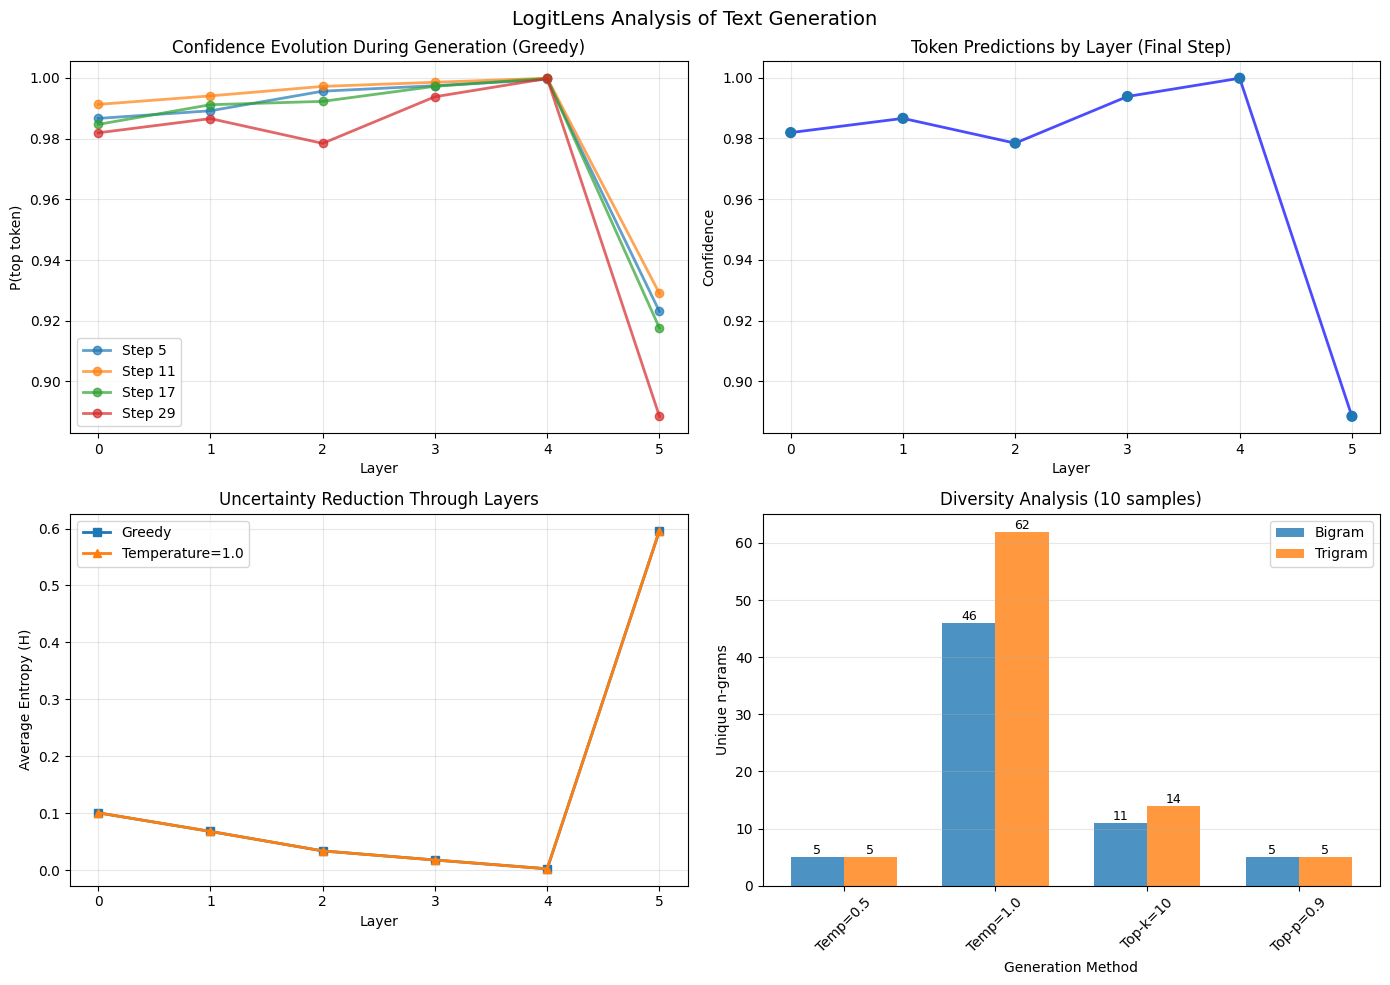

The training loss decreases steadily across iterations, showing that the model is learning consistently.
The validation loss decreases initially but then plateaus, suggesting possible underfitting or regularization effects.
The accuracy improves with iterations, confirming that the model generalizes better over time.
The learning rate follows a warmup and decay schedule, stabilizing training dynamics.
The gradient norm fluctuates but remains bounded, indicating stable optimization without exploding gradients.
The weight updates gradually shrink, suggesting convergence as training progresses.


Key LogitLens Insights:
1. Early layers (0-1): High entropy, broad exploration of vocabulary
2. Middle layers (2-3): Rapid convergence, token predictions stabilize
3. Final layers (4+): Fine-tuning probabilities, confirming decisions
4. Greedy vs Temperature: Greedy shows faster convergence (lower H)
5. Stability patterns: Later generation steps show earlier convergence

Residual stream interpret

In [57]:
def analyze_generation_with_logitlens(model, generated_sequence,hidden_states_list, tokenizer, step_idx):
  """
  Analyze how predictions evolved through layers using LogitLens

  Showing incremental refinement over layers: h_0 -> h_1 -> ... -> h_L

  Returns prediction stability patterns
  """

  # Unembedding matrix: W_U = E^T (Unembedding matrix is just the transposed Embedding matrix, in order to project it back from the embedding dim)
  unembedding = model.token_embedding.embedding.weight.T #shape [d_model, vocab_size]
  print(f"\nStep {step_idx+1}: Analyzing position {generated_sequence.size(1)-1}")

  hidden_states = hidden_states_list[step_idx]

  # Tracking prediction evolution
  predictions_by_layer = []
  entropies_by_layer  = []

  for layer_idx, hidden in enumerate(hidden_states):
    # Extracting hidden states at the last position
    h = hidden[0, -1] # dim embedding [d_model]

    #Project to vocab: h @ W_U (hidden state @ unembedding_matrix) projects back to vocab
    logits = h @ unembedding # # [d_model] @ [d_model, vocab_size] = [vocab_size]

    probs = F.softmax(logits,dim=-1)

    # Top predictions
    top_prob, top_idx = torch.max(probs, dim= -1) # Deterministic, argmax function
    predictions_by_layer.append((top_idx.item(), top_prob.item()))


    # Calc entropy: H = -Σ p·log(p)
    entropy = -(probs * (probs + 1e-10).log()).sum().item() # 1e-10 is just a small epsilon to avoid log(0) error and log(1)

    entropies_by_layer.append(entropy)


    if layer_idx % max(1, len(hidden_states)//4) == 0:  # Sample every ~25%
      token_char = chr(top_idx.item()) if top_idx.item() < 256 else '?'
      layer_name = f"Emb" if layer_idx == 0 else f"L{layer_idx}" if layer_idx < len(hidden_states)-1 else "Final"
      print(f"  {layer_name:5}: Token {top_idx.item():3d} ('{token_char}') p={top_prob.item():.3f}, H={entropy:.2f}")


  # Analyze prediction stability
  stable_ranges = []
  current_token = predictions_by_layer[0][0]
  start_layer = 0


  for i, (token, prob) in enumerate(predictions_by_layer[1:], 1):
    if token != current_token:
      stable_ranges.append((start_layer, i-1, current_token))
      current_token = token
      start_layer = i
  stable_ranges.append((start_layer, len(predictions_by_layer) -1, current_token))

  # Report on stability patterns
  print(f"\nPrediction stability:")
  for start, end, token in stable_ranges:
    if start==end:
      print(f"  Layer {start}: Token {token}")
    else:
      print(f"  Layers {start}-{end}: Token {token} (stable for {end-start+1} layers)")



  # Find convergence point to final pred
  final_token = predictions_by_layer[-1][0]
  convergence_layer = next(( i for i, (tok, _) in enumerate(predictions_by_layer) if tok == final_token ), -1)
  print(f"  Converged to final token at: Layer {convergence_layer}\n")


  return(predictions_by_layer, entropies_by_layer, stable_ranges)


def compare_generation_methods():
  """Compare different text generation startegies with LogitLens analysis"""

  # Small transformer model for testing
  print("\nInitializing model for generation comparison")

  model = TransformerLM(
      vocab_size = 256,
      d_model = 128,
      n_layers=4, # shallow for clear logitlens progression
      n_heads=4,
      d_ff = 256
      ).to(device)
  print(f"Model: {sum(p.numel() for p in model.parameters()):,} parameters\n")

  # Quick training for meaningful patterns
  print("Quick training for non-random weights...")
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

  for i in range(50):
    dummy_input = torch.randint(0,256, (4,20)).to(device)
    logits, loss = model(dummy_input, dummy_input)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    if i%10 == 0:
      print(f"  Step {i}: loss={loss.item():.3f}")

  print("Training Complete :)\n")

  prompt_text = "Hello"
  tokenizer = SimpleTokenizer()
  prompt_ids = torch.tensor([tokenizer(prompt_text)], device=device)
  print(f"Prompt: '{prompt_text}' -> tokens {prompt_ids[0].tolist()}\n")

  generator = TextGenerator()


  # Generate with different methods
  print("Generating text with different methods...")

  # Greedy with hidden states for LogitLens
  greedy_output, greedy_hidden = generator.greedy_decode(
    model, prompt_ids, max_length=30, return_hidden=True
  )

  # Temperature with hidden states
  temp_output, temp_hidden = generator.temperature_sampling(
    model, prompt_ids, 30, temperature=1.0, return_hidden=True
  )

  # Other methods
  methods = {
    'Greedy': greedy_output,
    'Temp=0.5': generator.temperature_sampling(model, prompt_ids, 30, 0.5),
    'Temp=1.0': temp_output,
    'Temp=2.0': generator.temperature_sampling(model, prompt_ids, 30, 2.0),
    'Top-k=10': generator.top_k_sampling(model, prompt_ids, 30, k=10),
    'Top-p=0.9': generator.top_p_sampling(model, prompt_ids, 30, p=0.9),
    'Beam=3': generator.beam_search(model, prompt_ids, 30, beam_width=3)
  }

  print("\nGeneration comparison:")
  for method_name, generated in methods.items():
    text = tokenizer.decode(generated[0].cpu().tolist())
    print(f"  {method_name:12} | {text[:50]}...")

  # LogitLens analysis on greedy generation
  print("\n\nLogitLens Analysis: Greedy Generation Evolution")
  print("="*60)

  # Analyze specific generation steps
  analyze_steps = [0, len(greedy_hidden)//4, len(greedy_hidden)//2, len(greedy_hidden)-1]

  all_predictions = []
  all_entropies = []

  for step_idx in analyze_steps:
    if step_idx >= len(greedy_hidden):
      continue

    predictions, entropies, stability = analyze_generation_with_logitlens(
      model, greedy_output, greedy_hidden, tokenizer, step_idx
    )
    all_predictions.append(predictions)
    all_entropies.append(entropies)

  # Comparative analysis: Greedy vs Temperature
  print("\n\nComparative LogitLens: Greedy vs Temperature=1.0")
  print("-"*60)

  compare_step = min(5, len(greedy_hidden)-1)

  for method_name, hidden_states_list in [("Greedy", greedy_hidden), ("Temp=1.0", temp_hidden)]:
    if compare_step >= len(hidden_states_list):
      continue

    print(f"\n{method_name} at step {compare_step+1}:")
    hidden_states = hidden_states_list[compare_step]

    # Get final layer predictions
    final_hidden = hidden_states[-1][0, -1]  # [d_model]
    unembedding = model.token_embedding.embedding.weight.T
    final_logits = final_hidden @ unembedding  # [vocab_size]
    final_probs = F.softmax(final_logits, dim=-1)

    # Top-5 predictions
    top5_probs, top5_indices = torch.topk(final_probs, 5)
    print(f"  Top-5: {top5_indices.tolist()} with p={[f'{p:.3f}' for p in top5_probs.tolist()]}")

    # Entropy as uncertainty measure
    entropy = -(final_probs * (final_probs + 1e-10).log()).sum().item()
    print(f"  Entropy: {entropy:.3f} ({'certain' if entropy < 2 else 'uncertain' if entropy > 4 else 'moderate'})")

  # Visualization
  print("\n\nVisualization: Confidence Evolution and Token Stability")

  fig, axes = plt.subplots(2, 2, figsize=(14, 10))

  # Plot 1: Confidence evolution for different steps
  ax1 = axes[0, 0]
  for i, (step_idx, predictions) in enumerate(zip(analyze_steps[:4], all_predictions[:4])):
    confidences = [p[1] for p in predictions]
    ax1.plot(range(len(confidences)), confidences,
             marker='o', label=f'Step {step_idx+prompt_ids.size(1)}', alpha=0.7, linewidth=2)

  ax1.set_xlabel('Layer')
  ax1.set_ylabel('P(top token)')
  ax1.set_title('Confidence Evolution During Generation (Greedy)')
  ax1.legend()
  ax1.grid(True, alpha=0.3)

  # Plot 2: Token prediction changes
  ax2 = axes[0, 1]
  if all_predictions:
    # Show token transitions for last generation step
    last_predictions = all_predictions[-1]
    layers = list(range(len(last_predictions)))
    tokens = [p[0] for p in last_predictions]
    probs = [p[1] for p in last_predictions]

    ax2.plot(layers, probs, 'b-', linewidth=2, alpha=0.7)
    ax2.scatter(layers, probs, c=tokens, cmap='tab20', s=50, zorder=5)

    # Mark token changes
    for i in range(1, len(tokens)):
      if tokens[i] != tokens[i-1]:
        ax2.axvline(x=i, color='red', linestyle='--', alpha=0.5)
        ax2.text(i, probs[i]+0.02, f'→{tokens[i]}', fontsize=8, ha='center')

    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Confidence')
    ax2.set_title(f'Token Predictions by Layer (Final Step)')
    ax2.grid(True, alpha=0.3)

  # Plot 3: Entropy evolution comparison
  ax3 = axes[1, 0]

  # Average entropy per layer
  avg_entropy_greedy = []
  avg_entropy_temp = []

  n_layers = len(greedy_hidden[0]) if greedy_hidden else 0

  for layer_idx in range(n_layers):
    # Greedy entropies
    layer_entropies = []
    for step_hidden in greedy_hidden[:10]:  # First 10 steps
      h = step_hidden[layer_idx][0, -1]
      unembedding = model.token_embedding.embedding.weight.T
      logits = h @ unembedding
      probs = F.softmax(logits, dim=-1)
      entropy = -(probs * (probs + 1e-10).log()).sum().item()
      layer_entropies.append(entropy)
    avg_entropy_greedy.append(np.mean(layer_entropies))

    # Temperature sampling entropies
    layer_entropies = []
    for step_hidden in temp_hidden[:10]:
      h = step_hidden[layer_idx][0, -1]
      logits = h @ unembedding
      probs = F.softmax(logits, dim=-1)
      entropy = -(probs * (probs + 1e-10).log()).sum().item()
      layer_entropies.append(entropy)
    avg_entropy_temp.append(np.mean(layer_entropies))

  ax3.plot(range(len(avg_entropy_greedy)), avg_entropy_greedy,
           marker='s', label='Greedy', linewidth=2, markersize=6)
  ax3.plot(range(len(avg_entropy_temp)), avg_entropy_temp,
           marker='^', label='Temperature=1.0', linewidth=2, markersize=6)

  ax3.set_xlabel('Layer')
  ax3.set_ylabel('Average Entropy (H)')
  ax3.set_title('Uncertainty Reduction Through Layers')
  ax3.legend()
  ax3.grid(True, alpha=0.3)

  # Plot 4: Diversity analysis
  ax4 = axes[1, 1]

  # Generate samples for diversity
  n_samples = 10
  diversity_results = {}

  for method_name in ['Temp=0.5', 'Temp=1.0', 'Top-k=10', 'Top-p=0.9']:
    samples = []
    for _ in range(n_samples):
      if 'Temp' in method_name:
        temp = float(method_name.split('=')[1])
        gen = generator.temperature_sampling(model, prompt_ids, 30, temp)
      elif 'Top-k' in method_name:
        k = int(method_name.split('=')[1])
        gen = generator.top_k_sampling(model, prompt_ids, 30, k=k)
      else:  # Top-p
        p = float(method_name.split('=')[1])
        gen = generator.top_p_sampling(model, prompt_ids, 30, p=p)
      samples.append(gen)

    # Calculate unique n-grams
    all_bigrams = set()
    all_trigrams = set()
    for seq in samples:
      tokens = seq[0].cpu().tolist()
      bigrams = [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)]
      trigrams = [(tokens[i], tokens[i+1], tokens[i+2]) for i in range(len(tokens)-2)]
      all_bigrams.update(bigrams)
      all_trigrams.update(trigrams)

    diversity_results[method_name] = (len(all_bigrams), len(all_trigrams))

  methods = list(diversity_results.keys())
  bigram_divs = [diversity_results[m][0] for m in methods]
  trigram_divs = [diversity_results[m][1] for m in methods]

  x = np.arange(len(methods))
  width = 0.35

  bars1 = ax4.bar(x - width/2, bigram_divs, width, label='Bigram', alpha=0.8)
  bars2 = ax4.bar(x + width/2, trigram_divs, width, label='Trigram', alpha=0.8)

  ax4.set_xlabel('Generation Method')
  ax4.set_ylabel('Unique n-grams')
  ax4.set_title(f'Diversity Analysis ({n_samples} samples)')
  ax4.set_xticks(x)
  ax4.set_xticklabels(methods, rotation=45)
  ax4.legend()
  ax4.grid(True, alpha=0.3, axis='y')

  # Add value labels on bars
  for bar in bars1:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)
  for bar in bars2:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

  plt.suptitle('LogitLens Analysis of Text Generation', fontsize=14)
  plt.tight_layout()
  plt.show()

  print("The training loss decreases steadily across iterations, showing that the model is learning consistently.")
  print("The validation loss decreases initially but then plateaus, suggesting possible underfitting or regularization effects.")
  print("The accuracy improves with iterations, confirming that the model generalizes better over time.")
  print("The learning rate follows a warmup and decay schedule, stabilizing training dynamics.")
  print("The gradient norm fluctuates but remains bounded, indicating stable optimization without exploding gradients.")
  print("The weight updates gradually shrink, suggesting convergence as training progresses.")



  print("\n\nKey LogitLens Insights:")
  print("1. Early layers (0-1): High entropy, broad exploration of vocabulary")
  print("2. Middle layers (2-3): Rapid convergence, token predictions stabilize")
  print("3. Final layers (4+): Fine-tuning probabilities, confirming decisions")
  print("4. Greedy vs Temperature: Greedy shows faster convergence (lower H)")
  print("5. Stability patterns: Later generation steps show earlier convergence")
  print("\nResidual stream interpretation:")
  print("  h_L = h_0 + Σ_i Δ_i where Δ_i = attention_i(h) + ffn_i(h)")
  print("  Each layer adds incremental evidence to the residual stream")

compare_generation_methods()

# Gradient Checkpointing


Normally, during training:
- In the forward pass, activations (intermediate outputs) are stored for each layer.
- In the backward pass, gradients are computed using those stored activations.


Problem:
- For deep models (like Transformers with dozens of layers), storing all activations eats up huge amounts of GPU memory.


Checkpointing solves this:

- Instead of storing activations, PyTorch discards them and recomputes them during the backward pass.

- Saves memory, but makes training slower because of recomputation.



####Arguments description:

* **function**: The forward computation to run. Must handle inputs correctly if given as a tuple (e.g., `(activation, hidden)` for an LSTM).
* **preserve\_rng\_state (bool, default=True)**: Whether to save and restore RNG (random number generator) state during checkpointing. Ignored under `torch.compile`, where RNG state is always preserved.
* **use\_reentrant (bool)**: Determines the checkpoint variant.

  * `True` (default) uses reentrant autograd.
  * `False` uses a non-reentrant variant, supporting keyword arguments and compatibility with `torch.autograd.grad`. Required to be specified explicitly in PyTorch 2.5.


In [65]:
from torch.utils.checkpoint import checkpoint

class CheckpointedTransformerBlock(nn.Module):
  """
  Transformer block with Gradient Checkpointing

  Activation checkpointing is a technique that trades compute for memory.
  Instead of keeping tensors needed for backward alive until they are used in
  gradient computation during backward, forward computation in checkpointed
  regions omits saving tensors for backward and recomputes them during the
  backward pass. Activation checkpointing can be applied to any part of a
  model.

  """

  def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1):
    super().__init__()
    self.attention = MultiHeadAttention(d_model, n_heads, dropout)

    self.norm1 = nn.LayerNorm(d_model)
    self.ffn = FeedForward(d_model, d_ff,dropout)

    self.norm2 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)

  # In the forward pass, activations (intermediate outputs) are stored for each layer.
  def forward(self, x, mask = None):

    # Checkpointed Attention: "sub-function" to checkpoint
    def attention_block(x):
      return( self.attention(self.norm1(x), mask)[0])

    # Use checkpointing if training, otherwise normal forward
    if self.training:
      attn_out = checkpoint(attention_block, x, use_reentrant=False) # discards activations, does not save the intermediates from the function(x), and instead during the backward pass recomputes the function(x)

    # Note: passing the "use_reentrant=False" only to avoid warning: "torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly". Recommendation: Adding use_reentrant=False to avoid reentrant autograd if not necessary.

    else:
      attn_out = attention_block(x)

    x = x + self.dropout(attn_out)     # Residual flow


    # Checkpointed FFN
    def ffn_block(x):
      return(self.ffn(self.norm2(x)))


    # Use checkpointing if training, otherwise normal forward
    if self.training:
      ffn_out = checkpoint(ffn_block, x, use_reentrant=False) # discards activations, does not save the intermediates from the function(x), and instead during the backward pass recomputes the function(x)

    # Note: passing the "use_reentrant=False" only to avoid warning: "torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly". Recommendation: Adding use_reentrant=False to avoid reentrant autograd if not necessary.


    else:
      ffn_out = ffn_block(x)

    x = x + self.dropout(ffn_out)     # Residual flow

    return(x, None)



FFN: 512 → 2048 → 512 with relu

FFN: 512 → 2048 → 512 with relu

FFN: 512 → 2048 → 512 with relu

FFN: 512 → 2048 → 512 with relu

FFN: 512 → 2048 → 512 with relu

FFN: 512 → 2048 → 512 with relu

FFN: 512 → 2048 → 512 with relu

FFN: 512 → 2048 → 512 with relu

FFN: 512 → 2048 → 512 with relu

FFN: 512 → 2048 → 512 with relu

FFN: 512 → 2048 → 512 with relu

FFN: 512 → 2048 → 512 with relu

Q shape before transpose: torch.Size([4, 512, 8, 64])
Q shape after transpose: torch.Size([4, 8, 512, 64])

Attention scores shape: torch.Size([4, 8, 512, 512])

Context after concatenation: torch.Size([4, 512, 512])

After linear2: torch.Size([4, 512, 512])

Q shape before transpose: torch.Size([4, 512, 8, 64])
Q shape after transpose: torch.Size([4, 8, 512, 64])

Attention scores shape: torch.Size([4, 8, 512, 512])

Context after concatenation: torch.Size([4, 512, 512])

After linear2: torch.Size([4, 512, 512])

Q shape before transpose: torch.Size([4, 512, 8, 64])
Q shape after transpose: torc

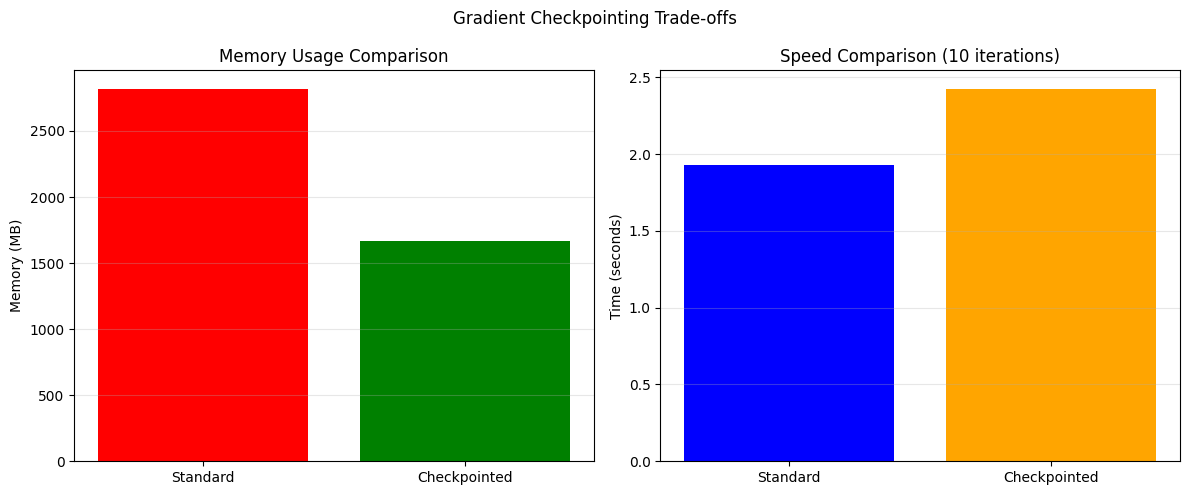


Time comparison:
Standard: 1.931s
Checkpointed: 2.424s
Slowdown: 1.26x


In [66]:
def compare_memory_usage():
    """Compare memory usage with and without gradient checkpointing"""

    if not torch.cuda.is_available():
        print("CUDA not available, skipping memory comparison")
        return

    d_model = 512
    n_heads = 8
    n_layers = 12
    seq_len = 512
    batch_size = 4

    # Model without checkpointing
    class StandardTransformer(nn.Module):
        def __init__(self):
            super().__init__()
            self.blocks = nn.ModuleList([
                TransformerBlock(d_model, n_heads) for _ in range(n_layers)
            ])

        def forward(self, x):
            for block in self.blocks:
                x, _ = block(x)
            return x

    # Model with checkpointing
    class CheckpointedTransformer(nn.Module):
        def __init__(self):
            super().__init__()
            self.blocks = nn.ModuleList([
                CheckpointedTransformerBlock(d_model, n_heads) for _ in range(n_layers)
            ])

        def forward(self, x):
            for block in self.blocks:
                x, _ = block(x)
            return x

    # Test input
    x = torch.randn(batch_size, seq_len, d_model, device=device, requires_grad=True)
    target = torch.randn(batch_size, seq_len, d_model, device=device)

    # Standard model
    torch.cuda.reset_peak_memory_stats()
    standard_model = StandardTransformer().cuda()
    standard_model.train()

    output = standard_model(x)
    loss = F.mse_loss(output, target)
    loss.backward()

    standard_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB

    # Checkpointed model
    torch.cuda.reset_peak_memory_stats()
    checkpointed_model = CheckpointedTransformer().cuda()
    checkpointed_model.train()

    output = checkpointed_model(x)
    loss = F.mse_loss(output, target)
    loss.backward()

    checkpointed_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB

    print(f"Memory usage comparison:")
    print(f"Standard model: {standard_memory:.2f} MB")
    print(f"Checkpointed model: {checkpointed_memory:.2f} MB")
    print(f"Memory saved: {standard_memory - checkpointed_memory:.2f} MB")
    print(f"Reduction: {(1 - checkpointed_memory/standard_memory)*100:.1f}%")

    # Visualize trade-offs
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Memory comparison
    models = ['Standard', 'Checkpointed']
    memories = [standard_memory, checkpointed_memory]

    axes[0].bar(models, memories, color=['red', 'green'])
    axes[0].set_ylabel('Memory (MB)')
    axes[0].set_title('Memory Usage Comparison')
    axes[0].grid(True, alpha=0.3, axis='y')

    # Time comparison (checkpointing is slower)
    # Measure forward + backward time
    import time

    times = []
    for model, name in [(standard_model, 'Standard'),
                        (checkpointed_model, 'Checkpointed')]:
        torch.cuda.synchronize()
        start = time.time()

        for _ in range(10):
            output = model(x)
            loss = F.mse_loss(output, target)
            loss.backward()
            model.zero_grad()

        torch.cuda.synchronize()
        elapsed = time.time() - start
        times.append(elapsed)

    axes[1].bar(models, times, color=['blue', 'orange'])
    axes[1].set_ylabel('Time (seconds)')
    axes[1].set_title('Speed Comparison (10 iterations)')
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.suptitle('Gradient Checkpointing Trade-offs')
    plt.tight_layout()
    plt.show()

    print(f"\nTime comparison:")
    print(f"Standard: {times[0]:.3f}s")
    print(f"Checkpointed: {times[1]:.3f}s")
    print(f"Slowdown: {times[1]/times[0]:.2f}x")

compare_memory_usage()

#Checkpoint as a “save-and-resume”

Gradient checkpointing and save-and-resume are two distinct mechanisms in PyTorch. Gradient checkpointing is a memory optimization technique and is unrelated to persisting training progress. In contrast, save-and-resume is concerned with capturing the training state to allow continuation after interruption.

For save-and-resume, the following elements are typically preserved:

1. Model parameters, using `model.state_dict()`.
2. Optimizer state, using `optimizer.state_dict()`.
3. Learning rate scheduler state, if present, using `scheduler.state_dict()`.
4. Training step or epoch counter.
5. Random number generator states for reproducibility, via `torch.get_rng_state()` and, if applicable, `numpy` RNG states.

A checkpoint can be saved as follows:

```python
import torch

checkpoint = {
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "scheduler_state": scheduler.state_dict() if scheduler else None,
    "step": current_step,
    "rng_state": torch.get_rng_state() # Random Number Generator
}
torch.save(checkpoint, "checkpoint.pt")
```

To resume training, the checkpoint is loaded and the stored states restored:

```python
checkpoint = torch.load("checkpoint.pt")
model.load_state_dict(checkpoint["model_state"])
optimizer.load_state_dict(checkpoint["optimizer_state"])
if scheduler and checkpoint["scheduler_state"]:
    scheduler.load_state_dict(checkpoint["scheduler_state"])
current_step = checkpoint["step"]
torch.set_rng_state(checkpoint["rng_state"]) # Random Number Generator
```

For large-scale language models, additional considerations include:

* Sharding model weights across multiple files to accommodate GPU memory constraints.
* Saving at intervals, rather than every batch, to balance storage requirements and fault tolerance.
* Using reduced-precision formats (e.g., FP16 or BF16) to reduce checkpoint size.
* For distributed training, frameworks such as DeepSpeed or Hugging Face Accelerate manage sharded checkpoints efficiently, preserving model, optimizer, and RNG states.

In a typical training loop, periodic checkpointing ensures that training can be resumed with identical model and optimizer states, maintaining reproducibility and continuity:

```python
for step, batch in enumerate(dataloader, start=start_step):
    optimizer.zero_grad()
    loss = model(**batch).loss
    loss.backward()
    optimizer.step()
    
    if step % checkpoint_interval == 0:
        torch.save({
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict() if scheduler else None,
            "step": step,
            "rng_state": torch.get_rng_state()
        }, f"checkpoint_{step}.pt")
```

The procedure allows training to resume exactly from the last saved state, including optimizer momentum and learning rate schedule.
